### Settings and imports

In [1]:
%matplotlib notebook

In [2]:
import masserstein 

In [3]:
import os

from masserstein import Spectrum, NMRSpectrum
from masserstein import estimate_proportions

from matplotlib import pyplot as plt

import numpy as np

import pulp

import pickle

import seaborn as sns
from textwrap import wrap

### Ground truth

In [4]:
protons = [4, 4, 5, 5, 13]

In [5]:
molar_proportions = [0.3022, 0.2240, 0.1253, 0.2028, 0.1457]

In [6]:
real_visible_proportions = [prop*prot for prop, prot in zip(molar_proportions, protons)]
real_visible_proportions = [p/sum(real_visible_proportions) for p in real_visible_proportions]
real_visible_proportions

[0.2143490442245629,
 0.1588821505833954,
 0.11109337872823348,
 0.1798063623789765,
 0.3358690640848317]

### Loading the data

In [7]:
official_names = ['Lactate', 'Alanine', 'Creatine', 'Creatinine', 'Choline chloride']

In [8]:
components = np.loadtxt('metabolity.csv', delimiter=',', skiprows=1)
ppm_components = components[:,0]
components = components[:,1:]

mix = np.loadtxt('mieszanina_metabolitow.csv', delimiter=',', skiprows=1)
ppm = mix[:,0]
mix = mix[:,1]

In [9]:
# ppm = #np.array with shape (number_of_points on frequency axis for mixture,)
# mix = #np.array with shape (number_of_points on frequency axis,)
# ppm_comp = #np.array with shape (number_of_points on frequency axis for components, )
# components = #np.array with shape (number_of_points on frequency axis for components, number of components)
# real_visible_proportions = #np.array with shape (number of components,)

In [10]:
components_ints = []
names = []
for i in range(components.shape[1]):
    components_ints.append(components[:,i])
    names.append('comp'+str(i))

In [11]:
spectra = []
for i, comp_ints in enumerate(components_ints):
    spectra.append(NMRSpectrum(confs=list(zip(ppm_components, comp_ints)), protons=protons[i]))

In [12]:
mix = NMRSpectrum(confs=list(zip(ppm,mix)))

<IPython.core.display.Javascript object>


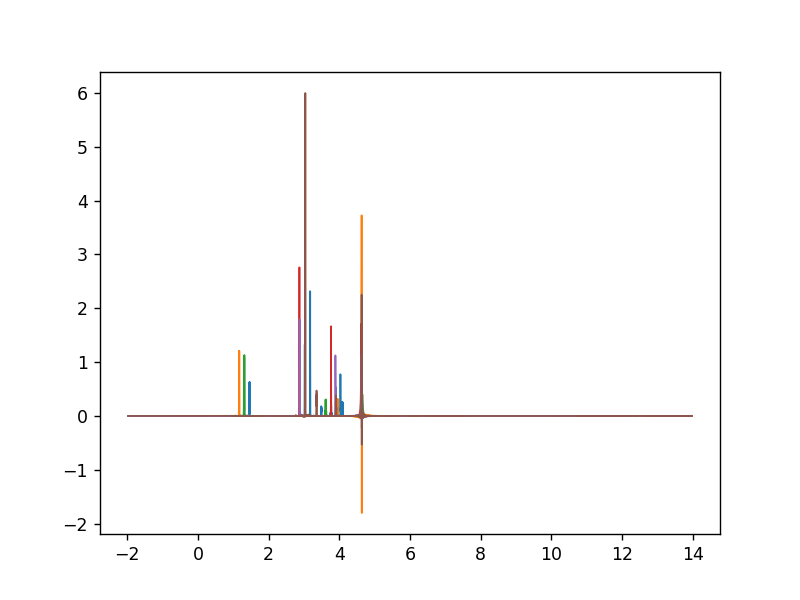

In [13]:
mix.plot(profile=True)
spectra[0].plot(profile=True)
spectra[1].plot(profile=True)
spectra[2].plot(profile=True)
spectra[3].plot(profile=True)
spectra[4].plot(profile=True)

### Additional preprocessing: removing peak from solvent

In [14]:
def remove_peak_from_region(spectrum, region):
    
    lower_bound = region[0]
    upper_bound = region[1]
    
    new_confs = np.array(spectrum.confs)
    in_region = np.logical_and(lower_bound < new_confs[:,0], new_confs[:,0] < upper_bound)
    new_confs[in_region, 1] = 0
    
    return NMRSpectrum(confs=list(zip(new_confs[:,0], new_confs[:,1])))

In [15]:
preprocessed_spectra = []
for sp in [mix] + spectra:
    no_solvent_peak = remove_peak_from_region(sp, (4.4, 4.8))
    no_solvent_peak.normalize()
    preprocessed_spectra.append(no_solvent_peak)
mix = preprocessed_spectra[0]
spectra = preprocessed_spectra[1:]
del(preprocessed_spectra)

### Alignment

In [16]:
def shift_one_spectrum(sp, how_much):
    res = sp
    old_confs = np.array(sp.confs)

    new_ppm_non_unique = old_confs[:,0] + how_much
    resampled = sp.resample(np.unique(new_ppm_non_unique) + how_much)
    new_ppm_unique = np.array(resampled.confs)[:,0]
    new_ints = np.array(resampled.confs)[:,1]
    res = Spectrum(confs=list(zip(new_ppm_unique + how_much, new_ints)))
    return(res)

In [17]:
# shift_right = [0.14, 0.15, 0.14, 0.14, 0.14] #equivalently, we can shift mixture 0.14 to the left
mix = shift_one_spectrum(mix, -0.14)

### Preprocessing

In [18]:
def shift(list_of_spectra, epsilon=0.001):
    res = list_of_spectra
    shifted_unique = []
    old_confs = [np.array(sp.confs) for sp in list_of_spectra]
    min_of_min = min([min(old_conf[:,0]) for old_conf in old_confs])
    if min_of_min<0:
        return (min_of_min - epsilon)*(-1)
    else:
        return(0)

In [19]:
def make_nonnegative(spectrum):
    confs = np.array(spectrum.confs)
    neg = confs[:,1]<0
    confs[:,1][neg]=0
    new_confs = list(zip(confs[:,0],confs[:,1]))
    result = NMRSpectrum(confs=new_confs)
    return(result)

In [20]:
def common_mass_axis(list_of_spectra):
    all_mz = set()
    for sp in list_of_spectra:
        mz_set = set(np.array(sp.confs, np.dtype('float'))[:,0])
        all_mz = all_mz.union(mz_set)
    all_mz = np.array(sorted(all_mz))
    return all_mz

In [21]:
spectra_and_mixture = spectra + [mix]

In [22]:
#spectra_and_mixture = shift(spectra_and_mixture)

In [23]:
shift_coef = shift(spectra_and_mixture)

In [24]:
preprocessed_spectra = []
for sp in spectra_and_mixture:
    sp2 = make_nonnegative(sp)
    sp2.sort_confs()
    sp2.merge_confs()
    sp2.normalize()
    preprocessed_spectra.append(sp2)

In [25]:
spectra_and_mixture = preprocessed_spectra
spectra = spectra_and_mixture[:-1]
mix = preprocessed_spectra[-1]
del(preprocessed_spectra)

In [26]:
cma = common_mass_axis(spectra_and_mixture)

In [27]:
preprocessed_spectra = []
for sp in spectra_and_mixture:
    preprocessed_spectra.append(sp.resample(cma))

In [28]:
spectra_and_mixture = preprocessed_spectra
del(preprocessed_spectra)

In [29]:
preprocessed_spectra = []
for sp in spectra_and_mixture:
    sp = make_nonnegative(sp)
    sp.sort_confs()
    sp.merge_confs()
    sp.normalize()
    preprocessed_spectra.append(sp)

In [30]:
spectra_and_mixture = preprocessed_spectra
spectra = spectra_and_mixture[:-1]
mix = preprocessed_spectra[-1]
del(preprocessed_spectra)

<IPython.core.display.Javascript object>


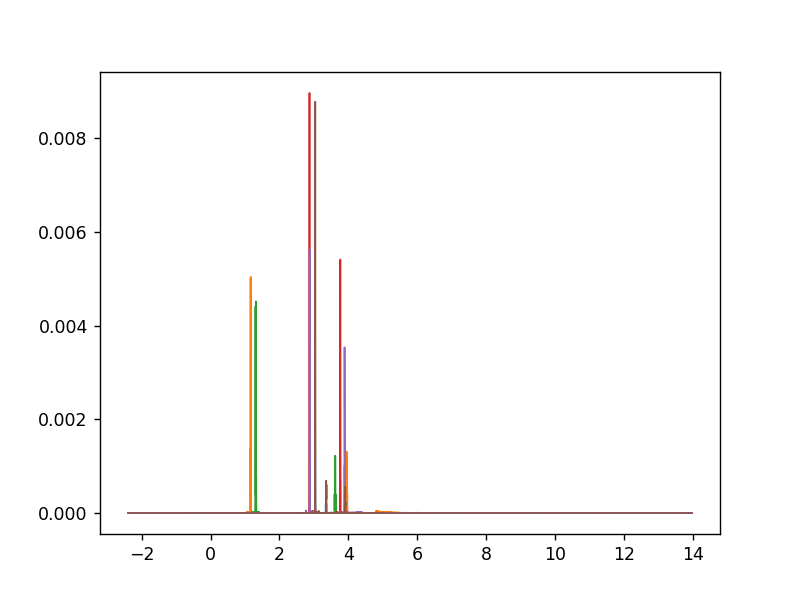

In [31]:
mix.plot(profile=True)
spectra[0].plot(profile=True)
spectra[1].plot(profile=True)
spectra[2].plot(profile=True)
spectra[3].plot(profile=True)
spectra[4].plot(profile=True)

### Removing unnecessary data points

In [32]:
def cut_spectra_to_region(list_of_spectra, lower_bound, upper_bound):
    res = []
    for sp in list_of_spectra:
        ppm = np.array(sp.confs)[:,0]
        ints = np.array(sp.confs)[:,1]
        ppm_in_region = np.logical_and(ppm>lower_bound, ppm<upper_bound)
        new_ppm = ppm[ppm_in_region]
        new_ints = ints[ppm_in_region]
        res.append(masserstein.NMRSpectrum(confs=list(zip(new_ppm, new_ints))))
    return res

In [33]:
#3.2, 6.5
#preprocessed_spectra = cut_spectra_to_region(spectra_and_mixture, 1, 4.3)
preprocessed_spectra = cut_spectra_to_region(spectra_and_mixture, 3.2-shift_coef, 6.5-shift_coef)

In [34]:
spectra_and_mixture = preprocessed_spectra
spectra = spectra_and_mixture[:-1]
mix = preprocessed_spectra[-1]
del(preprocessed_spectra)

In [35]:
preprocessed_spectra = []
for sp in spectra_and_mixture:
    sp2 = make_nonnegative(sp)
    sp2.sort_confs()
    sp2.merge_confs()
    sp2.normalize()
    preprocessed_spectra.append(sp2)

In [36]:
spectra_and_mixture = preprocessed_spectra
spectra = spectra_and_mixture[:-1]
mix = preprocessed_spectra[-1]
del(preprocessed_spectra)

In [37]:
for i, sp in enumerate(spectra):
    sp.protons = protons[i]

In [38]:
for i, name in enumerate(names):
    globals()[name] = spectra[i]

In [39]:
components_ints = []
for spectrum in spectra:
    components_ints.append(np.array(spectrum.confs)[:,1])#.reshape(-1,1))

In [40]:
ppm = np.array(mix.confs)[:,0]
mix_ints = np.array(mix.confs)[:,1]

In [41]:
labels = ['Lactate', 'Alanine', 'Creatine', 'Creatinine', 'Choline chloride', 'Mixture']
for i, sp in enumerate(spectra_and_mixture):
    sp.label = labels[i]

<IPython.core.display.Javascript object>


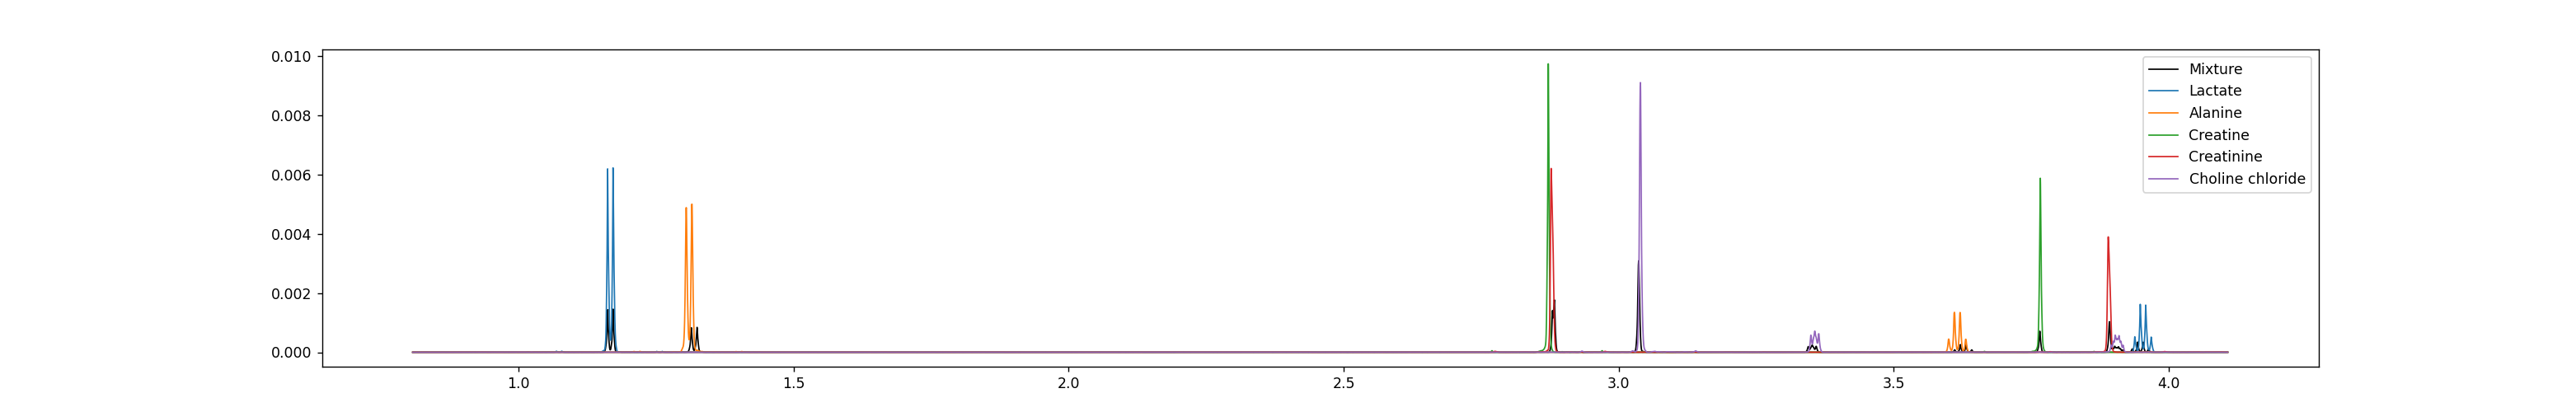

In [42]:
fig, ax = plt.subplots()
fig.set_size_inches(25, 4, forward=True)
mix.plot(profile=True, color='black')
comp0.plot(profile=True)
comp1.plot(profile=True) 
comp2.plot(profile=True)
comp3.plot(profile=True)
comp4.plot(profile=True)
ax.legend()
#plt.savefig('aligned_spectra.png', dpi=300)

### Finding best values of kappa and kappa' parameters

In [43]:
import time
import pandas as pd
import pulp

In [44]:
lower_limit = 0.01
upper_limit = 0.31
step = 0.01

In [42]:
# list_of_estimation_results = []
# for kappa in np.arange(start=lower_limit, stop=upper_limit, step=step):
#     fixed_kappa = []
#     for kappa_prime in np.arange(start=lower_limit, stop=upper_limit, step=step):
#         start = time.time()
#         estimation = estimate_proportions(mix, [comp0, comp1, comp2, comp3, comp4], 
#                                    MTD=kappa, MTD_th=kappa_prime, verbose=False, solver=pulp.GUROBI(msg=False),
#                                        what_to_compare='area')
#         end = time.time()
#         fixed_kappa.append(estimation['proportions'])
#         print('Estimation for '+str(kappa)+' and '+str(kappa_prime)+' done')
#         print('It took: '+str(end-start)+' seconds.')
#         print(estimation['proportions'])
#     list_of_estimation_results.append(fixed_kappa)

Set parameter Username
Academic license - for non-commercial use only - expires 2023-11-10


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 194180.74it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2905330.61it/s]
Deconvolving chunks:   0%|                                | 0/1 [00:00<?, ?it/s]/home/basia/.local/lib/python3.10/site-packages/pulp/pulp.py:1352: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:51<00:00, 51.64s/it]


Estimation for 0.01 and 0.01 done
It took: 51.70339298248291 seconds.
[0.00044281237399999764, 0.22748904409999876, 0.06217346024899966, 0.0, 0.10047150525999946]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 194180.74it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2018471.13it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:36<00:00, 36.05s/it]


Estimation for 0.01 and 0.02 done
It took: 36.144468784332275 seconds.
[0.000182825796999999, 0.19570565650299895, 5.728793699999969e-05, 4.202258899999977e-05, 0.002370577719999987]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 243854.88it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3140605.37it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:53<00:00, 53.81s/it]


Estimation for 0.01 and 0.03 done
It took: 53.866013288497925 seconds.
[0.00021222474599999884, 0.14192916920999923, 6.491597799999965e-05, 4.9433722999999726e-05, 0.0017685726899999905]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 179243.76it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2955974.26it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:47<00:00, 47.85s/it]


Estimation for 0.01 and 0.04 done
It took: 47.904340505599976 seconds.
[0.00029312343099999845, 0.008855849789999952, 8.496406099999953e-05, 6.745788999999963e-05, 0.002045479442999989]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 129453.83it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3179925.47it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:40<00:00, 40.32s/it]


Estimation for 0.01 and 0.05 done
It took: 40.385080099105835 seconds.
[0.00029710037299999836, 0.0019425413739999893, 8.599777599999953e-05, 6.846038799999963e-05, 0.002049522771999989]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 62415.24it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2904218.31it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:44<00:00, 44.23s/it]


Estimation for 0.01 and 0.060000000000000005 done
It took: 44.30077266693115 seconds.
[0.00029710307499999835, 0.0019372546109999893, 8.599849599999952e-05, 6.846109899999964e-05, 0.002049524190999989]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 225500.22it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3256181.81it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:49<00:00, 49.49s/it]


Estimation for 0.01 and 0.06999999999999999 done
It took: 49.54900884628296 seconds.
[0.00029710707399999836, 0.0019270338669999897, 8.678293199999953e-05, 6.766207699999963e-05, 0.0020495269679999886]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 127875.12it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2860486.02it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:41<00:00, 41.25s/it]


Estimation for 0.01 and 0.08 done
It took: 41.313973903656006 seconds.
[0.00029711589299999836, 0.0019230135909999895, 8.678382599999953e-05, 6.765704699999963e-05, 0.0020425307539999886]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 54189.97it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1793563.78it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:47<00:00, 47.22s/it]


Estimation for 0.01 and 0.09 done
It took: 47.30191254615784 seconds.
[0.0002971251399999984, 0.0019182743129999896, 8.769624699999952e-05, 6.672782699999964e-05, 0.0020329533389999888]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 170500.16it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3080410.22it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:51<00:00, 51.93s/it]


Estimation for 0.01 and 0.09999999999999999 done
It took: 51.98874378204346 seconds.
[0.00029713481599999837, 0.0019135250319999896, 8.884843799999951e-05, 6.554089899999965e-05, 0.0020238665269999893]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 176231.26it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2898152.75it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:52<00:00, 52.87s/it]


Estimation for 0.01 and 0.11 done
It took: 52.93167519569397 seconds.
[0.00029714389199999837, 0.0019044438249999896, 8.886260399999952e-05, 6.522127799999965e-05, 0.002016105218999989]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 207638.81it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2921442.74it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:35<00:00, 35.31s/it]


Estimation for 0.01 and 0.12 done
It took: 35.36474823951721 seconds.
[0.0002971623899999984, 0.0018916442189999899, 8.908824499999951e-05, 6.409601099999965e-05, 0.0019973311079999894]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 216201.24it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3115325.76it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:44<00:00, 44.48s/it]


Estimation for 0.01 and 0.13 done
It took: 44.54424810409546 seconds.
[0.0002971658419999984, 0.0018848681809999898, 8.908921999999951e-05, 6.409674899999965e-05, 0.001997332817999989]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 124091.83it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3152788.04it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:33<00:00, 33.36s/it]


Estimation for 0.01 and 0.14 done
It took: 33.41804480552673 seconds.
[0.0002971677539999984, 0.0018819689649999898, 8.90897679999995e-05, 6.409715899999964e-05, 0.001997336460999989]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 60262.99it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2649851.50it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:50<00:00, 50.19s/it]


Estimation for 0.01 and 0.15000000000000002 done
It took: 50.24544811248779 seconds.
[0.0002971674009999984, 0.0018819757309999898, 9.036615099999951e-05, 6.279586599999967e-05, 0.001997336572999989]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 177724.75it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2845393.18it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:55<00:00, 55.83s/it]


Estimation for 0.01 and 0.16 done
It took: 55.892253160476685 seconds.
[0.0002971673979999984, 0.0018819757279999899, 9.036612599999952e-05, 6.279658599999966e-05, 0.001997336572999989]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 30174.85it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2881857.80it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:33<00:00, 33.32s/it]


Estimation for 0.01 and 0.17 done
It took: 33.38560461997986 seconds.
[0.00029717094999999835, 0.0018819757219999899, 9.036614099999951e-05, 6.279586099999966e-05, 0.0019973365659999892]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 201649.23it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2978178.69it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:53<00:00, 53.22s/it]


Estimation for 0.01 and 0.18000000000000002 done
It took: 53.283228397369385 seconds.
[0.00029717094999999835, 0.0018819757219999899, 9.036614099999951e-05, 6.279586099999966e-05, 0.0019973365659999892]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 177724.75it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2829966.01it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:38<00:00, 38.80s/it]


Estimation for 0.01 and 0.19 done
It took: 38.86012387275696 seconds.
[0.00029717094999999835, 0.0018819757219999899, 9.036614099999951e-05, 6.279586099999966e-05, 0.0019973365659999892]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 81284.96it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2649419.61it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:34<00:00, 34.83s/it]


Estimation for 0.01 and 0.2 done
It took: 34.90121078491211 seconds.
[0.00029717094999999835, 0.0018819757219999899, 9.036614099999951e-05, 6.279586099999966e-05, 0.0019973365659999892]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 188932.61it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2831797.15it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:38<00:00, 38.34s/it]


Estimation for 0.01 and 0.21000000000000002 done
It took: 38.40442752838135 seconds.
[0.00029717094999999835, 0.0018819757219999899, 9.036614099999951e-05, 6.279586099999966e-05, 0.0019973365659999892]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 73584.28it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2182132.00it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:34<00:00, 34.59s/it]


Estimation for 0.01 and 0.22 done
It took: 34.66488027572632 seconds.
[0.00029717094999999835, 0.0018819757219999899, 9.036614099999951e-05, 6.279586099999966e-05, 0.0019973365659999892]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 220752.84it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2530799.43it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:39<00:00, 39.91s/it]


Estimation for 0.01 and 0.23 done
It took: 39.97302222251892 seconds.
[0.00029717094999999835, 0.0018819757219999899, 9.036614099999951e-05, 6.279586099999966e-05, 0.0019973365659999892]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 135300.13it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2782901.42it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:34<00:00, 34.37s/it]


Estimation for 0.01 and 0.24000000000000002 done
It took: 34.43380928039551 seconds.
[0.00029717094999999835, 0.0018819757219999899, 9.036614099999951e-05, 6.279586099999966e-05, 0.0019973365659999892]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 190650.18it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3042277.77it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:38<00:00, 38.71s/it]


Estimation for 0.01 and 0.25 done
It took: 38.775649547576904 seconds.
[0.00029717094999999835, 0.0018819757219999899, 9.036614099999951e-05, 6.279586099999966e-05, 0.0019973365659999892]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 110376.42it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2546716.05it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:35<00:00, 35.38s/it]


Estimation for 0.01 and 0.26 done
It took: 35.45592927932739 seconds.
[0.00029717094999999835, 0.0018819757219999899, 9.036614099999951e-05, 6.279586099999966e-05, 0.0019973365659999892]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 94466.31it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2249694.01it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:37<00:00, 37.45s/it]


Estimation for 0.01 and 0.27 done
It took: 37.51117300987244 seconds.
[0.00029717094999999835, 0.0018819757219999899, 9.036614099999951e-05, 6.279586099999966e-05, 0.0019973365659999892]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 143640.55it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2530292.93it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:35<00:00, 35.16s/it]


Estimation for 0.01 and 0.28 done
It took: 35.23696756362915 seconds.
[0.00029717094999999835, 0.0018819757219999899, 9.036614099999951e-05, 6.279586099999966e-05, 0.0019973365659999892]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 148734.18it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2990309.92it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:34<00:00, 34.89s/it]


Estimation for 0.01 and 0.29000000000000004 done
It took: 34.94703960418701 seconds.
[0.00029717094999999835, 0.0018819757219999899, 9.036614099999951e-05, 6.279586099999966e-05, 0.0019973365659999892]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 87746.95it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2031879.31it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:34<00:00, 34.95s/it]


Estimation for 0.01 and 0.3 done
It took: 35.02543663978577 seconds.
[0.00029717094999999835, 0.0018819757219999899, 9.036614099999951e-05, 6.279586099999966e-05, 0.0019973365659999892]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 235635.06it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3037405.19it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:48<00:00, 48.00s/it]


Estimation for 0.02 and 0.01 done
It took: 48.05936789512634 seconds.
[0.0, 0.02034836757299989, 0.006745783611999964, 0.2659886504679986, 0.7040677365449962]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 155344.59it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3079409.85it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:36<00:00, 36.24s/it]


Estimation for 0.02 and 0.02 done
It took: 36.30244851112366 seconds.
[0.00010254782699999944, 0.20773152264699887, 0.07537399506199959, 0.0, 0.25571605474799863]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 211833.54it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2883756.73it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:55<00:00, 55.75s/it]


Estimation for 0.02 and 0.03 done
It took: 55.813968896865845 seconds.
[0.00013778166999999923, 0.21102728322399886, 0.006241787767999966, 0.0, 0.2056616942119989]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 176231.26it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2868851.91it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:30<00:00, 30.62s/it]


Estimation for 0.02 and 0.04 done
It took: 30.68239665031433 seconds.
[0.00017701980399999903, 0.21216224406799883, 0.00013898060199999925, 0.0, 0.15486176076799918]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 49932.19it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1478198.33it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:45<00:00, 45.78s/it]


Estimation for 0.02 and 0.05 done
It took: 45.86136484146118 seconds.
[0.00025109075099999866, 0.19945000619499892, 0.00014701327399999919, 0.0, 0.09722977887399947]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 185588.67it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2541766.77it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:48<00:00, 48.01s/it]


Estimation for 0.02 and 0.060000000000000005 done
It took: 48.075246810913086 seconds.
[0.0003032513049999984, 0.19193714499599895, 0.0001314269439999993, 2.386245699999987e-05, 0.03917659960199978]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 90006.52it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2702336.27it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:47<00:00, 47.80s/it]


Estimation for 0.02 and 0.06999999999999999 done
It took: 47.867992639541626 seconds.
[0.0003869542269999979, 0.12263612950699933, 0.00013374402399999927, 6.499720599999965e-05, 0.012355460843999933]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 209715.20it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3085338.21it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:12<00:00, 72.58s/it]


Estimation for 0.02 and 0.08 done
It took: 72.63939690589905 seconds.
[0.0005087071669999972, 0.009542693184999947, 0.0001662024679999991, 9.811913499999947e-05, 0.006540669600999964]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 106454.42it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3205365.59it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:06<00:00, 66.54s/it]


Estimation for 0.02 and 0.09 done
It took: 66.59300136566162 seconds.
[0.0005144991169999972, 0.002559987166999986, 0.00016873399599999907, 0.00010043714999999946, 0.006566745749999965]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 119156.36it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2999849.02it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:08<00:00, 68.37s/it]


Estimation for 0.02 and 0.09999999999999999 done
It took: 68.42776298522949 seconds.
[0.0005145218429999972, 0.002550101110999986, 0.00017110583199999907, 9.732795999999947e-05, 0.006556527902999964]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 135300.13it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3020713.93it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:07<00:00, 67.89s/it]


Estimation for 0.02 and 0.11 done
It took: 67.94465589523315 seconds.
[0.0005145639639999972, 0.002542095305999986, 0.00017345037099999905, 9.474063899999948e-05, 0.006507217278999965]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 246723.76it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3154536.14it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:03<00:00, 63.25s/it]


Estimation for 0.02 and 0.12 done
It took: 63.30261015892029 seconds.
[0.0005146560799999971, 0.0025228908039999862, 0.00017345643399999905, 9.473058899999949e-05, 0.006371680141999965]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 223101.28it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3267495.78it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:02<00:00, 62.86s/it]


Estimation for 0.02 and 0.13 done
It took: 62.91757774353027 seconds.
[0.0005147191689999972, 0.0025102902509999865, 0.00017470010699999905, 9.345775699999948e-05, 0.006284492412999966]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 127100.12it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3062419.88it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:56<00:00, 56.18s/it]


Estimation for 0.02 and 0.14 done
It took: 56.241034507751465 seconds.
[0.0005147956629999972, 0.0025029805879999865, 0.00017675037499999906, 9.13416829999995e-05, 0.006173872421999966]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 55775.32it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1921433.19it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:06<00:00, 66.78s/it]


Estimation for 0.02 and 0.15000000000000002 done
It took: 66.86365723609924 seconds.
[0.0005148495229999972, 0.0024969287789999867, 0.00017967401799999903, 8.835864699999953e-05, 0.006104660397999967]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 235635.06it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3205185.01it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:07<00:00, 67.63s/it]


Estimation for 0.02 and 0.16 done
It took: 67.68037128448486 seconds.
[0.0005148537059999972, 0.0024928969079999865, 0.00017967605299999903, 8.834898899999952e-05, 0.006104709879999967]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 180788.97it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3078326.84it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:06<00:00, 66.51s/it]


Estimation for 0.02 and 0.17 done
It took: 66.56875944137573 seconds.
[0.0005149063429999972, 0.0024920763289999867, 0.00018301432999999899, 8.492787099999954e-05, 0.006033267962999967]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 243854.88it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3210973.65it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:08<00:00, 68.45s/it]


Estimation for 0.02 and 0.18000000000000002 done
It took: 68.50247502326965 seconds.
[0.0005149104029999971, 0.0024884336919999864, 0.000183015796999999, 8.492868699999954e-05, 0.006032184114999967]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 230456.26it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3197259.64it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:42<00:00, 42.97s/it]


Estimation for 0.02 and 0.19 done
It took: 43.02614688873291 seconds.
[0.0005149124859999972, 0.0024884435629999864, 0.000183017034999999, 8.490899299999954e-05, 0.006032207624999967]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 119837.26it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2438072.32it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:42<00:00, 42.42s/it]


Estimation for 0.02 and 0.2 done
It took: 42.494975090026855 seconds.
[0.0005149128079999972, 0.0024884451149999867, 0.000183017149999999, 8.490904599999954e-05, 0.006032211386999967]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 58092.85it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3103261.06it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:47<00:00, 47.72s/it]


Estimation for 0.02 and 0.21000000000000002 done
It took: 47.773927211761475 seconds.
[0.0005149128079999972, 0.0024884451149999867, 0.000183017149999999, 8.490904599999954e-05, 0.006032211386999967]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 156503.88it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3072508.32it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:39<00:00, 39.45s/it]


Estimation for 0.02 and 0.22 done
It took: 39.50233793258667 seconds.
[0.0005149128079999972, 0.0024884451149999867, 0.000183017149999999, 8.490904599999954e-05, 0.006032211386999967]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 218453.33it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3110896.83it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:50<00:00, 50.99s/it]


Estimation for 0.02 and 0.23 done
It took: 51.048715591430664 seconds.
[0.0005149128079999972, 0.0024884451149999867, 0.000183017149999999, 8.490904599999954e-05, 0.006032211386999967]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 121927.44it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2942444.55it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:45<00:00, 45.18s/it]


Estimation for 0.02 and 0.24000000000000002 done
It took: 45.23482346534729 seconds.
[0.0005149128079999972, 0.0024884451149999867, 0.000183017149999999, 8.490904599999954e-05, 0.006032211386999967]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 182361.04it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2064467.83it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:41<00:00, 41.11s/it]


Estimation for 0.02 and 0.25 done
It took: 41.179765462875366 seconds.
[0.0005149127299999972, 0.0024884449399999865, 0.000183016623999999, 8.492907099999954e-05, 0.006032211379999967]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 243854.88it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2954132.44it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:52<00:00, 52.49s/it]


Estimation for 0.02 and 0.26 done
It took: 52.54811406135559 seconds.
[0.0005149127299999972, 0.0024884449399999865, 0.000183016623999999, 8.492907099999954e-05, 0.006032211379999967]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 131072.00it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2992984.20it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:38<00:00, 38.57s/it]


Estimation for 0.02 and 0.27 done
It took: 38.63123559951782 seconds.
[0.0005149128079999972, 0.0024884451149999867, 0.000183017149999999, 8.490904599999954e-05, 0.006032211386999967]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 207638.81it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2212468.86it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:42<00:00, 42.33s/it]


Estimation for 0.02 and 0.28 done
It took: 42.39253878593445 seconds.
[0.0005149128079999972, 0.0024884451149999867, 0.000183017149999999, 8.490904599999954e-05, 0.006032211386999967]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 115228.13it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3067952.04it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:45<00:00, 45.24s/it]


Estimation for 0.02 and 0.29000000000000004 done
It took: 45.29854202270508 seconds.
[0.0005149128079999972, 0.0024884451149999867, 0.000183017149999999, 8.490904599999954e-05, 0.006032211386999967]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 74631.74it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2748816.84it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:39<00:00, 39.68s/it]


Estimation for 0.02 and 0.3 done
It took: 39.765748500823975 seconds.
[0.0005149128079999972, 0.0024884451149999867, 0.000183017149999999, 8.490904599999954e-05, 0.006032211386999967]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 171897.70it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2833489.55it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:00<00:00, 60.06s/it]


Estimation for 0.03 and 0.01 done
It took: 60.11578845977783 seconds.
[0.40767978421599776, 0.010067260009999945, 0.0030658995949999837, 0.20987561281299885, 0.369311443365998]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 205603.14it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2869285.96it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:39<00:00, 39.73s/it]


Estimation for 0.03 and 0.02 done
It took: 39.79161882400513 seconds.
[0.0, 0.2252733708889988, 0.10356851530999943, 0.018812720488999898, 0.5243045990119971]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 142663.40it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2334097.91it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:43<00:00, 43.46s/it]


Estimation for 0.03 and 0.03 done
It took: 43.523749351501465 seconds.
[5.813305499999968e-05, 0.1983739895549989, 0.08618927312499952, 0.013752998196999926, 0.23079196186999876]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 94042.69it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2908375.25it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:48<00:00, 48.19s/it]


Estimation for 0.03 and 0.04 done
It took: 48.25071930885315 seconds.
[0.00024323831399999867, 0.2029252844409989, 0.05722526957499969, 0.0, 0.23330791982399873]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 83886.08it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2706771.81it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:31<00:00, 31.14s/it]


Estimation for 0.03 and 0.05 done
It took: 31.198801279067993 seconds.
[0.0003473448159999981, 0.21018591065799885, 0.00042642286399999766, 0.0, 0.2412372928049987]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 29248.98it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2343375.27it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:36<00:00, 36.58s/it]


Estimation for 0.03 and 0.060000000000000005 done
It took: 36.64068102836609 seconds.
[0.0003455367099999981, 0.21019122080499886, 0.0004281487019999977, 0.0, 0.2411237364339987]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 64527.75it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2105339.30it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:34<00:00, 34.99s/it]


Estimation for 0.03 and 0.06999999999999999 done
It took: 35.0993230342865 seconds.
[0.0003463588829999981, 0.21027972352499885, 0.00043021092299999766, 0.0, 0.2409030600509987]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 199728.76it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2738892.12it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:47<00:00, 47.83s/it]


Estimation for 0.03 and 0.08 done
It took: 47.902602672576904 seconds.
[0.0003512879839999981, 0.20827358584899885, 0.0004420066019999976, 0.0, 0.23706584246999873]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 118483.16it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2472024.18it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:48<00:00, 48.62s/it]


Estimation for 0.03 and 0.09 done
It took: 48.69005537033081 seconds.
[0.0003960638159999978, 0.19500659593299893, 0.000533382955999997, 0.0, 0.2207234785169988]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 153076.79it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2968621.79it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:57<00:00, 57.70s/it]


Estimation for 0.03 and 0.09999999999999999 done
It took: 57.76271080970764 seconds.
[0.00046457734899999745, 0.186002387052999, 0.000731335192999996, 0.0, 0.18071357975199903]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 227951.30it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2496648.96it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:54<00:00, 54.57s/it]


Estimation for 0.03 and 0.11 done
It took: 54.62481999397278 seconds.
[0.0006113021579999966, 0.12118821304599933, 0.0010483767779999945, 0.0, 0.13545468509899924]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 72315.59it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1486832.26it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:51<00:00, 51.65s/it]


Estimation for 0.03 and 0.12 done
It took: 51.735368490219116 seconds.
[0.0007890118769999957, 0.04682428178999974, 0.0015349880509999915, 0.0, 0.06601976375699964]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 57772.78it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1624720.11it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:55<00:00, 55.04s/it]


Estimation for 0.03 and 0.13 done
It took: 55.11585474014282 seconds.
[0.0008525241939999953, 0.035869211174999804, 0.0013594351139999926, 0.0003453284149999981, 0.036211537878999805]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 183960.70it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3116349.61it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:11<00:00, 71.04s/it]


Estimation for 0.03 and 0.14 done
It took: 71.09319877624512 seconds.
[0.0008558807019999953, 0.034349513464999815, 0.0013910968839999924, 0.0003141982429999983, 0.0351271184689998]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 220752.84it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2911053.86it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:06<00:00, 66.93s/it]


Estimation for 0.03 and 0.15000000000000002 done
It took: 67.00097179412842 seconds.
[0.0008570121589999953, 0.03320981866899982, 0.0014116940719999924, 0.0002818692029999985, 0.03504061849899981]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 100342.20it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2506769.33it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:08<00:00, 68.50s/it]


Estimation for 0.03 and 0.16 done
It took: 68.56088852882385 seconds.
[0.0008590869699999954, 0.03093796062099983, 0.001469347438999992, 0.00022473394799999878, 0.035042328209999814]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 60262.99it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2516805.05it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:10<00:00, 70.94s/it]


Estimation for 0.03 and 0.17 done
It took: 70.99844980239868 seconds.
[0.0008603949519999953, 0.02962024287699984, 0.001491723155999992, 0.00018960937099999896, 0.03504349662199981]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 205603.14it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3011599.75it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:56<00:00, 56.81s/it]


Estimation for 0.03 and 0.18000000000000002 done
It took: 56.871132373809814 seconds.
[0.0008629071239999954, 0.02831177097999985, 0.0015181517509999917, 0.0001636672469999991, 0.03447513003899981]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 192399.27it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2969551.47it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:51<00:00, 51.57s/it]


Estimation for 0.03 and 0.19 done
It took: 51.6302285194397 seconds.
[0.0008647254439999953, 0.026523428458999854, 0.0015621750529999916, 0.00012007872999999934, 0.03443435291699981]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 62601.55it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2401132.61it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:47<00:00, 47.86s/it]


Estimation for 0.03 and 0.2 done
It took: 47.920610666275024 seconds.
[0.0008669576159999953, 0.026052401390999857, 0.0015882259339999912, 7.934703199999957e-05, 0.03360876937299982]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 38692.84it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2779027.31it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:49<00:00, 49.04s/it]


Estimation for 0.03 and 0.21000000000000002 done
It took: 49.0979061126709 seconds.
[0.0008695293449999952, 0.024332411014999868, 0.0015934596679999912, 7.54762209999996e-05, 0.03276649453899982]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 220752.84it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2902070.27it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:45<00:00, 45.17s/it]


Estimation for 0.03 and 0.22 done
It took: 45.224087953567505 seconds.
[0.0008708684839999953, 0.022940255554999876, 0.001630589993999991, 3.861981399999979e-05, 0.03278234209499982]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 207638.81it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3069938.57it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:55<00:00, 55.66s/it]


Estimation for 0.03 and 0.23 done
It took: 55.72213792800903 seconds.
[0.0008713823989999952, 0.022679765639999874, 0.001668509110999991, 0.0, 0.03267956985899982]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 86659.17it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2503735.63it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:49<00:00, 49.30s/it]


Estimation for 0.03 and 0.24000000000000002 done
It took: 49.36362409591675 seconds.
[0.0008725973049999952, 0.021749181987999883, 0.0016693014409999909, 0.0, 0.032192457267999824]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 67650.06it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2299336.66it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:49<00:00, 49.40s/it]


Estimation for 0.03 and 0.25 done
It took: 49.467251777648926 seconds.
[0.0008729433769999952, 0.021365296021999883, 0.001654538866999991, 0.0, 0.03219313964299983]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 173318.35it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3185177.28it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:00<00:00, 60.95s/it]


Estimation for 0.03 and 0.26 done
It took: 61.009263038635254 seconds.
[0.0008730299459999952, 0.021285624233999885, 0.001654646060999991, 0.0, 0.03219396082699982]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 220752.84it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2966300.14it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:54<00:00, 54.72s/it]


Estimation for 0.03 and 0.27 done
It took: 54.77734065055847 seconds.
[0.0008730351369999952, 0.021285750793999886, 0.0016546558989999909, 0.0, 0.03219415224599983]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 124091.83it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2983645.10it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:48<00:00, 48.34s/it]


Estimation for 0.03 and 0.28 done
It took: 48.40630388259888 seconds.
[0.0008730351299999952, 0.021285750791999885, 0.001654660645999991, 0.0, 0.032194152238999824]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 56223.91it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2194293.30it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:51<00:00, 51.49s/it]


Estimation for 0.03 and 0.29000000000000004 done
It took: 51.57117223739624 seconds.
[0.0008730351369999952, 0.021285750793999886, 0.0016546558989999909, 0.0, 0.03219415224599983]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2262982.24it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:58<00:00, 58.33s/it]


Estimation for 0.03 and 0.3 done
It took: 58.387961626052856 seconds.
[0.0008730351369999952, 0.021285750793999886, 0.0016546558989999909, 0.0, 0.03219415224599983]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 65128.94it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2677914.69it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:27<00:00, 27.25s/it]


Estimation for 0.04 and 0.01 done
It took: 27.30652141571045 seconds.
[0.4077189902359978, 0.010067686560999944, 0.002986350587999984, 0.20990021642599888, 0.369326756188998]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 211833.54it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2259836.22it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:37<00:00, 37.71s/it]


Estimation for 0.04 and 0.02 done
It took: 37.773799896240234 seconds.
[0.0, 0.023102202270999874, 0.004371222082999977, 0.30227105099999835, 0.6686605960019963]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 153076.79it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3126195.76it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:42<00:00, 42.55s/it]


Estimation for 0.04 and 0.03 done
It took: 42.60547614097595 seconds.
[0.00046415965199999746, 0.21416157892099882, 0.08259239102299956, 0.0, 0.25513210607299863]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 155344.59it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2803885.30it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:35<00:00, 35.67s/it]


Estimation for 0.04 and 0.04 done
It took: 35.74072480201721 seconds.
[0.0003867911819999979, 0.19805482486399892, 0.08646093624199953, 0.01471995567599992, 0.22788297146699876]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 207638.81it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2797199.37it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:46<00:00, 46.80s/it]


Estimation for 0.04 and 0.05 done
It took: 46.85915994644165 seconds.
[0.0006405663229999965, 0.2015831651999989, 0.06874197816599963, 0.0, 0.23234601083799872]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 158875.15it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2575130.09it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:36<00:00, 36.44s/it]


Estimation for 0.04 and 0.060000000000000005 done
It took: 36.5011568069458 seconds.
[0.0008016657789999957, 0.21033052868299887, 0.0006050579449999968, 0.0, 0.2422362833279987]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 203606.99it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2908449.59it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:53<00:00, 53.54s/it]


Estimation for 0.04 and 0.06999999999999999 done
It took: 53.59419870376587 seconds.
[0.0008019276329999956, 0.21042110942399886, 0.0005826327419999968, 0.0, 0.2422739040719987]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 205603.14it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2951374.00it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:39<00:00, 39.02s/it]


Estimation for 0.04 and 0.08 done
It took: 39.08174228668213 seconds.
[0.0008020977789999957, 0.21044296811099886, 0.0005830453389999968, 0.0, 0.24225331017999868]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 95760.37it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2099125.08it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:55<00:00, 55.26s/it]


Estimation for 0.04 and 0.09 done
It took: 55.358914852142334 seconds.
[0.0008028561509999956, 0.21059260142099887, 0.0005847010739999969, 0.0, 0.2421736970029987]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 147686.76it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3146945.99it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:42<00:00, 42.64s/it]


Estimation for 0.04 and 0.09999999999999999 done
It took: 42.69917368888855 seconds.
[0.0008078946879999956, 0.21178132548499884, 0.0005899350689999968, 0.0, 0.24330939838199866]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 218453.33it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2956358.26it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:36<00:00, 36.29s/it]


Estimation for 0.04 and 0.11 done
It took: 36.341882944107056 seconds.
[0.0008145626839999955, 0.21337991950099883, 0.0005953667129999968, 0.0, 0.24499525954199866]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 201649.23it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3011759.17it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:53<00:00, 53.92s/it]


Estimation for 0.04 and 0.12 done
It took: 53.97786092758179 seconds.
[0.0008359874979999955, 0.21753953885299881, 0.0006130390739999967, 0.0, 0.2511161739859986]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 225500.22it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3119681.78it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:58<00:00, 58.48s/it]


Estimation for 0.04 and 0.13 done
It took: 58.532774925231934 seconds.
[0.0008622463409999954, 0.21007429945999886, 0.0006371244149999965, 0.0, 0.25503892006699863]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 182361.04it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3043661.18it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:48<00:00, 48.11s/it]


Estimation for 0.04 and 0.14 done
It took: 48.16696858406067 seconds.
[0.0008841695309999952, 0.20344597880199888, 0.0006650129049999965, 0.0, 0.2566677099539986]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 108100.62it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2777060.41it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:53<00:00, 53.16s/it]


Estimation for 0.04 and 0.15000000000000002 done
It took: 53.22514319419861 seconds.
[0.000926129514999995, 0.19626228300399895, 0.000731774569999996, 0.0, 0.24761938489299865]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 127875.12it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3002778.10it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:53<00:00, 53.39s/it]


Estimation for 0.04 and 0.16 done
It took: 53.4498770236969 seconds.
[0.0010425925949999943, 0.18917977482499898, 0.0008860250329999952, 0.0, 0.2205811046509988]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 205603.14it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2947551.37it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:03<00:00, 63.22s/it]


Estimation for 0.04 and 0.17 done
It took: 63.278420209884644 seconds.
[0.0011669211899999936, 0.184649481413999, 0.0009682271029999947, 0.0, 0.2061746114779989]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 154202.35it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2751941.41it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:38<00:00, 38.08s/it]


Estimation for 0.04 and 0.18000000000000002 done
It took: 38.139620780944824 seconds.
[0.0011673057299999936, 0.184352534066999, 0.0009705255419999947, 0.0, 0.2063149082199989]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 93622.86it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1770098.99it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:49<00:00, 49.97s/it]


Estimation for 0.04 and 0.19 done
It took: 50.04881739616394 seconds.
[0.0011704070199999937, 0.182083343929999, 0.0009722336669999947, 0.0, 0.2065744885069989]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 216201.24it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2987640.42it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:54<00:00, 54.39s/it]


Estimation for 0.04 and 0.2 done
It took: 54.450376987457275 seconds.
[0.0011831973039999936, 0.18065826469999902, 0.0009740545939999947, 0.0, 0.2066115853289989]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 195995.51it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3181970.73it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:02<00:00, 62.60s/it]


Estimation for 0.04 and 0.21000000000000002 done
It took: 62.658971071243286 seconds.
[0.0011839120349999934, 0.18029749265299902, 0.0009746265359999946, 0.0, 0.20663512864999886]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 241051.95it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3033033.19it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:42<00:00, 42.58s/it]


Estimation for 0.04 and 0.22 done
It took: 42.64055848121643 seconds.
[0.0011850259089999935, 0.17983796606899902, 0.0009757567709999947, 0.0, 0.20660371565399888]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 54050.31it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2152086.57it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:42<00:00, 42.03s/it]


Estimation for 0.04 and 0.23 done
It took: 42.12981724739075 seconds.
[0.0011852871669999934, 0.17978572391999903, 0.0009759672459999947, 0.0, 0.2066303787279989]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 205603.14it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3088688.20it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:51<00:00, 51.46s/it]


Estimation for 0.04 and 0.24000000000000002 done
It took: 51.518911838531494 seconds.
[0.0012166324669999932, 0.17910871640199902, 0.0009769905959999946, 0.0, 0.2065677301869989]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 180788.97it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2716464.70it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:59<00:00, 59.99s/it]


Estimation for 0.04 and 0.25 done
It took: 60.049718379974365 seconds.
[0.0012056914609999934, 0.17823827937199904, 0.0009776163629999946, 0.0, 0.20676649575899886]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 81284.96it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2732774.71it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:45<00:00, 45.86s/it]


Estimation for 0.04 and 0.26 done
It took: 45.933624029159546 seconds.
[0.0012060379779999936, 0.17815565339299902, 0.0009779310949999947, 0.0, 0.20680318237099887]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 114598.47it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2974830.67it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:05<00:00, 65.47s/it]


Estimation for 0.04 and 0.27 done
It took: 65.5286910533905 seconds.
[0.0012065265149999935, 0.17791230682199902, 0.0009784068209999946, 0.0, 0.20683335526699886]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 104857.60it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2555122.57it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:06<00:00, 66.92s/it]


Estimation for 0.04 and 0.28 done
It took: 66.98259282112122 seconds.
[0.0012069468409999936, 0.17772473038899902, 0.0009788106259999946, 0.0, 0.20686301736299886]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 194180.74it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3061431.16it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:59<00:00, 59.85s/it]


Estimation for 0.04 and 0.29000000000000004 done
It took: 59.90944290161133 seconds.
[0.0012071788469999935, 0.17775889356799904, 0.0009789987789999945, 0.0, 0.20690278165699885]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 171897.70it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2944348.01it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:52<00:00, 52.72s/it]


Estimation for 0.04 and 0.3 done
It took: 52.777547121047974 seconds.
[0.0012072376989999934, 0.17776755965899904, 0.0009790465069999946, 0.0, 0.20691286856899888]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 75709.46it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1416480.23it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:29<00:00, 29.83s/it]


Estimation for 0.05 and 0.01 done
It took: 29.91192388534546 seconds.
[0.4077189902359978, 0.010067686560999944, 0.002986350587999984, 0.20990021642599888, 0.369326756188998]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 194180.74it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3089946.32it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:38<00:00, 38.59s/it]


Estimation for 0.05 and 0.02 done
It took: 38.65535759925842 seconds.
[0.1467648305159992, 0.020998383385999887, 0.004245625292999977, 0.2702151457189986, 0.556858669135997]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 60262.99it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1972015.62it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:41<00:00, 41.10s/it]


Estimation for 0.05 and 0.03 done
It took: 41.18008303642273 seconds.
[0.0, 0.04200318721999977, 0.007533633986999959, 0.49224085044099736, 0.44405792185699755]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 97997.76it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2974830.67it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:43<00:00, 43.16s/it]


Estimation for 0.05 and 0.04 done
It took: 43.223318576812744 seconds.
[0.0006755024739999963, 0.20074021105499892, 0.08575971426899953, 0.010643854494999943, 0.2359921076569987]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 118483.16it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2759616.65it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:28<00:00, 28.58s/it]


Estimation for 0.05 and 0.05 done
It took: 28.647037982940674 seconds.
[0.0006669407619999964, 0.1976329902929989, 0.08644631700699953, 0.01469978592499992, 0.22760710240099874]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 199728.76it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2387379.32it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:43<00:00, 43.72s/it]


Estimation for 0.05 and 0.060000000000000005 done
It took: 43.78157663345337 seconds.
[0.007639767389999958, 0.2008361196569989, 0.07641457094799958, 0.0, 0.23132691132399874]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 207638.81it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3116434.96it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:28<00:00, 28.90s/it]


Estimation for 0.05 and 0.06999999999999999 done
It took: 28.962684154510498 seconds.
[0.008447393101999955, 0.20989713444099886, 0.004542686060999976, 0.0, 0.2422237636029987]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 130257.89it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3112513.63it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:52<00:00, 52.99s/it]


Estimation for 0.05 and 0.08 done
It took: 53.049155950546265 seconds.
[0.008502395775999953, 0.21033388177999887, 0.0004832952309999974, 0.0, 0.24285520797899868]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 220752.84it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3036270.50it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:03<00:00, 63.48s/it]


Estimation for 0.05 and 0.09 done
It took: 63.532886266708374 seconds.
[0.008564303678999954, 0.21117288534599887, 0.0004845714239999973, 0.0, 0.24365723936399866]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 109798.53it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3288364.40it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:29<00:00, 29.76s/it]


Estimation for 0.05 and 0.09999999999999999 done
It took: 29.818754196166992 seconds.
[0.008646555582999952, 0.21214602622699882, 0.00048556070099999737, 0.0, 0.24454269278299867]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 154202.35it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2882441.82it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:38<00:00, 38.96s/it]


Estimation for 0.05 and 0.11 done
It took: 39.01685905456543 seconds.
[0.008825422579999952, 0.21610368653299883, 0.0004883672959999973, 0.0, 0.24900894959399864]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 84562.58it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3065472.49it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:37<00:00, 37.24s/it]


Estimation for 0.05 and 0.12 done
It took: 37.29722809791565 seconds.
[0.009011624877999952, 0.2204672948799988, 0.0004944514959999973, 0.0, 0.2539889137549986]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 84562.58it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2843544.41it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:54<00:00, 54.69s/it]


Estimation for 0.05 and 0.13 done
It took: 54.768243074417114 seconds.
[0.009096424626999949, 0.22249442912399878, 0.0004942667369999973, 0.0, 0.2562901128489986]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 146653.99it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2973431.41it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:58<00:00, 58.93s/it]


Estimation for 0.05 and 0.14 done
It took: 58.98562717437744 seconds.
[0.00919270811899995, 0.22449458767999877, 0.0004956667099999972, 0.0, 0.2585850136139986]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 216201.24it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3167532.59it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:42<00:00, 42.17s/it]


Estimation for 0.05 and 0.15000000000000002 done
It took: 42.222880840301514 seconds.
[0.009298974240999949, 0.22582877172199878, 0.0004965991069999973, 0.0, 0.2598769884329986]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 81601.25it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2947093.32it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:42<00:00, 42.23s/it]


Estimation for 0.05 and 0.16 done
It took: 42.28340768814087 seconds.
[0.009399599490999949, 0.22693351083699878, 0.0004971353639999972, 0.0, 0.26088926846999855]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 142663.40it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2618930.06it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:45<00:00, 45.47s/it]


Estimation for 0.05 and 0.17 done
It took: 45.52714776992798 seconds.
[0.009564337789999948, 0.23015894710999876, 0.0004999303529999973, 0.0, 0.26444329151099855]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 170500.16it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2923769.80it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:37<00:00, 37.78s/it]


Estimation for 0.05 and 0.18000000000000002 done
It took: 37.84108591079712 seconds.
[0.009565642219999948, 0.23019022025399874, 0.0004993246199999973, 0.0, 0.26447922381099853]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 74631.74it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1694624.75it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:38<00:00, 38.43s/it]


Estimation for 0.05 and 0.19 done
It took: 38.53219246864319 seconds.
[0.009571155273999947, 0.23022021199999876, 0.0004993126969999973, 0.0, 0.26450228711999857]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 113975.65it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3048798.92it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:09<00:00, 69.96s/it]


Estimation for 0.05 and 0.2 done
It took: 70.01684808731079 seconds.
[0.009572266051999947, 0.23026282148699875, 0.0004994712909999972, 0.0, 0.26455649615799853]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 26546.23it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2346903.58it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:49<00:00, 49.92s/it]


Estimation for 0.05 and 0.21000000000000002 done
It took: 49.986501693725586 seconds.
[0.009574072346999947, 0.23030627229299874, 0.0004995655419999973, 0.0, 0.26460641821199854]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 163840.00it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2604781.46it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:33<00:00, 33.51s/it]


Estimation for 0.05 and 0.22 done
It took: 33.58113884925842 seconds.
[0.009570889182999948, 0.23034866330899875, 0.0004998966869999973, 0.0, 0.26465507059499854]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 197844.53it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2918370.69it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:49<00:00, 49.51s/it]


Estimation for 0.05 and 0.23 done
It took: 49.57044863700867 seconds.
[0.009568039227999947, 0.23031404487899876, 0.0005005158169999973, 0.0, 0.26469948382699854]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 88487.43it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3072176.50it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:11<00:00, 71.26s/it]


Estimation for 0.05 and 0.24000000000000002 done
It took: 71.31498408317566 seconds.
[0.009570591033999949, 0.23037051318799875, 0.0005004894799999973, 0.0, 0.26476313847899857]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 220752.84it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2929264.34it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:48<00:00, 48.65s/it]


Estimation for 0.05 and 0.25 done
It took: 48.70642685890198 seconds.
[0.009579793387999948, 0.23034995378199874, 0.0005006428729999973, 0.0, 0.26480586915499854]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 195995.51it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2992669.33it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:42<00:00, 42.46s/it]


Estimation for 0.05 and 0.26 done
It took: 42.51670169830322 seconds.
[0.009581835741999948, 0.23036651757599874, 0.0005007790529999973, 0.0, 0.26485709919299855]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 169125.16it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2943129.51it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:06<00:00, 66.71s/it]


Estimation for 0.05 and 0.27 done
It took: 66.77102971076965 seconds.
[0.009583800870999947, 0.23040822688799875, 0.0005008874379999973, 0.0, 0.26491116692999855]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 163840.00it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3159967.60it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:49<00:00, 49.65s/it]


Estimation for 0.05 and 0.28 done
It took: 49.70240044593811 seconds.
[0.009586249195999949, 0.23046195539799874, 0.0005010064099999973, 0.0, 0.26497164718699856]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 147686.76it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2927229.71it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:37<00:00, 37.87s/it]


Estimation for 0.05 and 0.29000000000000004 done
It took: 37.92562532424927 seconds.
[0.009587489577999948, 0.23050013930999874, 0.0005010878639999973, 0.0, 0.26501684388399854]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 75983.77it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2077699.18it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:56<00:00, 56.51s/it]


Estimation for 0.05 and 0.3 done
It took: 56.608370542526245 seconds.
[0.009587623951999948, 0.23050013910399875, 0.0005010859419999973, 0.0, 0.26501684272699855]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 183960.70it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2756808.56it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:32<00:00, 32.35s/it]


Estimation for 0.060000000000000005 and 0.01 done
It took: 32.4132194519043 seconds.
[0.4077189902359978, 0.010067686560999944, 0.002986350587999984, 0.20990021642599888, 0.369326756188998]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 138884.24it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2994953.63it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:27<00:00, 27.83s/it]


Estimation for 0.060000000000000005 and 0.02 done
It took: 27.89694118499756 seconds.
[0.44462238148299754, 0.017311705737999908, 0.00370887113599998, 0.24351005808299866, 0.2908329186069984]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 84562.58it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3092633.74it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:41<00:00, 41.82s/it]


Estimation for 0.060000000000000005 and 0.03 done
It took: 41.88022065162659 seconds.
[0.0, 0.023985799076999867, 0.003151689953999983, 0.32648902077499825, 0.6442313591829965]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 211833.54it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3042033.77it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:28<00:00, 28.14s/it]


Estimation for 0.060000000000000005 and 0.04 done
It took: 28.198262453079224 seconds.
[0.004481066432999976, 0.21179296618699883, 0.07813382428499957, 0.0, 0.28405538583599843]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 88862.37it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2722965.28it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:38<00:00, 38.47s/it]


Estimation for 0.060000000000000005 and 0.05 done
It took: 38.52671527862549 seconds.
[0.0012400168449999932, 0.19840105442599892, 0.08654522378899952, 0.01451035688399992, 0.22858204458899875]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 30393.51it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3064564.32it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:36<00:00, 36.58s/it]


Estimation for 0.060000000000000005 and 0.060000000000000005 done
It took: 36.63175582885742 seconds.
[0.004285555599999977, 0.1985719304789989, 0.08673508197099952, 0.00879538145499995, 0.22859987237099874]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 213995.10it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3036999.85it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:33<00:00, 33.58s/it]


Estimation for 0.060000000000000005 and 0.06999999999999999 done
It took: 33.633007764816284 seconds.
[0.008278353323999954, 0.19969301197499892, 0.08684430205999953, 0.0, 0.22969219900099874]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 130257.89it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3138353.23it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:42<00:00, 42.83s/it]


Estimation for 0.060000000000000005 and 0.08 done
It took: 42.88467264175415 seconds.
[0.008985549180999952, 0.20453676689399888, 0.04976119754399973, 0.0, 0.23540830933299872]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 235635.06it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3104276.99it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:34<00:00, 34.62s/it]


Estimation for 0.060000000000000005 and 0.09 done
It took: 34.67105412483215 seconds.
[0.009937253003999946, 0.21188222138899884, 0.0006068689849999967, 0.0, 0.24440473037899868]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 223101.28it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2843828.68it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:34<00:00, 34.86s/it]


Estimation for 0.060000000000000005 and 0.09999999999999999 done
It took: 34.91304063796997 seconds.
[0.009902641517999947, 0.21354877025999883, 0.0006683722479999963, 0.0, 0.24631481275099867]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 93206.76it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3045697.89it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:38<00:00, 38.24s/it]


Estimation for 0.060000000000000005 and 0.11 done
It took: 38.298513650894165 seconds.
[0.010044473587999946, 0.21881798021499882, 0.000735720058999996, 0.0, 0.25246741767299863]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 220752.84it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2867117.02it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:30<00:00, 30.63s/it]


Estimation for 0.060000000000000005 and 0.12 done
It took: 30.69065809249878 seconds.
[0.010168681730999945, 0.2216741672679988, 0.0008009885729999956, 0.0, 0.2557601971499986]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 233016.89it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3022318.61it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:32<00:00, 32.07s/it]


Estimation for 0.060000000000000005 and 0.13 done
It took: 32.12354803085327 seconds.
[0.010155244917999944, 0.22415628582599878, 0.0008876609739999951, 0.0, 0.2585307122339986]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 218453.33it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2266498.15it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:35<00:00, 35.72s/it]


Estimation for 0.060000000000000005 and 0.14 done
It took: 35.78097414970398 seconds.
[0.010163317193999944, 0.22541639560799878, 0.0008599116369999954, 0.0, 0.2599984896809986]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 230456.26it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2999849.02it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:46<00:00, 46.42s/it]


Estimation for 0.060000000000000005 and 0.15000000000000002 done
It took: 46.477980852127075 seconds.
[0.010129990784999944, 0.22639601792799877, 0.0008895431109999951, 0.0, 0.26104164926999857]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 235635.06it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3245964.15it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:37<00:00, 37.77s/it]


Estimation for 0.060000000000000005 and 0.16 done
It took: 37.82266068458557 seconds.
[0.010170799573999944, 0.22869982852299875, 0.0008661205589999953, 0.0, 0.26355432149099856]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 205603.14it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3015270.77it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:30<00:00, 30.23s/it]


Estimation for 0.060000000000000005 and 0.17 done
It took: 30.282695770263672 seconds.
[0.010124469648999945, 0.23040101313999875, 0.0008605632129999953, 0.0, 0.26549367078599856]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 93622.86it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2740079.30it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:30<00:00, 30.86s/it]


Estimation for 0.060000000000000005 and 0.18000000000000002 done
It took: 30.914970874786377 seconds.
[0.010080574092999945, 0.23043184127599875, 0.0008391390269999955, 0.0, 0.26552966836599856]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 40880.16it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3077743.99it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:30<00:00, 30.96s/it]


Estimation for 0.060000000000000005 and 0.19 done
It took: 31.01304864883423 seconds.
[0.010035165199999946, 0.23048561228799874, 0.0008240015009999956, 0.0, 0.26559120316899854]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 225500.22it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3053134.59it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:35<00:00, 35.58s/it]


Estimation for 0.060000000000000005 and 0.2 done
It took: 35.63299632072449 seconds.
[0.010007389639999946, 0.23051938938899874, 0.0008262188299999956, 0.0, 0.26562980535299857]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 230456.26it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3228648.90it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:29<00:00, 29.90s/it]


Estimation for 0.060000000000000005 and 0.21000000000000002 done
It took: 29.951162338256836 seconds.
[0.010009388463999945, 0.23057336079399876, 0.0008255724919999955, 0.0, 0.2656919947939986]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 62601.55it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3177882.85it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:58<00:00, 58.69s/it]


Estimation for 0.060000000000000005 and 0.22 done
It took: 58.746296405792236 seconds.
[0.009994713541999945, 0.23061152297199874, 0.0008264018189999956, 0.0, 0.26573593058699857]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 138884.24it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3091205.47it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:27<00:00, 27.74s/it]


Estimation for 0.060000000000000005 and 0.23 done
It took: 27.793464183807373 seconds.
[0.009960459306999946, 0.23066330223899875, 0.0008280412329999954, 0.0, 0.26579520005099855]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 207638.81it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2615198.19it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:29<00:00, 29.43s/it]


Estimation for 0.060000000000000005 and 0.24000000000000002 done
It took: 29.48782181739807 seconds.
[0.009963447765999946, 0.23070607674299876, 0.0008281461009999955, 0.0, 0.26583760175499854]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 125577.96it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3054527.90it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:36<00:00, 36.39s/it]


Estimation for 0.060000000000000005 and 0.25 done
It took: 36.44311785697937 seconds.
[0.009965778570999947, 0.23076004709499875, 0.0008283398339999955, 0.0, 0.26589979061899854]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 146653.99it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2974053.14it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:32<00:00, 32.66s/it]


Estimation for 0.060000000000000005 and 0.26 done
It took: 32.712430477142334 seconds.
[0.009967733853999947, 0.23080264804899875, 0.0008111803959999956, 0.0, 0.26594893038599854]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 146653.99it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3061266.43it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:40<00:00, 40.79s/it]


Estimation for 0.060000000000000005 and 0.27 done
It took: 40.844356298446655 seconds.
[0.009969549950999947, 0.23084356561999875, 0.0008113311259999956, 0.0, 0.2659973296089986]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 209715.20it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2851596.95it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:37<00:00, 37.82s/it]


Estimation for 0.060000000000000005 and 0.28 done
It took: 37.874757051467896 seconds.
[0.009972103375999946, 0.23090268981899875, 0.0008115389259999955, 0.0, 0.26606545747399857]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 146653.99it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3177794.10it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:34<00:00, 34.53s/it]


Estimation for 0.060000000000000005 and 0.29000000000000004 done
It took: 34.58621644973755 seconds.
[0.009972873012999947, 0.23092149761399874, 0.0008115990059999955, 0.0, 0.2660860409109986]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 134432.82it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3132133.37it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:37<00:00, 37.53s/it]


Estimation for 0.060000000000000005 and 0.3 done
It took: 37.57996129989624 seconds.
[0.009972873012999947, 0.23092149761399874, 0.0008115990059999955, 0.0, 0.2660860409109986]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 131896.35it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3023442.89it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:24<00:00, 24.69s/it]


Estimation for 0.06999999999999999 and 0.01 done
It took: 24.747975826263428 seconds.
[0.40767978421599776, 0.010067260009999945, 0.0030658995949999837, 0.20987561281299885, 0.369311443365998]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 211833.54it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2929339.75it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:25<00:00, 25.63s/it]


Estimation for 0.06999999999999999 and 0.02 done
It took: 25.685274124145508 seconds.
[0.44826653080599754, 0.017285246384999908, 0.00369778117599998, 0.24269241062799868, 0.28805803100499844]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 167772.16it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2742655.06it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:24<00:00, 24.75s/it]


Estimation for 0.06999999999999999 and 0.03 done
It took: 24.80553889274597 seconds.
[0.0, 0.027781363007999847, 0.0033990978749999816, 0.31609906744999827, 0.6507802045739964]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 223101.28it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3023764.27it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:26<00:00, 26.23s/it]


Estimation for 0.06999999999999999 and 0.04 done
It took: 26.2861065864563 seconds.
[0.009871820023999946, 0.031568347162999826, 0.004218508238999977, 0.37764705440599794, 0.5669686019119969]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 86659.17it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2739089.91it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:25<00:00, 25.14s/it]


Estimation for 0.06999999999999999 and 0.05 done
It took: 25.20101237297058 seconds.
[0.0046781550479999745, 0.20661087646599888, 0.08416061981399954, 0.00378571328699998, 0.24739142982499868]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 223101.28it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3138439.80it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:48<00:00, 48.47s/it]


Estimation for 0.06999999999999999 and 0.060000000000000005 done
It took: 48.525200605392456 seconds.
[0.005186221803999971, 0.1983805208939989, 0.08680689915999953, 0.010630804333999943, 0.22843507653799874]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 230456.26it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3071347.26it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:31<00:00, 31.21s/it]


Estimation for 0.06999999999999999 and 0.06999999999999999 done
It took: 31.26156234741211 seconds.
[0.013007452415999928, 0.19962293425699892, 0.08715154028699953, 0.0, 0.22976662235599876]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 143640.55it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3083164.61it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:31<00:00, 31.90s/it]


Estimation for 0.06999999999999999 and 0.08 done
It took: 31.95211124420166 seconds.
[0.01312504485599993, 0.20056274049999892, 0.08706682285199953, 0.0, 0.23072548122899875]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 195995.51it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3001827.50it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:31<00:00, 31.48s/it]


Estimation for 0.06999999999999999 and 0.09 done
It took: 31.532923936843872 seconds.
[0.013502224674999928, 0.20379935716299888, 0.06796229256599963, 0.0, 0.2344820604719987]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 174762.67it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3141472.44it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:34<00:00, 34.17s/it]


Estimation for 0.06999999999999999 and 0.09999999999999999 done
It took: 34.22469639778137 seconds.
[0.015140086297999919, 0.21641317195299883, 0.0008355535409999954, 0.0, 0.24949368812199865]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 71089.90it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2468377.66it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:31<00:00, 31.00s/it]


Estimation for 0.06999999999999999 and 0.11 done
It took: 31.06386637687683 seconds.
[0.015332085868999916, 0.2207304313919988, 0.0008603942459999953, 0.0, 0.25443256872799863]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 235635.06it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3075248.59it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:30<00:00, 30.09s/it]


Estimation for 0.06999999999999999 and 0.12 done
It took: 30.145426511764526 seconds.
[0.015376234489999916, 0.22265863092599877, 0.000926301116999995, 0.0, 0.2565960393139986]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 190650.18it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3136536.56it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:34<00:00, 34.23s/it]


Estimation for 0.06999999999999999 and 0.13 done
It took: 34.29173564910889 seconds.
[0.015404623762999916, 0.22461747967399878, 0.0009479646209999948, 0.0, 0.2588275598599986]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 205603.14it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3223344.19it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:31<00:00, 31.40s/it]


Estimation for 0.06999999999999999 and 0.14 done
It took: 31.45736527442932 seconds.
[0.015360218238999917, 0.22600276410799877, 0.0009504557109999948, 0.0, 0.2604125639569986]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 190650.18it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3126195.76it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:31<00:00, 31.43s/it]


Estimation for 0.06999999999999999 and 0.15000000000000002 done
It took: 31.483041286468506 seconds.
[0.015250895965999916, 0.22720291106499876, 0.0010005259589999946, 0.0, 0.26175160514399853]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 211833.54it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2980206.73it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:29<00:00, 29.27s/it]


Estimation for 0.06999999999999999 and 0.16 done
It took: 29.326589584350586 seconds.
[0.015189090075999917, 0.23040689263499875, 0.0010298568899999943, 0.0, 0.26552150121999857]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 223101.28it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3116349.61it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:35<00:00, 35.30s/it]


Estimation for 0.06999999999999999 and 0.17 done
It took: 35.36540865898132 seconds.
[0.014915531028999918, 0.23044457250799874, 0.0010186861319999945, 0.0, 0.26557503439299857]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 216201.24it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2711351.14it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:28<00:00, 28.68s/it]


Estimation for 0.06999999999999999 and 0.18000000000000002 done
It took: 28.733250617980957 seconds.
[0.01461589089399992, 0.23047853570399876, 0.0010159824069999946, 0.0, 0.26563295725299857]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 213995.10it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2599604.15it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:28<00:00, 28.79s/it]


Estimation for 0.06999999999999999 and 0.19 done
It took: 28.856215000152588 seconds.
[0.014419127354999922, 0.23052808717799875, 0.0009871609559999946, 0.0, 0.2656965225729986]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 176231.26it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3220789.53it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:01<00:00, 61.48s/it]


Estimation for 0.06999999999999999 and 0.2 done
It took: 61.54031991958618 seconds.
[0.014215014613999922, 0.23058361961599874, 0.0009443976559999949, 0.0, 0.26576492538699853]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 85948.85it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3160757.59it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:29<00:00, 29.66s/it]


Estimation for 0.06999999999999999 and 0.21000000000000002 done
It took: 29.717997789382935 seconds.
[0.014123257564999924, 0.23063030536799875, 0.0009293287139999949, 0.0, 0.26581787142699853]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 225500.22it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3160406.43it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:02<00:00, 62.19s/it]


Estimation for 0.06999999999999999 and 0.22 done
It took: 62.24074912071228 seconds.
[0.014053781477999924, 0.23066334666199875, 0.0009294887539999949, 0.0, 0.2658619858609986]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 156503.88it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3128344.46it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:30<00:00, 30.67s/it]


Estimation for 0.06999999999999999 and 0.23 done
It took: 30.72861957550049 seconds.
[0.013727509492999926, 0.23071881169899874, 0.0009314299619999949, 0.0, 0.26593489485999855]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 207638.81it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3156286.18it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:36<00:00, 36.95s/it]


Estimation for 0.06999999999999999 and 0.24000000000000002 done
It took: 37.008628845214844 seconds.
[0.013544068129999927, 0.23077745365399874, 0.000921885670999995, 0.0, 0.26601146638599854]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 227951.30it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3020553.56it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:37<00:00, 37.80s/it]


Estimation for 0.06999999999999999 and 0.25 done
It took: 37.8564076423645 seconds.
[0.013270253683999927, 0.23082658886699875, 0.0009288794859999949, 0.0, 0.2660699355099986]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 194180.74it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2998900.28it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:35<00:00, 35.34s/it]


Estimation for 0.06999999999999999 and 0.26 done
It took: 35.39694428443909 seconds.
[0.013052890929999929, 0.23088060388399875, 0.000927331608999995, 0.0, 0.26613681216299856]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 100342.20it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3039189.99it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:31<00:00, 31.12s/it]


Estimation for 0.06999999999999999 and 0.27 done
It took: 31.179548740386963 seconds.
[0.01292376653499993, 0.23094033476799875, 0.000919143718999995, 0.0, 0.26620508202799853]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 220752.84it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2973276.02it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:33<00:00, 33.85s/it]


Estimation for 0.06999999999999999 and 0.28 done
It took: 33.902854919433594 seconds.
[0.01275580682699993, 0.23098202653699876, 0.0009284136699999949, 0.0, 0.26625216705899857]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 230456.26it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3016629.72it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:29<00:00, 29.16s/it]


Estimation for 0.06999999999999999 and 0.29000000000000004 done
It took: 29.21799945831299 seconds.
[0.01273154500699993, 0.23098269601299876, 0.0009262328899999951, 0.0, 0.2662563857009986]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 218453.33it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3136277.20it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:37<00:00, 37.07s/it]


Estimation for 0.06999999999999999 and 0.3 done
It took: 37.13119387626648 seconds.
[0.01268832857599993, 0.23098415932099875, 0.0009279028649999949, 0.0, 0.26625760449099856]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 225500.22it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3134290.25it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:26<00:00, 26.34s/it]


Estimation for 0.08 and 0.01 done
It took: 26.39853072166443 seconds.
[0.4077189902359978, 0.010067686560999944, 0.002986350587999984, 0.20990021642599888, 0.369326756188998]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 225500.22it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3188747.71it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:25<00:00, 25.15s/it]


Estimation for 0.08 and 0.02 done
It took: 25.20186996459961 seconds.
[0.44832434785099756, 0.017243394558999908, 0.00369771949499998, 0.24270062763099867, 0.28803391046399845]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 192399.27it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2838224.87it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:41<00:00, 41.98s/it]


Estimation for 0.08 and 0.03 done
It took: 42.03821277618408 seconds.
[0.0, 0.034451634318999814, 0.003525999969999981, 0.31207697517299826, 0.6482369990529965]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 166440.63it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3065389.90it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:25<00:00, 25.75s/it]


Estimation for 0.08 and 0.04 done
It took: 25.804367065429688 seconds.
[0.008063315726999956, 0.023825790221999873, 0.002761604093999985, 0.3159684344239983, 0.6466185809689965]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 218453.33it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2953672.34it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:26<00:00, 26.07s/it]


Estimation for 0.08 and 0.05 done
It took: 26.13082981109619 seconds.
[0.20700176884299887, 0.17701829140099903, 0.06306879629299965, 0.0, 0.26469057223899856]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 192399.27it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2812757.04it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:34<00:00, 34.27s/it]


Estimation for 0.08 and 0.060000000000000005 done
It took: 34.33153200149536 seconds.
[0.0714916934729996, 0.1985390841749989, 0.08662832765399953, 0.0, 0.22859681649899874]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 117159.33it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2572626.57it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:54<00:00, 54.74s/it]


Estimation for 0.08 and 0.06999999999999999 done
It took: 54.79744505882263 seconds.
[0.05993377161599967, 0.19893118876699892, 0.08690890711899953, 0.0, 0.22886781454899874]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 213995.10it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2886756.30it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:24<00:00, 24.50s/it]


Estimation for 0.08 and 0.08 done
It took: 24.56053376197815 seconds.
[0.0550213538829997, 0.19982429434699892, 0.08683972161799952, 0.0, 0.23024907518599874]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 218453.33it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3062914.49it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:28<00:00, 28.22s/it]


Estimation for 0.08 and 0.09 done
It took: 28.279157876968384 seconds.
[0.053042175275999706, 0.20163833865799888, 0.08734769841499952, 0.0, 0.23218848292799874]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 90006.52it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2791092.85it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:26<00:00, 26.44s/it]


Estimation for 0.08 and 0.09999999999999999 done
It took: 26.494248151779175 seconds.
[0.04930849782299973, 0.20854812241999887, 0.07196104104799961, 0.0, 0.2401244050259987]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 249660.95it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3129635.11it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:36<00:00, 36.50s/it]


Estimation for 0.08 and 0.11 done
It took: 36.55188345909119 seconds.
[0.04781856459299974, 0.2209121871249988, 0.0007138416579999961, 0.0, 0.2548675586239986]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 146653.99it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3182148.70it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:30<00:00, 30.54s/it]


Estimation for 0.08 and 0.12 done
It took: 30.59907078742981 seconds.
[0.03979065903499979, 0.22364252125899878, 0.000728669882999996, 0.0, 0.2579181321999986]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 140748.46it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3410889.48it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:47<00:00, 47.00s/it]


Estimation for 0.08 and 0.13 done
It took: 47.05347299575806 seconds.
[0.03385150673299981, 0.22504703355099878, 0.0007795807719999958, 0.0, 0.2594746407109986]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 162569.92it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2755139.79it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:26<00:00, 26.19s/it]


Estimation for 0.08 and 0.14 done
It took: 26.24368906021118 seconds.
[0.029801269038999836, 0.2261637858579988, 0.0008449733179999954, 0.0, 0.26069799294499857]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 220752.84it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3148687.62it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:28<00:00, 28.71s/it]


Estimation for 0.08 and 0.15000000000000002 done
It took: 28.759077787399292 seconds.
[0.02745141350399985, 0.22856596147999875, 0.0008911813939999951, 0.0, 0.26341803268799857]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 213995.10it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3065555.07it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:32<00:00, 32.36s/it]


Estimation for 0.08 and 0.16 done
It took: 32.41133141517639 seconds.
[0.02528924005899986, 0.23030981370499876, 0.000915293342999995, 0.0, 0.26539991297499854]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 176231.26it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3024085.72it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:28<00:00, 28.83s/it]


Estimation for 0.08 and 0.17 done
It took: 28.882278442382812 seconds.
[0.022645189991999874, 0.23041939732199876, 0.0009498411409999948, 0.0, 0.2654961821579986]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 117159.33it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2655850.84it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:31<00:00, 31.66s/it]


Estimation for 0.08 and 0.18000000000000002 done
It took: 31.721170902252197 seconds.
[0.021086445355999885, 0.23051202053299874, 0.0009674141049999947, 0.0, 0.26559762526799857]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 182361.04it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3122678.26it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:30<00:00, 30.02s/it]


Estimation for 0.08 and 0.19 done
It took: 30.071912050247192 seconds.
[0.020002787795999892, 0.23057843639499875, 0.0009806584919999945, 0.0, 0.26566787243899853]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 249660.95it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3122678.26it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:34<00:00, 34.29s/it]


Estimation for 0.08 and 0.2 done
It took: 34.34657692909241 seconds.
[0.019042623066999897, 0.23066465011699874, 0.0009584690459999948, 0.0, 0.26575931123199853]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 227951.30it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3235442.38it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:43<00:00, 43.71s/it]


Estimation for 0.08 and 0.21000000000000002 done
It took: 43.762593269348145 seconds.
[0.018295760174999898, 0.23072995954699876, 0.0009277317159999949, 0.0, 0.26583269798599857]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 211833.54it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3150867.37it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:26<00:00, 26.62s/it]


Estimation for 0.08 and 0.22 done
It took: 26.676003456115723 seconds.
[0.017587645566999904, 0.23080623518099874, 0.000913617318999995, 0.0, 0.26591519005199854]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 199728.76it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3032548.19it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:28<00:00, 28.24s/it]


Estimation for 0.08 and 0.23 done
It took: 28.29251980781555 seconds.
[0.017142677854999906, 0.23085628972699876, 0.000919362184999995, 0.0, 0.26597975676299856]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 140748.46it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3105971.70it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:26<00:00, 26.89s/it]


Estimation for 0.08 and 0.24000000000000002 done
It took: 26.944611310958862 seconds.
[0.01683620647699991, 0.23092033441299875, 0.000910790971999995, 0.0, 0.26605804571599856]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 213995.10it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2924370.94it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:24<00:00, 24.35s/it]


Estimation for 0.08 and 0.25 done
It took: 24.40776562690735 seconds.
[0.01654749216199991, 0.23097163975799875, 0.000909805448999995, 0.0, 0.26611851501799855]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 95325.09it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2785558.35it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:32<00:00, 32.66s/it]


Estimation for 0.08 and 0.26 done
It took: 32.71766996383667 seconds.
[0.01633915357499991, 0.23102026080199875, 0.000909324837999995, 0.0, 0.26617979805899855]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 90394.48it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2724464.82it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:28<00:00, 28.45s/it]


Estimation for 0.08 and 0.27 done
It took: 28.503276824951172 seconds.
[0.016219740507999913, 0.23108585267899875, 0.0009043112219999951, 0.0, 0.26625986149599856]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 98457.84it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3316929.70it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:05<00:00, 65.82s/it]


Estimation for 0.08 and 0.28 done
It took: 65.87056159973145 seconds.
[0.016114848592999914, 0.23110920236999874, 0.0008742975319999953, 0.0, 0.26629467862199857]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 223101.28it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3018470.26it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:28<00:00, 28.08s/it]


Estimation for 0.08 and 0.29000000000000004 done
It took: 28.135969161987305 seconds.
[0.016018935242999913, 0.23111396643399876, 0.0008692540999999952, 0.0, 0.26630311794599854]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 216201.24it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3098697.56it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:09<00:00, 69.20s/it]


Estimation for 0.08 and 0.3 done
It took: 69.25489258766174 seconds.
[0.015923216044999914, 0.23111803409499876, 0.0008656330499999953, 0.0, 0.26631503116699856]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 220752.84it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3077993.76it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:26<00:00, 26.60s/it]


Estimation for 0.09 and 0.01 done
It took: 26.650947332382202 seconds.
[0.4077189902359978, 0.010067686560999944, 0.002986350587999984, 0.20990021642599888, 0.369326756188998]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 201649.23it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3025613.52it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:27<00:00, 27.03s/it]


Estimation for 0.09 and 0.02 done
It took: 27.08185124397278 seconds.
[0.44826653080599754, 0.017285246384999908, 0.00369778117599998, 0.24269241062799868, 0.28805803100499844]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 166440.63it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2944119.47it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:22<00:00, 22.42s/it]


Estimation for 0.09 and 0.03 done
It took: 22.479920625686646 seconds.
[0.4047985969709978, 0.03181218266899983, 0.0031517922529999826, 0.2958350974179984, 0.26426494602599854]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 197844.53it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3094736.54it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:42<00:00, 42.20s/it]


Estimation for 0.09 and 0.04 done
It took: 42.25720739364624 seconds.
[0.0038532226019999793, 0.027085670652999855, 0.0024910758229999864, 0.34073561323299817, 0.6234158901509965]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 185588.67it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3008971.68it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:27<00:00, 27.26s/it]


Estimation for 0.09 and 0.05 done
It took: 27.320061922073364 seconds.
[0.06609452077299964, 0.0366205416999998, 0.00556225965099997, 0.05857966663999968, 0.8209426303229955]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 213995.10it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2625456.23it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:37<00:00, 37.11s/it]


Estimation for 0.09 and 0.060000000000000005 done
It took: 37.17168164253235 seconds.
[0.1461442304329992, 0.19185360149599895, 0.07793296907399958, 0.0006718377049999963, 0.23696051862799872]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 213995.10it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2900221.06it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:34<00:00, 34.08s/it]


Estimation for 0.09 and 0.06999999999999999 done
It took: 34.13701128959656 seconds.
[0.09372424104699949, 0.1991773532349989, 0.08715430510499952, 0.0, 0.22875355961399876]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 101803.50it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2341687.38it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:30<00:00, 30.17s/it]


Estimation for 0.09 and 0.08 done
It took: 30.230955600738525 seconds.
[0.0915419398019995, 0.20016173831499892, 0.08710499232099952, 0.0, 0.23031964992299875]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 126334.46it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3110641.70it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:31<00:00, 31.05s/it]


Estimation for 0.09 and 0.09 done
It took: 31.10347557067871 seconds.
[0.0917564070749995, 0.20353675055299889, 0.08808342054399951, 0.0, 0.2348275260159987]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 207638.81it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2823575.60it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:37<00:00, 37.05s/it]


Estimation for 0.09 and 0.09999999999999999 done
It took: 37.110361099243164 seconds.
[0.0910527073439995, 0.20706491723699885, 0.08602422676299953, 0.0, 0.2385913938209987]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 156503.88it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2296876.73it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:31<00:00, 31.51s/it]


Estimation for 0.09 and 0.11 done
It took: 31.566019296646118 seconds.
[0.09047645801799951, 0.21041595376199887, 0.06872785577199962, 0.0, 0.24253498406099866]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 223101.28it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3026659.75it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:31<00:00, 31.52s/it]


Estimation for 0.09 and 0.12 done
It took: 31.58365535736084 seconds.
[0.09448920021299949, 0.22250282644399877, 6.688583099999963e-05, 0.0, 0.25730343715299864]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 167772.16it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3123106.80it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:32<00:00, 32.14s/it]


Estimation for 0.09 and 0.13 done
It took: 32.195778131484985 seconds.
[0.09339460633199949, 0.22376592095899878, 0.0, 0.0, 0.2587087143109986]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 218453.33it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3084585.46it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:30<00:00, 30.09s/it]


Estimation for 0.09 and 0.14 done
It took: 30.147150993347168 seconds.
[0.0920703135449995, 0.2252046297819988, 0.0, 0.0, 0.2602969046109986]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 153076.79it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3010006.43it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:31<00:00, 31.75s/it]


Estimation for 0.09 and 0.15000000000000002 done
It took: 31.808551788330078 seconds.
[0.0918405814569995, 0.22834641171999875, 0.0, 0.0, 0.26385306836699857]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 72315.59it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3093222.24it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:32<00:00, 32.67s/it]


Estimation for 0.09 and 0.16 done
It took: 32.726465940475464 seconds.
[0.09019653781699952, 0.22843540669499876, 0.0, 0.0, 0.26392227266299856]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 216201.24it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3227092.26it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:27<00:00, 27.03s/it]


Estimation for 0.09 and 0.17 done
It took: 27.082294940948486 seconds.
[0.08865647571499952, 0.22853878092299876, 0.0, 0.0, 0.26396979361099854]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 225500.22it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3136536.56it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:32<00:00, 32.69s/it]


Estimation for 0.09 and 0.18000000000000002 done
It took: 32.74232363700867 seconds.
[0.08715440332399953, 0.22864777901699876, 0.0, 0.0, 0.26401280531699856]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 170500.16it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2845037.46it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:26<00:00, 26.86s/it]


Estimation for 0.09 and 0.19 done
It took: 26.916305780410767 seconds.
[0.08496147183499954, 0.22877199827899874, 0.0, 0.0, 0.26411563974199853]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 160087.94it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3062337.47it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:32<00:00, 32.72s/it]


Estimation for 0.09 and 0.2 done
It took: 32.776166677474976 seconds.
[0.08159366746299955, 0.22892839679199875, 0.0, 0.0, 0.26424461600999855]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 218453.33it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3183395.07it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:35<00:00, 35.61s/it]


Estimation for 0.09 and 0.21000000000000002 done
It took: 35.67891335487366 seconds.
[0.07660714696699958, 0.22912266046199875, 0.0, 0.0, 0.26445631542199854]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 230456.26it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2890055.70it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:29<00:00, 29.21s/it]


Estimation for 0.09 and 0.22 done
It took: 29.26958727836609 seconds.
[0.07141932535199962, 0.22935605241499876, 0.0, 0.0, 0.26466637783399855]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 213995.10it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3042684.53it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:29<00:00, 29.33s/it]


Estimation for 0.09 and 0.23 done
It took: 29.390589952468872 seconds.
[0.06682466841399964, 0.22956254260499875, 0.0, 0.0, 0.26486962914099854]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 218453.33it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3129807.27it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:25<00:00, 25.75s/it]


Estimation for 0.09 and 0.24000000000000002 done
It took: 25.81221103668213 seconds.
[0.06346116503499966, 0.22971978988899874, 0.0, 0.0, 0.2650099678479986]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 109798.53it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2556787.55it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:43<00:00, 43.38s/it]


Estimation for 0.09 and 0.25 done
It took: 43.441370725631714 seconds.
[0.05896991789099968, 0.22990371584199876, 0.0, 0.0, 0.26523645395299855]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 190650.18it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2247960.67it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:26<00:00, 26.85s/it]


Estimation for 0.09 and 0.26 done
It took: 26.9082293510437 seconds.
[0.05351335406599971, 0.23012377900199876, 0.0, 0.0, 0.2654937811239986]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 225500.22it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2251029.16it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:27<00:00, 27.93s/it]


Estimation for 0.09 and 0.27 done
It took: 27.993014097213745 seconds.
[0.047876013645999735, 0.23032812663299876, 0.0, 0.0, 0.26576322678499853]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 230456.26it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3038703.02it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:30<00:00, 30.47s/it]


Estimation for 0.09 and 0.28 done
It took: 30.529370546340942 seconds.
[0.04324087500499976, 0.23046506683099874, 8.948686899999951e-05, 0.0, 0.26587601907299857]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 89240.51it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3052806.94it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:28<00:00, 28.14s/it]


Estimation for 0.09 and 0.29000000000000004 done
It took: 28.19575309753418 seconds.
[0.0372153083729998, 0.23064354312099875, 0.00021126789199999886, 0.0, 0.2660050489459986]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 220752.84it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3145901.94it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:38<00:00, 38.10s/it]


Estimation for 0.09 and 0.3 done
It took: 38.157546281814575 seconds.
[0.03287691262699982, 0.23076905634999875, 0.0003236792129999983, 0.0, 0.26609782007999855]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 137970.53it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3118826.70it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:26<00:00, 26.95s/it]


Estimation for 0.09999999999999999 and 0.01 done
It took: 27.00350260734558 seconds.
[0.4077189902359978, 0.010067686560999944, 0.002986350587999984, 0.20990021642599888, 0.369326756188998]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 97997.76it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2580736.96it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:37<00:00, 37.46s/it]


Estimation for 0.09999999999999999 and 0.02 done
It took: 37.52405285835266 seconds.
[0.44826653080599754, 0.017285246384999908, 0.00369778117599998, 0.24269241062799868, 0.28805803100499844]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 246723.76it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3118484.80it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:23<00:00, 23.09s/it]


Estimation for 0.09999999999999999 and 0.03 done
It took: 23.145257234573364 seconds.
[0.4399737913139976, 0.03390860233199981, 0.003088767453999983, 0.2922687933939984, 0.23076004550599874]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 230456.26it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3250507.72it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:27<00:00, 27.91s/it]


Estimation for 0.09999999999999999 and 0.04 done
It took: 27.97674012184143 seconds.
[0.0008639350239999954, 0.032311260874999824, 0.002522565862999986, 0.3514370887109981, 0.6107228979139967]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 121222.66it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3301531.21it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:34<00:00, 34.14s/it]


Estimation for 0.09999999999999999 and 0.05 done
It took: 34.1935772895813 seconds.
[0.03296886650099982, 0.02745634987899985, 0.003309791697999982, 0.23560885177599872, 0.6963629649339962]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 207638.81it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3034974.75it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:33<00:00, 33.53s/it]


Estimation for 0.09999999999999999 and 0.060000000000000005 done
It took: 33.5890908241272 seconds.
[0.21467173479799884, 0.182884803967999, 0.06724717198499965, 0.0, 0.2567491956049986]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 235635.06it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3177084.27it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:42<00:00, 42.37s/it]


Estimation for 0.09999999999999999 and 0.06999999999999999 done
It took: 42.419899702072144 seconds.
[0.12435479065299931, 0.19836861910999892, 0.08645113803599953, 0.0, 0.22754575608299876]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 158875.15it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2954822.85it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:39<00:00, 39.34s/it]


Estimation for 0.09999999999999999 and 0.08 done
It took: 39.39585208892822 seconds.
[0.11702875483199936, 0.2022804879959989, 0.08818814800699952, 0.0, 0.23243318264599871]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 203606.99it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3043010.01it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:42<00:00, 42.25s/it]


Estimation for 0.09999999999999999 and 0.09 done
It took: 42.309330463409424 seconds.
[0.11775343837499937, 0.2047589480299989, 0.08870147879599952, 0.0, 0.23619861892499872]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 199728.76it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3139652.15it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:39<00:00, 39.61s/it]


Estimation for 0.09999999999999999 and 0.09999999999999999 done
It took: 39.66499710083008 seconds.
[0.11715585959999936, 0.2056722030309989, 0.08878695374899952, 0.0, 0.2374470345479987]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 104335.92it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3144163.39it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:39<00:00, 39.17s/it]


Estimation for 0.09999999999999999 and 0.11 done
It took: 39.22749328613281 seconds.
[0.11696732151899936, 0.20763199607499885, 0.07988915719299956, 0.0, 0.2397285453529987]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 84222.97it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2558569.77it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:35<00:00, 35.50s/it]


Estimation for 0.09999999999999999 and 0.12 done
It took: 35.55695414543152 seconds.
[0.11903622089499935, 0.21371690912099883, 0.051101078323999724, 0.0, 0.24673810482499867]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 243854.88it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3079326.51it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:45<00:00, 45.37s/it]


Estimation for 0.09999999999999999 and 0.13 done
It took: 45.425453424453735 seconds.
[0.12314533023599933, 0.22353008141599878, 0.0, 0.0, 0.2586063842299986]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 135300.13it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3061431.16it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:42<00:00, 42.90s/it]


Estimation for 0.09999999999999999 and 0.14 done
It took: 42.958354234695435 seconds.
[0.12264298885999933, 0.22656933777599877, 0.0, 0.0, 0.26201465529899853]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 188932.61it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3104700.50it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:43<00:00, 43.58s/it]


Estimation for 0.09999999999999999 and 0.15000000000000002 done
It took: 43.639467000961304 seconds.
[0.12074403570899934, 0.22759291829999875, 0.0, 0.0, 0.26311822045699856]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 102300.10it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2813591.64it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:38<00:00, 38.76s/it]


Estimation for 0.09999999999999999 and 0.16 done
It took: 38.81416416168213 seconds.
[0.11847251677999936, 0.22770615448399875, 0.0, 0.0, 0.26317872360999855]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 227951.30it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3174425.25it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:40<00:00, 40.91s/it]


Estimation for 0.09999999999999999 and 0.17 done
It took: 40.96786856651306 seconds.
[0.11652079985999936, 0.22782927056199875, 0.0, 0.0, 0.26327743811399856]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 134432.82it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3185801.53it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:37<00:00, 37.60s/it]


Estimation for 0.09999999999999999 and 0.18000000000000002 done
It took: 37.6600604057312 seconds.
[0.11495652164699938, 0.22792886966399875, 0.0, 0.0, 0.2633169797849986]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 218453.33it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3174159.60it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:34<00:00, 34.99s/it]


Estimation for 0.09999999999999999 and 0.19 done
It took: 35.04796600341797 seconds.
[0.11300290902399938, 0.22805720668099874, 0.0, 0.0, 0.2633760341789986]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 173318.35it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2944576.59it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:35<00:00, 35.84s/it]


Estimation for 0.09999999999999999 and 0.2 done
It took: 35.891592264175415 seconds.
[0.1110044567719994, 0.22817497677699874, 0.0, 0.0, 0.26342254320299857]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 74631.74it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3174956.70it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:34<00:00, 34.95s/it]


Estimation for 0.09999999999999999 and 0.21000000000000002 done
It took: 35.0033483505249 seconds.
[0.1093318264239994, 0.22828988883799875, 0.0, 0.0, 0.2635072094489986]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 153076.79it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2990860.12it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:56<00:00, 56.49s/it]


Estimation for 0.09999999999999999 and 0.22 done
It took: 56.55737376213074 seconds.
[0.10732081394899942, 0.22841116444499876, 0.0, 0.0, 0.26358547855499853]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 111550.64it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3303352.30it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:37<00:00, 37.94s/it]


Estimation for 0.09999999999999999 and 0.23 done
It took: 38.001492977142334 seconds.
[0.10554212620999943, 0.22853598149199875, 0.0, 0.0, 0.26368060786999853]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 225500.22it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3019671.81it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:34<00:00, 34.96s/it]


Estimation for 0.09999999999999999 and 0.24000000000000002 done
It took: 35.01279139518738 seconds.
[0.10357773926099943, 0.22864184461199874, 0.0, 0.0, 0.26378137329599854]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 220752.84it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2921667.78it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:35<00:00, 35.83s/it]


Estimation for 0.09999999999999999 and 0.25 done
It took: 35.88784146308899 seconds.
[0.10092626991299944, 0.22877308755199874, 0.0, 0.0, 0.2639011505799986]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 216201.24it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2960203.78it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:31<00:00, 31.93s/it]


Estimation for 0.09999999999999999 and 0.26 done
It took: 31.983311653137207 seconds.
[0.09897222464499945, 0.22890463077999876, 0.0, 0.0, 0.26396057146399854]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 138884.24it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3192953.20it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:08<00:00, 68.30s/it]


Estimation for 0.09999999999999999 and 0.27 done
It took: 68.35160732269287 seconds.
[0.09703527040999947, 0.22899080257699875, 0.0, 0.0, 0.2639776024699986]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 218453.33it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3159002.59it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:32<00:00, 32.05s/it]


Estimation for 0.09999999999999999 and 0.28 done
It took: 32.10711884498596 seconds.
[0.09568139416499948, 0.22904251119699875, 0.0, 0.0, 0.26396943060999856]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 216201.24it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3158038.17it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:08<00:00, 68.33s/it]


Estimation for 0.09999999999999999 and 0.29000000000000004 done
It took: 68.38808989524841 seconds.
[0.09430866475999948, 0.22909706650099876, 0.0, 0.0, 0.26395908862599854]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 157680.60it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3225628.56it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:52<00:00, 52.85s/it]


Estimation for 0.09999999999999999 and 0.3 done
It took: 52.901326417922974 seconds.
[0.0928610085539995, 0.22915275504899876, 0.0, 0.0, 0.26396771413099857]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 220752.84it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3147642.41it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:25<00:00, 25.74s/it]


Estimation for 0.11 and 0.01 done
It took: 25.796707153320312 seconds.
[0.4077189902359978, 0.010067686560999944, 0.002986350587999984, 0.20990021642599888, 0.369326756188998]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 220752.84it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3139132.45it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:26<00:00, 26.91s/it]


Estimation for 0.11 and 0.02 done
It took: 26.961109161376953 seconds.
[0.44826653080599754, 0.017285246384999908, 0.00369778117599998, 0.24269241062799868, 0.28805803100499844]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 171897.70it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3016629.72it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:27<00:00, 27.42s/it]


Estimation for 0.11 and 0.03 done
It took: 27.478389024734497 seconds.
[0.4399737913139976, 0.03390860233199981, 0.003088767453999983, 0.2922687933939984, 0.23076004550599874]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 158875.15it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2889028.42it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:26<00:00, 26.81s/it]


Estimation for 0.11 and 0.04 done
It took: 26.86943244934082 seconds.
[0.0, 0.042732291721999764, 0.002581616663999986, 0.3499803231949981, 0.6028988033679966]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 220752.84it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3079576.53it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:25<00:00, 25.86s/it]


Estimation for 0.11 and 0.05 done
It took: 25.92042827606201 seconds.
[0.031945385808999825, 0.03258233022599982, 0.003242307414999982, 0.23941376551999868, 0.6889605993269963]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 135300.13it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3088101.43it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:27<00:00, 27.36s/it]


Estimation for 0.11 and 0.060000000000000005 done
It took: 27.410762310028076 seconds.
[0.09680643456699947, 0.037638109090999794, 0.008308130389999955, 0.0, 0.8392131717469955]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 218453.33it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2746693.54it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:30<00:00, 30.03s/it]


Estimation for 0.11 and 0.06999999999999999 done
It took: 30.090863704681396 seconds.
[0.15671617245799915, 0.19444234724899895, 0.08096213502499956, 0.004862232776999974, 0.23611829151599872]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 130257.89it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3119852.85it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:08<00:00, 68.58s/it]


Estimation for 0.11 and 0.08 done
It took: 68.63487911224365 seconds.
[0.12345211726499933, 0.2053560797149989, 0.08943391463799952, 0.0, 0.23513908989599872]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 238312.73it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3022077.80it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:56<00:00, 56.31s/it]


Estimation for 0.11 and 0.09 done
It took: 56.37214469909668 seconds.
[0.12458628385599932, 0.20640597116699888, 0.08948757819099952, 0.0, 0.23709111042399872]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 141699.46it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3083248.16it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:06<00:00, 66.13s/it]


Estimation for 0.11 and 0.09999999999999999 done
It took: 66.18717193603516 seconds.
[0.12498785486699932, 0.2056993748589989, 0.08888083098399951, 0.0, 0.2373501171969987]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 238312.73it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3086677.33it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:39<00:00, 39.14s/it]


Estimation for 0.11 and 0.11 done
It took: 39.19313859939575 seconds.
[0.1260781640089993, 0.20714415856499885, 0.08197797349699956, 0.0, 0.2390424549039987]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 119837.26it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3166562.95it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:44<00:00, 44.62s/it]


Estimation for 0.11 and 0.12 done
It took: 44.679107427597046 seconds.
[0.12762796182199931, 0.20939873371399886, 0.0723532196229996, 0.0, 0.2414720680369987]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 109798.53it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3082663.45it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:45<00:00, 45.52s/it]


Estimation for 0.11 and 0.13 done
It took: 45.579315185546875 seconds.
[0.13471499534299927, 0.2207462325049988, 0.02729597035699985, 0.0, 0.2549061912839986]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 110960.42it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3290456.41it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:45<00:00, 45.44s/it]


Estimation for 0.11 and 0.14 done
It took: 45.49735641479492 seconds.
[0.13862218860999925, 0.22729348860699874, 4.1225642999999774e-05, 0.0, 0.26265662540399853]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 96199.63it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2715297.89it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:39<00:00, 39.75s/it]


Estimation for 0.11 and 0.15000000000000002 done
It took: 39.807419776916504 seconds.
[0.13847878145599926, 0.22733510989699876, 0.0, 0.0, 0.26266998400299857]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 213995.10it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3149820.71it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:43<00:00, 43.07s/it]


Estimation for 0.11 and 0.16 done
It took: 43.12180805206299 seconds.
[0.13826847656999924, 0.22740289082899875, 0.0, 0.0, 0.2626698272609986]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 65331.84it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3195284.41it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:46<00:00, 46.95s/it]


Estimation for 0.11 and 0.17 done
It took: 47.00410842895508 seconds.
[0.13782516877599926, 0.22746374760599875, 0.0, 0.0, 0.26267608663699854]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 211833.54it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2907854.98it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:41<00:00, 41.65s/it]


Estimation for 0.11 and 0.18000000000000002 done
It took: 41.71320915222168 seconds.
[0.13711065439599926, 0.22754946258899875, 0.0, 0.0, 0.26270613759799855]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 211833.54it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3138786.09it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:37<00:00, 37.08s/it]


Estimation for 0.11 and 0.19 done
It took: 37.141124963760376 seconds.
[0.13615434266799925, 0.22762256791399876, 0.0, 0.0, 0.26274828270099854]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 160087.94it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3057646.94it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:35<00:00, 35.67s/it]


Estimation for 0.11 and 0.2 done
It took: 35.72882652282715 seconds.
[0.13526848213799925, 0.22769333843799874, 0.0, 0.0, 0.26279463530299857]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 216201.24it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3158739.51it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:41<00:00, 41.45s/it]


Estimation for 0.11 and 0.21000000000000002 done
It took: 41.50652599334717 seconds.
[0.13449810399999929, 0.22776995380799875, 0.0, 0.0, 0.26283475083199853]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 227951.30it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3151652.81it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:37<00:00, 37.28s/it]


Estimation for 0.11 and 0.22 done
It took: 37.33708071708679 seconds.
[0.13366946533099927, 0.22785734897899876, 0.0, 0.0, 0.2628963852629986]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 87018.76it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2239510.19it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:38<00:00, 38.16s/it]


Estimation for 0.11 and 0.23 done
It took: 38.223114013671875 seconds.
[0.13233895578099927, 0.22793866091399875, 0.0, 0.0, 0.26297245508299855]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 238312.73it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3126883.02it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:39<00:00, 39.65s/it]


Estimation for 0.11 and 0.24000000000000002 done
It took: 39.70092749595642 seconds.
[0.13087694674299927, 0.22804097301099874, 0.0, 0.0, 0.26298619268099854]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 116508.44it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3032790.67it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:42<00:00, 42.95s/it]


Estimation for 0.11 and 0.25 done
It took: 43.003557443618774 seconds.
[0.12956178201399932, 0.22815021188699874, 0.0, 0.0, 0.26302687148499854]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 216201.24it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3164801.50it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:17<00:00, 77.04s/it]


Estimation for 0.11 and 0.26 done
It took: 77.09688782691956 seconds.
[0.1280322339129993, 0.22824169624499874, 0.0, 0.0, 0.26303342275299857]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 199728.76it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3209615.06it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:39<00:00, 39.46s/it]


Estimation for 0.11 and 0.27 done
It took: 39.52001166343689 seconds.
[0.1267056547929993, 0.22829639462499876, 0.0, 0.0, 0.26302218208799855]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 132731.14it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3066381.19it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:34<00:00, 34.65s/it]


Estimation for 0.11 and 0.28 done
It took: 34.70313310623169 seconds.
[0.12485271180099931, 0.22838152323199876, 0.0, 0.0, 0.2629509945509986]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 218453.33it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3022158.06it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:41<00:00, 41.44s/it]


Estimation for 0.11 and 0.29000000000000004 done
It took: 41.500280141830444 seconds.
[0.12291219068999934, 0.22846575198899874, 0.0, 0.0, 0.26289656729199856]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 195995.51it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3395520.07it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:12<00:00, 72.63s/it]


Estimation for 0.11 and 0.3 done
It took: 72.68537545204163 seconds.
[0.12132539059599934, 0.22853272941999875, 0.0, 0.0, 0.26287206756199855]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 197844.53it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2992826.75it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:26<00:00, 26.41s/it]


Estimation for 0.12 and 0.01 done
It took: 26.462615966796875 seconds.
[0.4077189902359978, 0.010067686560999944, 0.002986350587999984, 0.20990021642599888, 0.369326756188998]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 205603.14it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3187318.58it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:27<00:00, 27.29s/it]


Estimation for 0.12 and 0.02 done
It took: 27.35432481765747 seconds.
[0.44826653080599754, 0.017285246384999908, 0.00369778117599998, 0.24269241062799868, 0.28805803100499844]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 225500.22it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3076911.74it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:21<00:00, 21.33s/it]


Estimation for 0.12 and 0.03 done
It took: 21.37962317466736 seconds.
[0.4400148819329976, 0.03390775683799981, 0.003088729675999983, 0.2922675422649984, 0.23072108928899876]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 195995.51it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2938569.11it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:23<00:00, 23.51s/it]


Estimation for 0.12 and 0.04 done
It took: 23.563016653060913 seconds.
[0.183422558099999, 0.09026074794999951, 0.002379497759999987, 0.30448276209099834, 0.4190618222329977]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 233016.89it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3110301.59it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:23<00:00, 23.29s/it]


Estimation for 0.12 and 0.05 done
It took: 23.351338148117065 seconds.
[0.03449142363399981, 0.04112417659399978, 0.003247124905999982, 0.23550084033799873, 0.6822857551569963]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 36535.75it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2380785.73it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:25<00:00, 25.81s/it]


Estimation for 0.12 and 0.060000000000000005 done
It took: 25.865704774856567 seconds.
[0.08817298163099951, 0.034172614473999816, 0.006248296056999966, 0.0, 0.8634882693979954]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 220752.84it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2935915.40it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:27<00:00, 27.22s/it]


Estimation for 0.12 and 0.06999999999999999 done
It took: 27.281509160995483 seconds.
[0.20982905459099888, 0.19673044873399892, 0.0741501944659996, 0.0, 0.24458559419199866]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 142663.40it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2675144.54it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:36<00:00, 36.77s/it]


Estimation for 0.12 and 0.08 done
It took: 36.82981085777283 seconds.
[0.13718957632899925, 0.2058713516339989, 0.08916409712399952, 0.0, 0.2404436838659987]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 220752.84it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3150605.64it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:50<00:00, 50.70s/it]


Estimation for 0.12 and 0.09 done
It took: 50.758158683776855 seconds.
[0.1270691205479993, 0.20722915756099886, 0.08961251585099951, 0.0, 0.23981303863699868]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 211833.54it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2986150.72it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:47<00:00, 47.93s/it]


Estimation for 0.12 and 0.09999999999999999 done
It took: 47.98036241531372 seconds.
[0.1264752428409993, 0.2064542942299989, 0.08886513542699952, 0.0, 0.2392441902809987]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 213995.10it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3174159.60it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:38<00:00, 38.09s/it]


Estimation for 0.12 and 0.11 done
It took: 38.150450229644775 seconds.
[0.1261338144889993, 0.2064698998009989, 0.08808691486799951, 0.0, 0.2386477965609987]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 162569.92it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3074334.63it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:35<00:00, 35.39s/it]


Estimation for 0.12 and 0.12 done
It took: 35.44173336029053 seconds.
[0.1278045916799993, 0.20916771216399888, 0.07793150316399956, 0.0, 0.2416391593669987]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 171897.70it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3149559.16it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:52<00:00, 52.58s/it]


Estimation for 0.12 and 0.13 done
It took: 52.632643699645996 seconds.
[0.13387612533699927, 0.2189518136619988, 0.04747876888299974, 0.0, 0.2529127286159986]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 227951.30it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3018390.19it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:34<00:00, 34.48s/it]


Estimation for 0.12 and 0.14 done
It took: 34.538469076156616 seconds.
[0.13719386753899926, 0.22430857238499877, 0.025489446218999862, 0.0, 0.2589799931149986]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 103819.41it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2989681.38it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:47<00:00, 47.26s/it]


Estimation for 0.12 and 0.15000000000000002 done
It took: 47.32108926773071 seconds.
[0.13918872188799924, 0.22804779944099876, 0.0001669878939999991, 0.0, 0.26331033639099855]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 220752.84it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2417764.98it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:32<00:00, 32.75s/it]


Estimation for 0.12 and 0.16 done
It took: 32.81240129470825 seconds.
[0.13906193921399926, 0.22812792925599876, 0.0, 0.0, 0.26346269803099853]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 225500.22it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3035946.46it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:38<00:00, 38.68s/it]


Estimation for 0.12 and 0.17 done
It took: 38.74642634391785 seconds.
[0.13896524911799926, 0.22815969353299875, 0.0, 0.0, 0.2634602823199986]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 188932.61it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2818958.83it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:44<00:00, 44.32s/it]


Estimation for 0.12 and 0.18000000000000002 done
It took: 44.380619287490845 seconds.
[0.13892764650899925, 0.22822222709799875, 0.0, 0.0, 0.2634561706509986]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 223101.28it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2069122.86it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:16<00:00, 76.85s/it]


Estimation for 0.12 and 0.19 done
It took: 76.90902948379517 seconds.
[0.13890179497999924, 0.22823902667799875, 0.0, 0.0, 0.2635179446739986]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 162569.92it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2987875.78it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:16<00:00, 76.62s/it]


Estimation for 0.12 and 0.2 done
It took: 76.67665243148804 seconds.
[0.13891797699099925, 0.22828481696099875, 0.0, 0.0, 0.26355639300099853]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 167772.16it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3182415.70it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:56<00:00, 56.41s/it]


Estimation for 0.12 and 0.21000000000000002 done
It took: 56.46462035179138 seconds.
[0.13893276509199926, 0.22832904888099875, 0.0, 0.0, 0.2636206462179986]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 218453.33it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2984975.69it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:11<00:00, 71.00s/it]


Estimation for 0.12 and 0.22 done
It took: 71.05655813217163 seconds.
[0.13896364057499924, 0.22838666177699876, 0.0, 0.0, 0.26363904942499855]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 243854.88it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3110046.55it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:05<00:00, 65.52s/it]


Estimation for 0.12 and 0.23 done
It took: 65.5734977722168 seconds.
[0.13899010093699926, 0.22840683122799876, 0.0, 0.0, 0.26368153985999854]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 211833.54it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2949537.90it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:40<00:00, 40.51s/it]


Estimation for 0.12 and 0.24000000000000002 done
It took: 40.567046880722046 seconds.
[0.13902898443399925, 0.22847712430199876, 0.0, 0.0, 0.26371686401299854]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 220752.84it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3190088.68it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:50<00:00, 50.04s/it]


Estimation for 0.12 and 0.25 done
It took: 50.09264636039734 seconds.
[0.13908611731799925, 0.22854514977099874, 0.0, 0.0, 0.26367927585499856]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 213995.10it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3108177.59it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:58<00:00, 58.80s/it]


Estimation for 0.12 and 0.26 done
It took: 58.860201835632324 seconds.
[0.13912391573699925, 0.22854602802299875, 0.0, 0.0, 0.26359326896099855]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 107546.26it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3132047.16it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:11<00:00, 71.04s/it]


Estimation for 0.12 and 0.27 done
It took: 71.09535264968872 seconds.
[0.13914243453499925, 0.22856674332299876, 0.0, 0.0, 0.26357069061699856]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 194180.74it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3216601.36it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:00<00:00, 60.58s/it]


Estimation for 0.12 and 0.28 done
It took: 60.632181882858276 seconds.
[0.13915850382399925, 0.22859405217199874, 0.0, 0.0, 0.2634409943269986]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 93206.76it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2534858.72it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:14<00:00, 74.27s/it]


Estimation for 0.12 and 0.29000000000000004 done
It took: 74.325603723526 seconds.
[0.13908191096199926, 0.22862140365999875, 0.0, 0.0, 0.26337202901399853]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 218453.33it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3224805.82it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:07<00:00, 67.90s/it]


Estimation for 0.12 and 0.3 done
It took: 67.95075964927673 seconds.
[0.13895643581899925, 0.22863207616799874, 0.0, 0.0, 0.26321980621099855]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 246723.76it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3078909.90it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:26<00:00, 26.70s/it]


Estimation for 0.13 and 0.01 done
It took: 26.751733779907227 seconds.
[0.4077189902359978, 0.010067686560999944, 0.002986350587999984, 0.20990021642599888, 0.369326756188998]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 209715.20it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3140432.02it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:23<00:00, 23.73s/it]


Estimation for 0.13 and 0.02 done
It took: 23.79031801223755 seconds.
[0.44826653080599754, 0.017285246384999908, 0.00369778117599998, 0.24269241062799868, 0.28805803100499844]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 123361.88it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2144865.76it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:23<00:00, 23.37s/it]


Estimation for 0.13 and 0.03 done
It took: 23.434919357299805 seconds.
[0.4399737913139976, 0.03390860233199981, 0.003088767453999983, 0.2922687933939984, 0.23076004550599874]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 218453.33it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3228557.29it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:36<00:00, 36.67s/it]


Estimation for 0.13 and 0.04 done
It took: 36.7299919128418 seconds.
[0.2938037760149984, 0.07590607251499959, 0.0023054584459999876, 0.3000491716739984, 0.3279355213499982]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 96199.63it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2699835.65it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:23<00:00, 23.49s/it]


Estimation for 0.13 and 0.05 done
It took: 23.545063495635986 seconds.
[0.04261356210799977, 0.061719633907999664, 0.0032125937269999825, 0.23024624469499874, 0.6598485136039964]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 205603.14it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2953595.67it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:28<00:00, 28.86s/it]


Estimation for 0.13 and 0.060000000000000005 done
It took: 28.928711414337158 seconds.
[0.0732050595999996, 0.03996398606099978, 0.005107252532999972, 0.08220626764199955, 0.7941088066689956]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 223101.28it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2987875.78it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:24<00:00, 24.38s/it]


Estimation for 0.13 and 0.06999999999999999 done
It took: 24.437583446502686 seconds.
[0.2927301457659984, 0.11181870575599939, 0.02725502136999985, 0.0, 0.4998124653069973]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 83551.87it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3144424.05it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:33<00:00, 33.95s/it]


Estimation for 0.13 and 0.08 done
It took: 34.008249044418335 seconds.
[0.16060876265299914, 0.21686187242899882, 0.08674061942499953, 0.0, 0.27256816041299853]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 230456.26it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3031336.37it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:41<00:00, 41.30s/it]


Estimation for 0.13 and 0.09 done
It took: 41.357990741729736 seconds.
[0.1347901849219993, 0.21680225047399884, 0.08862790966299952, 0.0, 0.2745873932999985]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 192399.27it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3121307.73it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:33<00:00, 33.46s/it]


Estimation for 0.13 and 0.09999999999999999 done
It took: 33.5209059715271 seconds.
[0.13337412993299927, 0.21004698854199885, 0.08819945372699951, 0.0, 0.2652235451999986]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 171897.70it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3068862.22it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:29<00:00, 29.55s/it]


Estimation for 0.13 and 0.11 done
It took: 29.60899591445923 seconds.
[0.1328678482409993, 0.20759300601199887, 0.08844660046799951, 0.0, 0.2559837566549986]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 205603.14it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2910234.87it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:54<00:00, 54.14s/it]


Estimation for 0.13 and 0.12 done
It took: 54.199934244155884 seconds.
[0.13534828627799925, 0.21087456481999886, 0.08078381083599956, 0.0, 0.25442573937199864]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 207638.81it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3004998.50it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:39<00:00, 39.74s/it]


Estimation for 0.13 and 0.13 done
It took: 39.800695180892944 seconds.
[0.13937804569599926, 0.2178508765499988, 0.06273632330299965, 0.0, 0.26088065324699855]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 223101.28it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3133944.95it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:39<00:00, 39.01s/it]


Estimation for 0.13 and 0.14 done
It took: 39.078458309173584 seconds.
[0.14206022060899923, 0.22358414763199877, 0.03618093978799981, 0.0, 0.2688159555129986]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 112750.11it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2708833.81it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:29<00:00, 29.77s/it]


Estimation for 0.13 and 0.15000000000000002 done
It took: 29.82460069656372 seconds.
[0.14509108779899924, 0.2268395047759988, 0.019218803401999895, 0.0, 0.2752121444129985]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 218453.33it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3133599.73it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:42<00:00, 42.96s/it]


Estimation for 0.13 and 0.16 done
It took: 43.01201367378235 seconds.
[0.1467769998539992, 0.23118966397399876, 0.00014436411699999922, 0.0, 0.2802523743429985]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 98922.26it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2737640.10it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:35<00:00, 35.12s/it]


Estimation for 0.13 and 0.17 done
It took: 35.17566680908203 seconds.
[0.1463322727899992, 0.23101089417199874, 0.0, 0.0, 0.2805498542899985]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 213995.10it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3148949.03it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:29<00:00, 29.11s/it]


Estimation for 0.13 and 0.18000000000000002 done
It took: 29.16192936897278 seconds.
[0.1460324775649992, 0.23100884689299875, 0.0, 0.0, 0.2805642280729985]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 213995.10it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2400980.61it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:38<00:00, 38.23s/it]


Estimation for 0.13 and 0.19 done
It took: 38.290857553482056 seconds.
[0.14535847551099923, 0.23085617080399876, 0.0, 0.0, 0.28203773226099843]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 218453.33it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2819797.12it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:37<00:00, 37.41s/it]


Estimation for 0.13 and 0.2 done
It took: 37.4716796875 seconds.
[0.1447631310839992, 0.23085516981299875, 0.0, 0.0, 0.2820488882039984]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 227951.30it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3120195.05it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:48<00:00, 49.00s/it]


Estimation for 0.13 and 0.21000000000000002 done
It took: 49.058656454086304 seconds.
[0.14389279422299922, 0.23076274962499876, 0.0, 0.0, 0.28210565569099844]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 166440.63it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3027626.14it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:42<00:00, 42.97s/it]


Estimation for 0.13 and 0.22 done
It took: 43.018287897109985 seconds.
[0.1428310821309992, 0.23085294402999876, 0.0, 0.0, 0.28272612447699846]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 207638.81it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3040570.59it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:38<00:00, 38.06s/it]


Estimation for 0.13 and 0.23 done
It took: 38.11959671974182 seconds.
[0.14130670797199923, 0.23085915487599876, 0.0, 0.0, 0.28281308593399845]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 223101.28it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3214420.55it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:36<00:00, 36.50s/it]


Estimation for 0.13 and 0.24000000000000002 done
It took: 36.554502964019775 seconds.
[0.13955766810899925, 0.23084648711999875, 0.0, 0.0, 0.28410859194899846]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 209715.20it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3104446.38it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:37<00:00, 37.26s/it]


Estimation for 0.13 and 0.25 done
It took: 37.31718850135803 seconds.
[0.13846758468099926, 0.23093566039599875, 0.0, 0.0, 0.28404550886499846]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 209715.20it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3001827.50it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:12<00:00, 72.01s/it]


Estimation for 0.13 and 0.26 done
It took: 72.06570649147034 seconds.
[0.13757148737199926, 0.23086585745199875, 0.0, 0.0, 0.2850038049809984]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 252668.92it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3144945.50it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:41<00:00, 41.82s/it]


Estimation for 0.13 and 0.27 done
It took: 41.87287092208862 seconds.
[0.13716399938199925, 0.23089881449099875, 0.0, 0.0, 0.28493082104599843]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 34323.27it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3046350.21it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:09<00:00, 69.20s/it]


Estimation for 0.13 and 0.28 done
It took: 69.26144766807556 seconds.
[0.13674645585899925, 0.23084391318799874, 0.0, 0.0, 0.28577817823699847]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 86302.55it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3003412.16it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:34<00:00, 34.92s/it]


Estimation for 0.13 and 0.29000000000000004 done
It took: 34.9805166721344 seconds.
[0.13645405078599926, 0.23088728677599876, 0.0, 0.0, 0.28562840692099845]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 218453.33it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3131616.16it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:45<00:00, 45.94s/it]


Estimation for 0.13 and 0.3 done
It took: 45.99721169471741 seconds.
[0.13620585916299924, 0.23077486946299874, 0.0, 0.0, 0.2863921517829984]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 95325.09it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3021516.06it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:26<00:00, 26.15s/it]


Estimation for 0.14 and 0.01 done
It took: 26.21133065223694 seconds.
[0.4077189902359978, 0.010067686560999944, 0.002986350587999984, 0.20990021642599888, 0.369326756188998]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 149796.57it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2507266.45it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:25<00:00, 25.45s/it]


Estimation for 0.14 and 0.02 done
It took: 25.507826805114746 seconds.
[0.44826653080599754, 0.017285246384999908, 0.00369778117599998, 0.24269241062799868, 0.28805803100499844]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 108100.62it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2714261.56it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:23<00:00, 23.94s/it]


Estimation for 0.14 and 0.03 done
It took: 24.001166343688965 seconds.
[0.4400148819329976, 0.03390775683799981, 0.003088729675999983, 0.2922675422649984, 0.23072108928899876]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 74898.29it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3080827.24it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:23<00:00, 23.56s/it]


Estimation for 0.14 and 0.04 done
It took: 23.616350173950195 seconds.
[0.2938037760149984, 0.07590607251499959, 0.0023054584459999876, 0.3000491716739984, 0.3279355213499982]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 105916.77it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3115325.76it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:25<00:00, 25.13s/it]


Estimation for 0.14 and 0.05 done
It took: 25.186290502548218 seconds.
[0.05977545612099967, 0.1132949219729994, 0.003090049275999983, 0.20850059803499887, 0.6143741724559967]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 209715.20it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2911426.28it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:23<00:00, 23.65s/it]


Estimation for 0.14 and 0.060000000000000005 done
It took: 23.702774047851562 seconds.
[0.07248287348199961, 0.05578105874799969, 0.004876074982999973, 0.08142619247999956, 0.7826065802089958]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 238312.73it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3020232.87it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:23<00:00, 23.20s/it]


Estimation for 0.14 and 0.06999999999999999 done
It took: 23.258112907409668 seconds.
[0.17492280551799905, 0.059897286120999677, 0.012548539375999932, 0.0, 0.7454866598879959]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 187245.71it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2900221.06it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:32<00:00, 32.24s/it]


Estimation for 0.14 and 0.08 done
It took: 32.298980712890625 seconds.
[0.19084926727999899, 0.22989559923599875, 0.07685940593099959, 0.0, 0.4492132102789976]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 123361.88it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3065059.62it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:29<00:00, 29.21s/it]


Estimation for 0.14 and 0.09 done
It took: 29.269517421722412 seconds.
[0.15163014103599917, 0.23376151982099871, 0.08175580097199955, 0.0, 0.42507497339299766]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 220752.84it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3055922.47it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:57<00:00, 57.42s/it]


Estimation for 0.14 and 0.09999999999999999 done
It took: 57.479490518569946 seconds.
[0.1485515771739992, 0.23170305368599875, 0.08573534856799953, 0.0, 0.3242632735439982]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 73584.28it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3127742.53it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:36<00:00, 36.42s/it]


Estimation for 0.14 and 0.11 done
It took: 36.480716943740845 seconds.
[0.1499129634169992, 0.22619361648499878, 0.08778416809399953, 0.0, 0.2811087458389984]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 114598.47it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3109961.55it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:09<00:00, 69.21s/it]


Estimation for 0.14 and 0.12 done
It took: 69.26198172569275 seconds.
[0.15165989604299918, 0.2252259172489988, 0.08357649649699954, 0.0, 0.28866695838199846]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 158875.15it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2140025.07it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:39<00:00, 39.49s/it]


Estimation for 0.14 and 0.13 done
It took: 39.547725200653076 seconds.
[0.15329778111699915, 0.22302196413099878, 0.07082967544499962, 0.0, 0.3006383552989984]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 223101.28it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3024166.09it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:41<00:00, 41.11s/it]


Estimation for 0.14 and 0.14 done
It took: 41.168657541275024 seconds.
[0.15814134510899913, 0.23068864484599874, 0.03313829369899982, 0.0, 0.32960928248599825]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 176231.26it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3155060.95it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:37<00:00, 37.30s/it]


Estimation for 0.14 and 0.15000000000000002 done
It took: 37.36053705215454 seconds.
[0.15995663177199915, 0.24359461618099867, 0.006690982412999964, 0.0, 0.35312870557599807]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 213995.10it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2736586.66it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:37<00:00, 37.93s/it]


Estimation for 0.14 and 0.16 done
It took: 37.9893364906311 seconds.
[0.16014038781699913, 0.24661619771999868, 0.0, 0.0, 0.364313544898998]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 92794.34it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2844539.60it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:43<00:00, 43.27s/it]


Estimation for 0.14 and 0.17 done
It took: 43.32331395149231 seconds.
[0.15989267353599915, 0.24581960016899868, 0.0, 0.0, 0.364537993001998]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 98457.84it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2489602.30it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:36<00:00, 36.60s/it]


Estimation for 0.14 and 0.18000000000000002 done
It took: 36.65698027610779 seconds.
[0.15963048778599914, 0.24590684583799866, 0.0, 0.0, 0.364501058356998]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 177724.75it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2514413.60it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:37<00:00, 37.93s/it]


Estimation for 0.14 and 0.19 done
It took: 37.989553928375244 seconds.
[0.15915736701099914, 0.24586068793099866, 0.0, 0.0, 0.364557629677998]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 220752.84it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3098191.34it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:48<00:00, 48.07s/it]


Estimation for 0.14 and 0.2 done
It took: 48.12450933456421 seconds.
[0.15825431217599914, 0.24585698926399865, 0.0, 0.0, 0.364590849352998]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 213995.10it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3057318.32it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:39<00:00, 39.23s/it]


Estimation for 0.14 and 0.21000000000000002 done
It took: 39.29002857208252 seconds.
[0.15669465078399913, 0.24590563191699866, 0.0, 0.0, 0.364806748917998]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 136178.70it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2459361.39it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:37<00:00, 37.14s/it]


Estimation for 0.14 and 0.22 done
It took: 37.20433831214905 seconds.
[0.15440617276799917, 0.24568269721999866, 0.0, 0.0, 0.364992881937998]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 197844.53it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3041383.30it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:40<00:00, 40.26s/it]


Estimation for 0.14 and 0.23 done
It took: 40.318535566329956 seconds.
[0.15088471003899917, 0.24588124999899866, 0.0, 0.0, 0.365262837061998]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 227951.30it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3035217.62it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:40<00:00, 40.85s/it]


Estimation for 0.14 and 0.24000000000000002 done
It took: 40.90485405921936 seconds.
[0.1472850349099992, 0.24605876248299866, 0.0, 0.0, 0.365395250646998]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 225500.22it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2987875.78it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:07<00:00, 67.45s/it]


Estimation for 0.14 and 0.25 done
It took: 67.50312614440918 seconds.
[0.14370987846499922, 0.24607711319799866, 0.0, 0.0, 0.365790953829998]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 201649.23it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3202208.40it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:37<00:00, 37.24s/it]


Estimation for 0.14 and 0.26 done
It took: 37.297247886657715 seconds.
[0.14178165556599923, 0.24619871229299867, 0.0, 0.0, 0.365894912839998]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 220752.84it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2918071.32it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:32<00:00, 32.80s/it]


Estimation for 0.14 and 0.27 done
It took: 32.86082410812378 seconds.
[0.1403764263479992, 0.24594033623299866, 0.0, 0.0, 0.365923575432998]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 195995.51it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2117681.70it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:36<00:00, 36.04s/it]


Estimation for 0.14 and 0.28 done
It took: 36.10781002044678 seconds.
[0.13960051028899925, 0.24569751454899866, 0.0, 0.0, 0.366222426774998]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 97541.95it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3075830.49it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:36<00:00, 36.58s/it]


Estimation for 0.14 and 0.29000000000000004 done
It took: 36.63507080078125 seconds.
[0.13904962478899924, 0.24575725194099868, 0.0, 0.0, 0.365933520456998]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 241051.95it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3182326.69it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:45<00:00, 45.70s/it]


Estimation for 0.14 and 0.3 done
It took: 45.75365447998047 seconds.
[0.13869178824899925, 0.24567514759099868, 0.0, 0.0, 0.366138238739998]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 227951.30it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3067703.90it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:25<00:00, 25.47s/it]


Estimation for 0.15000000000000002 and 0.01 done
It took: 25.52769112586975 seconds.
[0.4077189902359978, 0.010067686560999944, 0.002986350587999984, 0.20990021642599888, 0.369326756188998]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 216201.24it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3031982.55it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:24<00:00, 24.98s/it]


Estimation for 0.15000000000000002 and 0.02 done
It took: 25.038336753845215 seconds.
[0.44832434785099756, 0.017243394558999908, 0.00369771949499998, 0.24270062763099867, 0.28803391046399845]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 216201.24it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3101822.95it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:24<00:00, 24.23s/it]


Estimation for 0.15000000000000002 and 0.03 done
It took: 24.281418085098267 seconds.
[0.4399737913139976, 0.03390860233199981, 0.003088767453999983, 0.2922687933939984, 0.23076004550599874]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 170500.16it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3013114.96it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:23<00:00, 23.84s/it]


Estimation for 0.15000000000000002 and 0.04 done
It took: 23.90119194984436 seconds.
[0.2938036337229984, 0.07590594953499959, 0.0023060567919999876, 0.3000489974739984, 0.32793536247599825]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 220752.84it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2921142.74it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:28<00:00, 28.14s/it]


Estimation for 0.15000000000000002 and 0.05 done
It took: 28.200006008148193 seconds.
[0.06343752552199965, 0.15969442972799913, 0.0030235717919999835, 0.18680081311099897, 0.5870436598469968]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 218453.33it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3034003.66it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:24<00:00, 24.89s/it]


Estimation for 0.15000000000000002 and 0.060000000000000005 done
It took: 24.956512928009033 seconds.
[0.07176747009899961, 0.07007347625599962, 0.004751655171999974, 0.08359964840199954, 0.7698077500719958]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 106454.42it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2725443.67it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:22<00:00, 22.04s/it]


Estimation for 0.15000000000000002 and 0.06999999999999999 done
It took: 22.1013081073761 seconds.
[0.15872514745899913, 0.06443149502599965, 0.011093878253999939, 0.0, 0.7657494792599958]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 207638.81it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2203514.27it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:35<00:00, 35.23s/it]


Estimation for 0.15000000000000002 and 0.08 done
It took: 35.30319857597351 seconds.
[0.20959120749299887, 0.25335777129299863, 0.0747040165939996, 0.0, 0.4386942924739976]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 207638.81it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2900516.78it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:35<00:00, 35.81s/it]


Estimation for 0.15000000000000002 and 0.09 done
It took: 35.86223292350769 seconds.
[0.16017773157299914, 0.2538113082209986, 0.07902516140499957, 0.0, 0.4694951680369974]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 170500.16it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3172035.94it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:49<00:00, 49.02s/it]


Estimation for 0.15000000000000002 and 0.09999999999999999 done
It took: 49.07628035545349 seconds.
[0.15268386132899917, 0.2516117144659986, 0.07988615878799957, 0.0, 0.47104488936699745]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 139810.13it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3119254.18it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:42<00:00, 42.15s/it]


Estimation for 0.15000000000000002 and 0.11 done
It took: 42.204827308654785 seconds.
[0.15805617556899915, 0.2569308266099986, 0.08215284615499956, 0.0, 0.45225603090099753]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 225500.22it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3061760.66it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:39<00:00, 39.12s/it]


Estimation for 0.15000000000000002 and 0.12 done
It took: 39.173667907714844 seconds.
[0.15193941993099916, 0.26050381847099857, 0.07915149023999957, 0.0, 0.44661240752199755]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 136178.70it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3056250.79it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:43<00:00, 43.67s/it]


Estimation for 0.15000000000000002 and 0.13 done
It took: 43.73187875747681 seconds.
[0.15373177435399918, 0.2574551797679986, 0.05332997976299971, 0.0, 0.4607583763349975]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 89621.88it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2287135.40it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:46<00:00, 46.95s/it]


Estimation for 0.15000000000000002 and 0.14 done
It took: 47.016108989715576 seconds.
[0.16958557184299908, 0.26262172345399853, 0.0, 0.0, 0.48237478340399736]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 227951.30it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3220424.91it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:40<00:00, 40.79s/it]


Estimation for 0.15000000000000002 and 0.15000000000000002 done
It took: 40.844438791275024 seconds.
[0.16915441247199908, 0.26251975423499857, 0.0, 0.0, 0.4827663880869974]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 115864.75it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3094231.61it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:03<00:00, 63.40s/it]


Estimation for 0.15000000000000002 and 0.16 done
It took: 63.45861101150513 seconds.
[0.1688545508549991, 0.26229694276699855, 0.0, 0.0, 0.48311621645699737]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 243854.88it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3021596.29it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:40<00:00, 40.20s/it]


Estimation for 0.15000000000000002 and 0.17 done
It took: 40.25234794616699 seconds.
[0.1684409539899991, 0.2624177811479986, 0.0, 0.0, 0.4835250093679974]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 99864.38it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2492383.43it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:43<00:00, 43.44s/it]


Estimation for 0.15000000000000002 and 0.18000000000000002 done
It took: 43.50496006011963 seconds.
[0.16825387069399908, 0.26235085713099854, 0.0, 0.0, 0.4838259500229974]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 194180.74it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3180014.34it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:37<00:00, 37.53s/it]


Estimation for 0.15000000000000002 and 0.19 done
It took: 37.58845925331116 seconds.
[0.16778193643899908, 0.26162707311799854, 0.0, 0.0, 0.4843913951529974]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 101311.69it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3065142.18it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:33<00:00, 33.64s/it]


Estimation for 0.15000000000000002 and 0.2 done
It took: 33.694862365722656 seconds.
[0.1669639607169991, 0.26088882513499856, 0.0, 0.0, 0.4849506068569973]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 160087.94it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2023640.35it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:36<00:00, 36.32s/it]


Estimation for 0.15000000000000002 and 0.21000000000000002 done
It took: 36.38300037384033 seconds.
[0.16555520106899912, 0.26102164208499856, 0.0, 0.0, 0.4853493951819973]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 211833.54it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3099457.21it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:45<00:00, 45.50s/it]


Estimation for 0.15000000000000002 and 0.22 done
It took: 45.55392861366272 seconds.
[0.16334562523299911, 0.26121054008799854, 0.0, 0.0, 0.4859770262329973]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 233016.89it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3227733.05it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:39<00:00, 39.98s/it]


Estimation for 0.15000000000000002 and 0.23 done
It took: 40.03339695930481 seconds.
[0.16027710605799914, 0.26140147256499857, 0.0, 0.0, 0.48649646242499733]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 238312.73it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3036513.58it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:16<00:00, 76.65s/it]


Estimation for 0.15000000000000002 and 0.24000000000000002 done
It took: 76.70558142662048 seconds.
[0.15663272290099914, 0.26156189363299853, 0.0, 0.0, 0.4868125741209973]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 201649.23it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3085087.25it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:51<00:00, 51.97s/it]


Estimation for 0.15000000000000002 and 0.25 done
It took: 52.029579877853394 seconds.
[0.15246786089099917, 0.26174763320699856, 0.0, 0.0, 0.48723592388799736]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 227951.30it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3062749.60it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:39<00:00, 39.33s/it]


Estimation for 0.15000000000000002 and 0.26 done
It took: 39.383586168289185 seconds.
[0.1497850761499992, 0.26133103953099857, 0.0, 0.0, 0.4877264091629973]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 225500.22it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3106734.92it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:35<00:00, 35.08s/it]


Estimation for 0.15000000000000002 and 0.27 done
It took: 35.135687589645386 seconds.
[0.1480219748379992, 0.26142410226799856, 0.0, 0.0, 0.4879913946119973]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 225500.22it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2914259.78it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:49<00:00, 49.73s/it]


Estimation for 0.15000000000000002 and 0.28 done
It took: 49.792311906814575 seconds.
[0.14665068529299918, 0.26149605615199856, 0.0, 0.0, 0.4882290009379973]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 218453.33it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3019832.09it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:37<00:00, 37.93s/it]


Estimation for 0.15000000000000002 and 0.29000000000000004 done
It took: 37.98238754272461 seconds.
[0.1456591375959992, 0.26157398557199857, 0.0, 0.0, 0.48851930831499735]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 180788.97it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3174868.11it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:37<00:00, 37.45s/it]


Estimation for 0.15000000000000002 and 0.3 done
It took: 37.50593400001526 seconds.
[0.14499832921699923, 0.26164318513499857, 0.0, 0.0, 0.4886716965299973]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 230456.26it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3208709.98it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:27<00:00, 27.54s/it]


Estimation for 0.16 and 0.01 done
It took: 27.594345092773438 seconds.
[0.4077189902359978, 0.010067686560999944, 0.002986350587999984, 0.20990021642599888, 0.369326756188998]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 102801.57it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3020072.54it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:24<00:00, 24.89s/it]


Estimation for 0.16 and 0.02 done
It took: 24.94762682914734 seconds.
[0.44826653080599754, 0.017285246384999908, 0.00369778117599998, 0.24269241062799868, 0.28805803100499844]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 190650.18it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2975375.19it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:25<00:00, 25.25s/it]


Estimation for 0.16 and 0.03 done
It took: 25.310672283172607 seconds.
[0.4399737913139976, 0.03390860233199981, 0.003088767453999983, 0.2922687933939984, 0.23076004550599874]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 227951.30it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3050842.51it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:24<00:00, 24.24s/it]


Estimation for 0.16 and 0.04 done
It took: 24.29525661468506 seconds.
[0.2938037760149984, 0.07590607251499959, 0.0023054584459999876, 0.3000491716739984, 0.3279355213499982]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 223101.28it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2903773.62it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:24<00:00, 24.15s/it]


Estimation for 0.16 and 0.05 done
It took: 24.205302715301514 seconds.
[0.06343752549899966, 0.15969443103299913, 0.0030235717899999835, 0.18680081246299898, 0.5870436592149968]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 117817.53it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3208619.50it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:43<00:00, 43.00s/it]


Estimation for 0.16 and 0.060000000000000005 done
It took: 43.05676794052124 seconds.
[0.07176750320099962, 0.07007352255799963, 0.004751013089999974, 0.08359978411199954, 0.7698081770389957]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 225500.22it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3189909.82it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:21<00:00, 21.92s/it]


Estimation for 0.16 and 0.06999999999999999 done
It took: 21.97773003578186 seconds.
[0.15872514745899913, 0.06443149502599965, 0.011093878253999939, 0.0, 0.7657494792599958]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 211833.54it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3045127.34it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:35<00:00, 35.23s/it]


Estimation for 0.16 and 0.08 done
It took: 35.29047775268555 seconds.
[0.21293310794199882, 0.28098265212699847, 0.0735514722899996, 0.0, 0.43201077608699767]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 218453.33it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3068448.43it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:37<00:00, 37.70s/it]


Estimation for 0.16 and 0.09 done
It took: 37.75823783874512 seconds.
[0.15876777771399914, 0.2987493057769984, 0.07777436328699959, 0.0, 0.4628589109709975]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 246723.76it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3092970.00it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:44<00:00, 44.10s/it]


Estimation for 0.16 and 0.09999999999999999 done
It took: 44.151073694229126 seconds.
[0.15096521267099916, 0.2947428296539984, 0.07868039211699956, 0.0, 0.46554284620699743]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 190650.18it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3128602.51it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:34<00:00, 34.32s/it]


Estimation for 0.16 and 0.11 done
It took: 34.37973237037659 seconds.
[0.15740447864999915, 0.29322928854199837, 0.08091620470399956, 0.0, 0.44847267455399753]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 94466.31it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2673950.12it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:49<00:00, 49.08s/it]


Estimation for 0.16 and 0.12 done
It took: 49.14389491081238 seconds.
[0.15398203122699916, 0.28792189278299846, 0.07993768161999958, 0.0, 0.4410957663659976]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 96642.95it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2758078.18it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:44<00:00, 44.66s/it]


Estimation for 0.16 and 0.13 done
It took: 44.71991014480591 seconds.
[0.15496316365599916, 0.2874927813939984, 0.0549442757439997, 0.0, 0.4551065205479975]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 225500.22it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2120760.30it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:35<00:00, 35.05s/it]


Estimation for 0.16 and 0.14 done
It took: 35.112701654434204 seconds.
[0.17102320017699907, 0.2984053026819984, 0.0, 0.0, 0.4763497725699974]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 110960.42it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2202362.74it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:27<00:00, 27.10s/it]


Estimation for 0.16 and 0.15000000000000002 done
It took: 27.15757918357849 seconds.
[0.16900266172899908, 0.2973470225709984, 0.0, 0.0, 0.4769849880249974]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 211833.54it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3133513.43it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:41<00:00, 41.87s/it]


Estimation for 0.16 and 0.16 done
It took: 41.92148470878601 seconds.
[0.1686317746939991, 0.2974578237019984, 0.0, 0.0, 0.4772698393819974]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 205603.14it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3093306.33it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:27<00:00, 27.91s/it]


Estimation for 0.16 and 0.17 done
It took: 27.959928512573242 seconds.
[0.16826845540499907, 0.2976102563199984, 0.0, 0.0, 0.4774794116009974]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 201649.23it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3037080.91it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:38<00:00, 38.97s/it]


Estimation for 0.16 and 0.18000000000000002 done
It took: 39.02844834327698 seconds.
[0.1678752334079991, 0.2976047132699984, 0.0, 0.0, 0.4777999494719974]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 211833.54it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3298373.04it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:36<00:00, 36.91s/it]


Estimation for 0.16 and 0.19 done
It took: 36.958781719207764 seconds.
[0.16726934335599908, 0.2979220453819984, 0.0, 0.0, 0.47821016137099737]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 216201.24it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3152875.40it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:43<00:00, 43.59s/it]


Estimation for 0.16 and 0.2 done
It took: 43.64936923980713 seconds.
[0.16691604107399907, 0.29803871514199837, 0.0, 0.0, 0.4784582548999974]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 139810.13it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3157950.52it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:41<00:00, 41.90s/it]


Estimation for 0.16 and 0.21000000000000002 done
It took: 41.962608337402344 seconds.
[0.1664237254649991, 0.2983990291949984, 0.0, 0.0, 0.47880437234899736]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 220752.84it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3131271.45it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:11<00:00, 71.22s/it]


Estimation for 0.16 and 0.22 done
It took: 71.27936959266663 seconds.
[0.16593376983099908, 0.2985277324559984, 0.0, 0.0, 0.4791667941119974]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 233016.89it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3037243.04it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:40<00:00, 40.03s/it]


Estimation for 0.16 and 0.23 done
It took: 40.08658289909363 seconds.
[0.16574542971999912, 0.2986499079219984, 0.0, 0.0, 0.4793118530179974]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 201649.23it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3126797.10it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:46<00:00, 46.28s/it]


Estimation for 0.16 and 0.24000000000000002 done
It took: 46.330986738204956 seconds.
[0.1655891229239991, 0.2985679386989984, 0.0, 0.0, 0.4794881719419974]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 235635.06it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3031013.38it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:44<00:00, 44.36s/it]


Estimation for 0.16 and 0.25 done
It took: 44.419025897979736 seconds.
[0.16540661396499912, 0.2987879052189984, 0.0, 0.0, 0.4796352982609974]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 199728.76it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2862140.89it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:02<00:00, 62.60s/it]


Estimation for 0.16 and 0.26 done
It took: 62.66838264465332 seconds.
[0.1652446152819991, 0.2988476937609984, 0.0, 0.0, 0.4797991483089974]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 220752.84it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2763168.36it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:31<00:00, 31.82s/it]


Estimation for 0.16 and 0.27 done
It took: 31.870411157608032 seconds.
[0.1649308831109991, 0.2989006689569984, 0.0, 0.0, 0.4799055997439974]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 213995.10it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3101400.23it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:37<00:00, 37.41s/it]


Estimation for 0.16 and 0.28 done
It took: 37.46045279502869 seconds.
[0.16425337185199912, 0.29896435150099837, 0.0, 0.0, 0.4801326176529974]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 223101.28it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3167444.42it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:10<00:00, 70.05s/it]


Estimation for 0.16 and 0.29000000000000004 done
It took: 70.10048747062683 seconds.
[0.1639345637749991, 0.2990395690829984, 0.0, 0.0, 0.48017607340399737]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 230456.26it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3111322.14it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:02<00:00, 62.51s/it]


Estimation for 0.16 and 0.3 done
It took: 62.56601166725159 seconds.
[0.1637204987689991, 0.2991033963989984, 0.0, 0.0, 0.4801584185329974]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 182361.04it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3127656.56it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:26<00:00, 26.83s/it]


Estimation for 0.17 and 0.01 done
It took: 26.888912200927734 seconds.
[0.40767978421599776, 0.010067260009999945, 0.0030658995949999837, 0.20987561281299885, 0.369311443365998]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 216201.24it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2961513.54it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:25<00:00, 25.05s/it]


Estimation for 0.17 and 0.02 done
It took: 25.109729766845703 seconds.
[0.44826653080599754, 0.017285246384999908, 0.00369778117599998, 0.24269241062799868, 0.28805803100499844]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 83551.87it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2378297.66it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:25<00:00, 25.96s/it]


Estimation for 0.17 and 0.03 done
It took: 26.02393364906311 seconds.
[0.4400148819329976, 0.03390775683799981, 0.003088729675999983, 0.2922675422649984, 0.23072108928899876]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 137068.76it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3158476.47it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:24<00:00, 24.02s/it]


Estimation for 0.17 and 0.04 done
It took: 24.078004598617554 seconds.
[0.2938037760149984, 0.07590607251499959, 0.0023054584459999876, 0.3000491716739984, 0.3279355213499982]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 218453.33it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2963441.76it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:28<00:00, 28.54s/it]


Estimation for 0.17 and 0.05 done
It took: 28.599180459976196 seconds.
[0.06343752552199965, 0.15969442972799913, 0.0030235717919999835, 0.18680081311099897, 0.5870436598469968]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 150874.24it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3086509.88it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:25<00:00, 25.54s/it]


Estimation for 0.17 and 0.060000000000000005 done
It took: 25.60094952583313 seconds.
[0.07176750320099962, 0.07007352255799963, 0.004751013089999974, 0.08359978411199954, 0.7698081770389957]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 142663.40it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3087514.88it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:26<00:00, 26.63s/it]


Estimation for 0.17 and 0.06999999999999999 done
It took: 26.683621168136597 seconds.
[0.15872514745899913, 0.06443149502599965, 0.011093878253999939, 0.0, 0.7657494792599958]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 187245.71it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3117801.22it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:29<00:00, 29.56s/it]


Estimation for 0.17 and 0.08 done
It took: 29.612789630889893 seconds.
[0.21289595361899882, 0.2816138041929984, 0.0735399062749996, 0.0, 0.43195033591199766]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 154202.35it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3197619.03it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:31<00:00, 31.45s/it]


Estimation for 0.17 and 0.09 done
It took: 31.501249074935913 seconds.
[0.15865204642199915, 0.3010416452879983, 0.07772726062599958, 0.0, 0.4625790476639975]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 230456.26it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3074999.28it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:42<00:00, 42.29s/it]


Estimation for 0.17 and 0.09999999999999999 done
It took: 42.34454607963562 seconds.
[0.1503149924769992, 0.30734692189999835, 0.07835982227099957, 0.0, 0.4638749248289975]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 227951.30it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3085254.55it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:37<00:00, 37.28s/it]


Estimation for 0.17 and 0.11 done
It took: 37.3333535194397 seconds.
[0.15600185973899913, 0.3178086759399983, 0.08019192544599957, 0.0, 0.44556366820199755]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 207638.81it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2981456.13it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:36<00:00, 36.65s/it]


Estimation for 0.17 and 0.12 done
It took: 36.70514750480652 seconds.
[0.15189561394599918, 0.33311832437499816, 0.07914871923099957, 0.0, 0.4346868897059976]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 126334.46it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2959895.77it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:08<00:00, 68.36s/it]


Estimation for 0.17 and 0.13 done
It took: 68.41711068153381 seconds.
[0.15285294715399916, 0.3392678490599982, 0.0551814576659997, 0.0, 0.44585773536899753]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 233016.89it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3130410.00it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:36<00:00, 36.68s/it]


Estimation for 0.17 and 0.14 done
It took: 36.73585891723633 seconds.
[0.16844000007699908, 0.3465737941809981, 0.0, 0.0, 0.46911768087199746]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 177724.75it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2979426.39it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:36<00:00, 36.11s/it]


Estimation for 0.17 and 0.15000000000000002 done
It took: 36.16447710990906 seconds.
[0.16566844305999912, 0.32907360751799825, 0.0, 0.0, 0.47333895672499743]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 209715.20it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3075248.59it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:38<00:00, 38.36s/it]


Estimation for 0.17 and 0.16 done
It took: 38.41762566566467 seconds.
[0.16429113622299912, 0.3157674468499983, 0.0, 0.0, 0.47651827565299737]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 216201.24it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2967615.29it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:34<00:00, 34.69s/it]


Estimation for 0.17 and 0.17 done
It took: 34.7485830783844 seconds.
[0.16393281420099912, 0.31632594545499826, 0.0, 0.0, 0.4766474278099974]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 209715.20it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3112173.11it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:42<00:00, 42.53s/it]


Estimation for 0.17 and 0.18000000000000002 done
It took: 42.596389293670654 seconds.
[0.16364403560299912, 0.31656752142099825, 0.0, 0.0, 0.4767801441489974]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 216201.24it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3136104.32it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:12<00:00, 72.98s/it]


Estimation for 0.17 and 0.19 done
It took: 73.03227281570435 seconds.
[0.1633025757749991, 0.31674806128299826, 0.0, 0.0, 0.4769670492639974]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 225500.22it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3112769.07it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:38<00:00, 38.82s/it]


Estimation for 0.17 and 0.2 done
It took: 38.87582063674927 seconds.
[0.1630202988359991, 0.31699147964899826, 0.0, 0.0, 0.47713523728899737]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 87018.76it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3011520.04it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:34<00:00, 34.70s/it]


Estimation for 0.17 and 0.21000000000000002 done
It took: 34.75831961631775 seconds.
[0.16268671640899912, 0.3173911740289983, 0.0, 0.0, 0.4773042391709974]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 227951.30it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3115155.18it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:36<00:00, 36.72s/it]


Estimation for 0.17 and 0.22 done
It took: 36.77779269218445 seconds.
[0.16221325932599912, 0.31794951810299826, 0.0, 0.0, 0.4775329410479974]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 220752.84it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2565549.99it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:41<00:00, 41.55s/it]


Estimation for 0.17 and 0.23 done
It took: 41.60447359085083 seconds.
[0.1619176963769991, 0.3187143040419983, 0.0, 0.0, 0.4775866229699974]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 220752.84it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3186961.49it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:33<00:00, 33.78s/it]


Estimation for 0.17 and 0.24000000000000002 done
It took: 33.83137321472168 seconds.
[0.1619611156799991, 0.31875364221399827, 0.0, 0.0, 0.4775657213149974]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 225500.22it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3054855.92it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:42<00:00, 42.47s/it]


Estimation for 0.17 and 0.25 done
It took: 42.530513525009155 seconds.
[0.1618151890279991, 0.31952552270099827, 0.0, 0.0, 0.4775184767009974]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 225500.22it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3024487.62it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:42<00:00, 42.57s/it]


Estimation for 0.17 and 0.26 done
It took: 42.621034383773804 seconds.
[0.16182291904999913, 0.31964625376299827, 0.0, 0.0, 0.4774697350099974]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 98457.84it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3085505.54it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:44<00:00, 44.75s/it]


Estimation for 0.17 and 0.27 done
It took: 44.80915665626526 seconds.
[0.16173493193699912, 0.3200497168599983, 0.0, 0.0, 0.47745614334499736]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 137970.53it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3068034.76it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:59<00:00, 59.29s/it]


Estimation for 0.17 and 0.28 done
It took: 59.34969878196716 seconds.
[0.1617091807599991, 0.32025257655299827, 0.0, 0.0, 0.47744395000899736]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 230456.26it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2525855.70it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:52<00:00, 52.08s/it]


Estimation for 0.17 and 0.29000000000000004 done
It took: 52.13935995101929 seconds.
[0.1616922080369991, 0.3204780190119983, 0.0, 0.0, 0.4773673725329974]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 223101.28it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3104446.38it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:44<00:00, 44.63s/it]


Estimation for 0.17 and 0.3 done
It took: 44.6836998462677 seconds.
[0.16160355053699912, 0.32096533038199826, 0.0, 0.0, 0.4773073235119974]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 235635.06it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3034246.37it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:26<00:00, 26.62s/it]


Estimation for 0.18000000000000002 and 0.01 done
It took: 26.672634601593018 seconds.
[0.4077189902359978, 0.010067686560999944, 0.002986350587999984, 0.20990021642599888, 0.369326756188998]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 235635.06it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3012317.29it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:26<00:00, 26.55s/it]


Estimation for 0.18000000000000002 and 0.02 done
It took: 26.603782176971436 seconds.
[0.44832434785099756, 0.017243394558999908, 0.00369771949499998, 0.24270062763099867, 0.28803391046399845]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 235635.06it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3066959.74it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:21<00:00, 21.37s/it]


Estimation for 0.18000000000000002 and 0.03 done
It took: 21.420756816864014 seconds.
[0.4399737913139976, 0.03390860233199981, 0.003088767453999983, 0.2922687933939984, 0.23076004550599874]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 203606.99it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3288839.62it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:23<00:00, 23.91s/it]


Estimation for 0.18000000000000002 and 0.04 done
It took: 23.970921993255615 seconds.
[0.2938036337229984, 0.07590594953499959, 0.0023060567919999876, 0.3000489974739984, 0.32793536247599825]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 235635.06it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3164977.56it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:30<00:00, 30.24s/it]


Estimation for 0.18000000000000002 and 0.05 done
It took: 30.294567584991455 seconds.
[0.06343752549899966, 0.15969443103299913, 0.0030235717899999835, 0.18680081246299898, 0.5870436592149968]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 207638.81it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3149471.98it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:23<00:00, 23.58s/it]


Estimation for 0.18000000000000002 and 0.060000000000000005 done
It took: 23.638026237487793 seconds.
[0.07176750320099962, 0.07007352255799963, 0.004751013089999974, 0.08359978411199954, 0.7698081770389957]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 211833.54it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2827083.24it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:25<00:00, 25.26s/it]


Estimation for 0.18000000000000002 and 0.06999999999999999 done
It took: 25.31884503364563 seconds.
[0.15872514745899913, 0.06443149502599965, 0.011093878253999939, 0.0, 0.7657494792599958]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 36535.75it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2882003.78it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:31<00:00, 31.72s/it]


Estimation for 0.18000000000000002 and 0.08 done
It took: 31.779277801513672 seconds.
[0.21289595361899882, 0.2816138041929984, 0.0735399062749996, 0.0, 0.43195033591199766]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 108660.73it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2688925.80it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:27<00:00, 27.51s/it]


Estimation for 0.18000000000000002 and 0.09 done
It took: 27.56738305091858 seconds.
[0.15865234258499913, 0.3010421928709983, 0.07772556462199959, 0.0, 0.4625798999219975]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 190650.18it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3017909.86it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:27<00:00, 27.44s/it]


Estimation for 0.18000000000000002 and 0.09999999999999999 done
It took: 27.50059962272644 seconds.
[0.1503104121529992, 0.30746815869899835, 0.07835748151899957, 0.0, 0.4638639476299975]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 209715.20it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3085338.21it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:38<00:00, 38.34s/it]


Estimation for 0.18000000000000002 and 0.11 done
It took: 38.398027658462524 seconds.
[0.15597440446699914, 0.3183483529849983, 0.08017786233699957, 0.0, 0.44549938021199753]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 199728.76it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3045860.95it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:36<00:00, 36.31s/it]


Estimation for 0.18000000000000002 and 0.12 done
It took: 36.37322640419006 seconds.
[0.15182777126699917, 0.33453328438699814, 0.07910842159699957, 0.0, 0.43453052274799764]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 207638.81it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3010324.96it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:36<00:00, 36.35s/it]


Estimation for 0.18000000000000002 and 0.13 done
It took: 36.40803551673889 seconds.
[0.15250686831799917, 0.34791017674999813, 0.0550676898529997, 0.0, 0.44451319650899757]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 201649.23it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3026096.30it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:02<00:00, 62.03s/it]


Estimation for 0.18000000000000002 and 0.14 done
It took: 62.09032726287842 seconds.
[0.16746700161799907, 0.366230019427998, 0.0, 0.0, 0.4659864445629974]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 199728.76it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3138007.04it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:05<00:00, 65.65s/it]


Estimation for 0.18000000000000002 and 0.15000000000000002 done
It took: 65.70167636871338 seconds.
[0.1632988154199991, 0.367775335512998, 0.0, 0.0, 0.46806420884399746]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 213995.10it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3190983.29it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:37<00:00, 37.21s/it]


Estimation for 0.18000000000000002 and 0.16 done
It took: 37.26225447654724 seconds.
[0.16041902417499915, 0.365446515330998, 0.0, 0.0, 0.47030057597299746]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 220752.84it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2811158.76it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:03<00:00, 63.71s/it]


Estimation for 0.18000000000000002 and 0.17 done
It took: 63.770482540130615 seconds.
[0.15980472039499913, 0.35110270869599813, 0.0, 0.0, 0.47318326362999746]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 177724.75it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2200105.83it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:33<00:00, 33.70s/it]


Estimation for 0.18000000000000002 and 0.18000000000000002 done
It took: 33.76546120643616 seconds.
[0.15959658197499915, 0.33123247965999825, 0.0, 0.0, 0.4767662368389974]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 34323.27it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2122817.68it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:16<00:00, 76.25s/it]


Estimation for 0.18000000000000002 and 0.19 done
It took: 76.3173463344574 seconds.
[0.15919144729499915, 0.3314544180619982, 0.0, 0.0, 0.4770069574869974]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 102300.10it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2185275.08it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:35<00:00, 35.60s/it]


Estimation for 0.18000000000000002 and 0.2 done
It took: 35.66155385971069 seconds.
[0.15885701313099915, 0.33188969207399815, 0.0, 0.0, 0.4771597655239974]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 146653.99it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3057811.28it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:38<00:00, 38.03s/it]


Estimation for 0.18000000000000002 and 0.21000000000000002 done
It took: 38.08806848526001 seconds.
[0.15852704566399914, 0.33226208004899815, 0.0, 0.0, 0.47732431012299736]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 106997.55it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2448301.77it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:34<00:00, 34.72s/it]


Estimation for 0.18000000000000002 and 0.22 done
It took: 34.78121757507324 seconds.
[0.15814472459499915, 0.33249984321899817, 0.0, 0.0, 0.4775451694679974]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 97997.76it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2690833.43it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:38<00:00, 38.98s/it]


Estimation for 0.18000000000000002 and 0.23 done
It took: 39.043647050857544 seconds.
[0.15799822591299914, 0.33269451409099815, 0.0, 0.0, 0.4776246500339974]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 209715.20it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2924070.34it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:00<00:00, 60.17s/it]


Estimation for 0.18000000000000002 and 0.24000000000000002 done
It took: 60.22325015068054 seconds.
[0.15789055691599915, 0.3332674552999982, 0.0, 0.0, 0.47761236469899737]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 238312.73it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2997557.25it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:35<00:00, 35.55s/it]


Estimation for 0.18000000000000002 and 0.25 done
It took: 35.60351014137268 seconds.
[0.15781221395499914, 0.33377617530899817, 0.0, 0.0, 0.47752680324699737]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 220752.84it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3138612.93it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:37<00:00, 37.35s/it]


Estimation for 0.18000000000000002 and 0.26 done
It took: 37.40632367134094 seconds.
[0.15782838147499914, 0.33388600502799815, 0.0, 0.0, 0.47749536986199737]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 80659.69it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3121992.84it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:37<00:00, 37.05s/it]


Estimation for 0.18000000000000002 and 0.27 done
It took: 37.103397846221924 seconds.
[0.15784033193799915, 0.33404289171099816, 0.0, 0.0, 0.47745409534599736]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 195995.51it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3073089.18it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:38<00:00, 38.47s/it]


Estimation for 0.18000000000000002 and 0.28 done
It took: 38.52237105369568 seconds.
[0.15785991451599915, 0.33411049478799815, 0.0, 0.0, 0.4774075902109974]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 197844.53it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3139912.06it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:36<00:00, 36.94s/it]


Estimation for 0.18000000000000002 and 0.29000000000000004 done
It took: 36.99545955657959 seconds.
[0.15774906811599915, 0.33476662654599815, 0.0, 0.0, 0.4773242543739974]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 123361.88it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3041952.45it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:12<00:00, 72.02s/it]


Estimation for 0.18000000000000002 and 0.3 done
It took: 72.07226634025574 seconds.
[0.15770990670299914, 0.3351848206159982, 0.0, 0.0, 0.4772349234679974]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 108660.73it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2580151.77it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:26<00:00, 26.64s/it]


Estimation for 0.19 and 0.01 done
It took: 26.702643394470215 seconds.
[0.4077189902359978, 0.010067686560999944, 0.002986350587999984, 0.20990021642599888, 0.369326756188998]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 117159.33it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3156111.09it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:26<00:00, 26.43s/it]


Estimation for 0.19 and 0.02 done
It took: 26.490750551223755 seconds.
[0.44826653080599754, 0.017285246384999908, 0.00369778117599998, 0.24269241062799868, 0.28805803100499844]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 218453.33it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2967615.29it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:25<00:00, 25.19s/it]


Estimation for 0.19 and 0.03 done
It took: 25.241902112960815 seconds.
[0.4400148819329976, 0.03390775683799981, 0.003088729675999983, 0.2922675422649984, 0.23072108928899876]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 216201.24it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2950302.67it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:44<00:00, 44.14s/it]


Estimation for 0.19 and 0.04 done
It took: 44.197346687316895 seconds.
[0.2938036337229984, 0.07590594953499959, 0.0023060567919999876, 0.3000489974739984, 0.32793536247599825]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 203606.99it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2544438.13it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:29<00:00, 29.62s/it]


Estimation for 0.19 and 0.05 done
It took: 29.676629543304443 seconds.
[0.06345502392499966, 0.15969897131299915, 0.0030237612499999836, 0.18676685871899898, 0.5870553847939968]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 220752.84it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3030286.90it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:25<00:00, 25.24s/it]


Estimation for 0.19 and 0.060000000000000005 done
It took: 25.29881501197815 seconds.
[0.07176750320099962, 0.07007352255799963, 0.004751013089999974, 0.08359978411199954, 0.7698081770389957]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 216201.24it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3084752.71it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:28<00:00, 28.47s/it]


Estimation for 0.19 and 0.06999999999999999 done
It took: 28.52402353286743 seconds.
[0.15872514745899913, 0.06443149502599965, 0.011093878253999939, 0.0, 0.7657494792599958]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 227951.30it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3023362.56it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:29<00:00, 29.18s/it]


Estimation for 0.19 and 0.08 done
It took: 29.232664823532104 seconds.
[0.21289595361899882, 0.2816138041929984, 0.0735399062749996, 0.0, 0.43195033591199766]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 192399.27it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3192236.59it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:49<00:00, 49.53s/it]


Estimation for 0.19 and 0.09 done
It took: 49.582974910736084 seconds.
[0.15865204642199915, 0.3010416452879983, 0.07772726062599958, 0.0, 0.4625790476639975]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 194180.74it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3127226.77it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:55<00:00, 55.36s/it]


Estimation for 0.19 and 0.09999999999999999 done
It took: 55.41771626472473 seconds.
[0.1503104121529992, 0.30746815869899835, 0.07835748151899957, 0.0, 0.4638639476299975]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 153076.79it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3091625.41it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:33<00:00, 33.11s/it]


Estimation for 0.19 and 0.11 done
It took: 33.16808366775513 seconds.
[0.15597440446699914, 0.3183483529849983, 0.08017786233699957, 0.0, 0.44549938021199753]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 211833.54it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3089610.72it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:35<00:00, 35.24s/it]


Estimation for 0.19 and 0.12 done
It took: 35.30075216293335 seconds.
[0.15180862713199916, 0.3344923926079982, 0.07922157007299957, 0.0, 0.4344774101869976]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 150874.24it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2635062.60it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:33<00:00, 33.89s/it]


Estimation for 0.19 and 0.13 done
It took: 33.9509437084198 seconds.
[0.15250672357099918, 0.3479127681509981, 0.0550676486719997, 0.0, 0.44451285960599757]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 88487.43it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2648371.31it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:32<00:00, 32.70s/it]


Estimation for 0.19 and 0.14 done
It took: 32.771448612213135 seconds.
[0.1674474221179991, 0.366613392388998, 0.0, 0.0, 0.46593918549299745]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 246723.76it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3047574.07it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:34<00:00, 34.70s/it]


Estimation for 0.19 and 0.15000000000000002 done
It took: 34.75754141807556 seconds.
[0.1632470933039991, 0.368803057655998, 0.0, 0.0, 0.4679498490399974]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 227951.30it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3069524.50it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:35<00:00, 35.40s/it]


Estimation for 0.19 and 0.16 done
It took: 35.4528911113739 seconds.
[0.16014783539699914, 0.370183161375998, 0.0, 0.0, 0.46966900322699745]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 225500.22it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3154711.06it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:02<00:00, 62.55s/it]


Estimation for 0.19 and 0.17 done
It took: 62.604461908340454 seconds.
[0.15866717285299914, 0.370654758340998, 0.0, 0.0, 0.47051023213999743]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 233016.89it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3228557.29it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:36<00:00, 36.66s/it]


Estimation for 0.19 and 0.18000000000000002 done
It took: 36.713478565216064 seconds.
[0.15712834918699914, 0.370688387653998, 0.0, 0.0, 0.47147197439699745]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 25481.80it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2714391.06it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:38<00:00, 38.69s/it]


Estimation for 0.19 and 0.19 done
It took: 38.75237011909485 seconds.
[0.15551541595199916, 0.366944029370998, 0.0, 0.0, 0.47311756020199747]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 80971.12it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2395319.83it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:59<00:00, 59.99s/it]


Estimation for 0.19 and 0.2 done
It took: 60.050514936447144 seconds.
[0.15573808442099915, 0.3519458077589981, 0.0, 0.0, 0.4755845504719974]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 225500.22it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3096168.08it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:34<00:00, 34.68s/it]


Estimation for 0.19 and 0.21000000000000002 done
It took: 34.739569425582886 seconds.
[0.15597905016199914, 0.3422316745169981, 0.0, 0.0, 0.4771078829279974]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 102300.10it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2696956.06it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:30<00:00, 30.24s/it]


Estimation for 0.19 and 0.22 done
It took: 30.298729419708252 seconds.
[0.15561977701199914, 0.34241452653599813, 0.0, 0.0, 0.4773484029679974]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 99391.09it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2667118.42it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:08<00:00, 68.66s/it]


Estimation for 0.19 and 0.23 done
It took: 68.7247211933136 seconds.
[0.15546050593599917, 0.3425805347009981, 0.0, 0.0, 0.47745386307299736]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 197844.53it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3116520.31it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:50<00:00, 50.57s/it]


Estimation for 0.19 and 0.24000000000000002 done
It took: 50.631906270980835 seconds.
[0.15548590989499916, 0.3426525827139981, 0.0, 0.0, 0.4773957402739974]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 225500.22it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3175045.29it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:37<00:00, 37.62s/it]


Estimation for 0.19 and 0.25 done
It took: 37.67194056510925 seconds.
[0.15553743894099917, 0.3427283305809981, 0.0, 0.0, 0.4773269632249974]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 96642.95it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2332327.74it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:38<00:00, 38.84s/it]


Estimation for 0.19 and 0.26 done
It took: 38.90797734260559 seconds.
[0.15556327934699918, 0.34278720203199814, 0.0, 0.0, 0.4772992880389974]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 182361.04it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3040489.34it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:47<00:00, 47.31s/it]


Estimation for 0.19 and 0.27 done
It took: 47.369566440582275 seconds.
[0.15558982113599917, 0.34286021609899814, 0.0, 0.0, 0.47724294753699736]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 37854.73it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2069160.48it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:38<00:00, 38.15s/it]


Estimation for 0.19 and 0.28 done
It took: 38.21706748008728 seconds.
[0.15560951936199915, 0.3429327688449981, 0.0, 0.0, 0.4772157982149974]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 205603.14it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2046239.27it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:57<00:00, 57.24s/it]


Estimation for 0.19 and 0.29000000000000004 done
It took: 57.31007766723633 seconds.
[0.15566752900799913, 0.3430207084039981, 0.0, 0.0, 0.4771211098229974]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 218453.33it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3367284.36it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:35<00:00, 35.43s/it]


Estimation for 0.19 and 0.3 done
It took: 35.48882174491882 seconds.
[0.15571963928199914, 0.34311369095399813, 0.0, 0.0, 0.4770368587549974]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 225500.22it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3188122.31it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:27<00:00, 27.09s/it]


Estimation for 0.2 and 0.01 done
It took: 27.142260551452637 seconds.
[0.4077189902359978, 0.010067686560999944, 0.002986350587999984, 0.20990021642599888, 0.369326756188998]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 127100.12it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3185712.34it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:29<00:00, 29.19s/it]


Estimation for 0.2 and 0.02 done
It took: 29.244391679763794 seconds.
[0.44826653080599754, 0.017285246384999908, 0.00369778117599998, 0.24269241062799868, 0.28805803100499844]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 201649.23it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3276150.90it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:23<00:00, 23.19s/it]


Estimation for 0.2 and 0.03 done
It took: 23.248287439346313 seconds.
[0.4399737913139976, 0.03390860233199981, 0.003088767453999983, 0.2922687933939984, 0.23076004550599874]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 216201.24it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3147903.65it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:32<00:00, 32.57s/it]


Estimation for 0.2 and 0.04 done
It took: 32.636282444000244 seconds.
[0.2938037760149984, 0.07590607251499959, 0.0023054584459999876, 0.3000491716739984, 0.3279355213499982]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 216201.24it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3130323.88it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:25<00:00, 25.33s/it]


Estimation for 0.2 and 0.05 done
It took: 25.3957302570343 seconds.
[0.06343752552199965, 0.15969442972799913, 0.0030235717919999835, 0.18680081311099897, 0.5870436598469968]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 216201.24it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3214420.55it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:25<00:00, 25.22s/it]


Estimation for 0.2 and 0.060000000000000005 done
It took: 25.278305292129517 seconds.
[0.07176747009899961, 0.07007347625599962, 0.004751655171999974, 0.08359964840199954, 0.7698077500719958]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 156503.88it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3258139.77it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:43<00:00, 43.49s/it]


Estimation for 0.2 and 0.06999999999999999 done
It took: 43.54815435409546 seconds.
[0.15872514745899913, 0.06443149502599965, 0.011093878253999939, 0.0, 0.7657494792599958]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 99391.09it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2436140.99it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:29<00:00, 29.47s/it]


Estimation for 0.2 and 0.08 done
It took: 29.52859091758728 seconds.
[0.21289595361899882, 0.2816138041929984, 0.0735399062749996, 0.0, 0.43195033591199766]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 241051.95it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3138266.68it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:27<00:00, 27.48s/it]


Estimation for 0.2 and 0.09 done
It took: 27.53400182723999 seconds.
[0.15865204642199915, 0.3010416452879983, 0.07772726062599958, 0.0, 0.4625790476639975]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 153076.79it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2927982.95it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:31<00:00, 31.41s/it]


Estimation for 0.2 and 0.09999999999999999 done
It took: 31.4620623588562 seconds.
[0.1503104121529992, 0.30746815869899835, 0.07835748151899957, 0.0, 0.4638639476299975]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 156503.88it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3244205.77it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:31<00:00, 31.94s/it]


Estimation for 0.2 and 0.11 done
It took: 31.990455389022827 seconds.
[0.15597440446699914, 0.3183483529849983, 0.08017786233699957, 0.0, 0.44549938021199753]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 62601.55it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3155148.44it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:29<00:00, 29.85s/it]


Estimation for 0.2 and 0.12 done
It took: 29.907400131225586 seconds.
[0.15180851051399916, 0.3344928877849982, 0.07922150710099957, 0.0, 0.4344770946009976]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 127100.12it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3073670.27it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:40<00:00, 40.86s/it]


Estimation for 0.2 and 0.13 done
It took: 40.91692614555359 seconds.
[0.15250672357099918, 0.3479127681509981, 0.0550676486719997, 0.0, 0.44451285960599757]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 233016.89it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3212424.08it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:29<00:00, 29.73s/it]


Estimation for 0.2 and 0.14 done
It took: 29.781564950942993 seconds.
[0.1674474221179991, 0.366613392388998, 0.0, 0.0, 0.46593918549299745]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 220752.84it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3044557.00it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:04<00:00, 64.93s/it]


Estimation for 0.2 and 0.15000000000000002 done
It took: 64.9866898059845 seconds.
[0.1632470933039991, 0.368803057655998, 0.0, 0.0, 0.4679498490399974]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 220752.84it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3001431.60it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:33<00:00, 33.65s/it]


Estimation for 0.2 and 0.16 done
It took: 33.70364332199097 seconds.
[0.16014783539699914, 0.370183161375998, 0.0, 0.0, 0.46966900322699745]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 207638.81it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2962593.03it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:33<00:00, 33.69s/it]


Estimation for 0.2 and 0.17 done
It took: 33.75212907791138 seconds.
[0.15865724759699915, 0.370853981230998, 0.0, 0.0, 0.47048877117199744]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 156503.88it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3123706.95it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:35<00:00, 35.74s/it]


Estimation for 0.2 and 0.18000000000000002 done
It took: 35.79627799987793 seconds.
[0.15707882347999913, 0.371562170064998, 0.0, 0.0, 0.47135900645499745]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 197844.53it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2973042.96it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:34<00:00, 34.93s/it]


Estimation for 0.2 and 0.19 done
It took: 34.99147391319275 seconds.
[0.15520116411299917, 0.372421728597998, 0.0, 0.0, 0.47237710728899746]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 203606.99it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3057318.32it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:29<00:00, 29.69s/it]


Estimation for 0.2 and 0.2 done
It took: 29.745914459228516 seconds.
[0.15451458068399918, 0.37275155499999796, 0.0, 0.0, 0.47273386431699743]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 31115.01it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2585839.31it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:28<00:00, 28.69s/it]


Estimation for 0.2 and 0.21000000000000002 done
It took: 28.746477842330933 seconds.
[0.15413598234299916, 0.372261979757998, 0.0, 0.0, 0.47303731156199746]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 218453.33it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2648802.86it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:31<00:00, 31.29s/it]


Estimation for 0.2 and 0.22 done
It took: 31.355918645858765 seconds.
[0.15413048366199916, 0.366772078899998, 0.0, 0.0, 0.4740106339149974]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 220752.84it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2971024.65it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:36<00:00, 36.33s/it]


Estimation for 0.2 and 0.23 done
It took: 36.39021944999695 seconds.
[0.15492818046899917, 0.3508446438459981, 0.0, 0.0, 0.47623638639299737]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 220752.84it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3057811.28it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:27<00:00, 27.25s/it]


Estimation for 0.2 and 0.24000000000000002 done
It took: 27.307754516601562 seconds.
[0.15536112938199917, 0.3445895882059981, 0.0, 0.0, 0.4770301130369974]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 112147.17it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3109196.74it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:36<00:00, 36.00s/it]


Estimation for 0.2 and 0.25 done
It took: 36.056726694107056 seconds.
[0.15541648013799916, 0.3446445628079981, 0.0, 0.0, 0.4769583390669974]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 169125.16it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2975842.07it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:26<00:00, 26.54s/it]


Estimation for 0.2 and 0.26 done
It took: 26.59728217124939 seconds.
[0.15544847166299916, 0.3446798696169981, 0.0, 0.0, 0.4769132783059974]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 218453.33it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3098191.34it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:10<00:00, 70.81s/it]


Estimation for 0.2 and 0.27 done
It took: 70.86836862564087 seconds.
[0.15548928312499916, 0.3447312348189981, 0.0, 0.0, 0.4768622615179974]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 225500.22it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2974830.67it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:33<00:00, 33.95s/it]


Estimation for 0.2 and 0.28 done
It took: 34.00441789627075 seconds.
[0.15552064861299916, 0.3447487513139981, 0.0, 0.0, 0.4768396643939974]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 97997.76it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3037324.11it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:35<00:00, 35.32s/it]


Estimation for 0.2 and 0.29000000000000004 done
It took: 35.375754833221436 seconds.
[0.15558676372199917, 0.3448305504779981, 0.0, 0.0, 0.4767409483079974]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 218453.33it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3074168.51it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:26<00:00, 26.95s/it]


Estimation for 0.2 and 0.3 done
It took: 27.009588956832886 seconds.
[0.15564818978599915, 0.3448716896339981, 0.0, 0.0, 0.4766691196529974]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 227951.30it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3037810.64it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:26<00:00, 26.41s/it]


Estimation for 0.21000000000000002 and 0.01 done
It took: 26.46873378753662 seconds.
[0.4077189902359978, 0.010067686560999944, 0.002986350587999984, 0.20990021642599888, 0.369326756188998]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 207638.81it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3186693.74it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:28<00:00, 28.44s/it]


Estimation for 0.21000000000000002 and 0.02 done
It took: 28.498722791671753 seconds.
[0.44826653080599754, 0.017285246384999908, 0.00369778117599998, 0.24269241062799868, 0.28805803100499844]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 220752.84it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3082663.45it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:25<00:00, 25.63s/it]


Estimation for 0.21000000000000002 and 0.03 done
It took: 25.68773627281189 seconds.
[0.4399737913139976, 0.03390860233199981, 0.003088767453999983, 0.2922687933939984, 0.23076004550599874]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 211833.54it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3161723.67it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:24<00:00, 24.34s/it]


Estimation for 0.21000000000000002 and 0.04 done
It took: 24.395446062088013 seconds.
[0.2938036337229984, 0.07590594953499959, 0.0023060567919999876, 0.3000489974739984, 0.32793536247599825]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 38130.04it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2725508.95it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:25<00:00, 25.93s/it]


Estimation for 0.21000000000000002 and 0.05 done
It took: 25.986679553985596 seconds.
[0.06345502394699966, 0.15969897000399913, 0.0030237612519999836, 0.18676685936899898, 0.5870553854279967]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 166440.63it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3021596.29it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:21<00:00, 21.69s/it]


Estimation for 0.21000000000000002 and 0.060000000000000005 done
It took: 21.746039867401123 seconds.
[0.07176750320099962, 0.07007352255799963, 0.004751013089999974, 0.08359978411199954, 0.7698081770389957]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 223101.28it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2998426.13it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:22<00:00, 22.14s/it]


Estimation for 0.21000000000000002 and 0.06999999999999999 done
It took: 22.196194410324097 seconds.
[0.15872514745899913, 0.06443149502599965, 0.011093878253999939, 0.0, 0.7657494792599958]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 97090.37it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2836031.93it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:31<00:00, 31.23s/it]


Estimation for 0.21000000000000002 and 0.08 done
It took: 31.289413690567017 seconds.
[0.21289595361899882, 0.2816138041929984, 0.0735399062749996, 0.0, 0.43195033591199766]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 207638.81it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3156286.18it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:29<00:00, 29.79s/it]


Estimation for 0.21000000000000002 and 0.09 done
It took: 29.840273141860962 seconds.
[0.15865204642199915, 0.3010416452879983, 0.07772726062599958, 0.0, 0.4625790476639975]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 177724.75it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3190088.68it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:34<00:00, 34.44s/it]


Estimation for 0.21000000000000002 and 0.09999999999999999 done
It took: 34.4997136592865 seconds.
[0.1503104121529992, 0.30746815869899835, 0.07835748151899957, 0.0, 0.4638639476299975]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 230456.26it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3176020.13it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:40<00:00, 40.62s/it]


Estimation for 0.21000000000000002 and 0.11 done
It took: 40.67207646369934 seconds.
[0.15597440446699914, 0.3183483529849983, 0.08017786233699957, 0.0, 0.44549938021199753]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 143640.55it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3076079.94it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:32<00:00, 32.22s/it]


Estimation for 0.21000000000000002 and 0.12 done
It took: 32.2714581489563 seconds.
[0.15180862713199916, 0.3344923926079982, 0.07922157007299957, 0.0, 0.4344774101869976]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 68759.08it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3152176.66it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:37<00:00, 37.69s/it]


Estimation for 0.21000000000000002 and 0.13 done
It took: 37.75062799453735 seconds.
[0.15250672357099918, 0.3479127681509981, 0.0550676486719997, 0.0, 0.44451285960599757]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 188932.61it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3189999.25it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:02<00:00, 62.30s/it]


Estimation for 0.21000000000000002 and 0.14 done
It took: 62.35298490524292 seconds.
[0.1674474221179991, 0.366613392388998, 0.0, 0.0, 0.46593918549299745]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 201649.23it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3146684.92it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:37<00:00, 37.40s/it]


Estimation for 0.21000000000000002 and 0.15000000000000002 done
It took: 37.459381341934204 seconds.
[0.1632471825219991, 0.368802729518998, 0.0, 0.0, 0.46795008795899745]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 220752.84it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3131616.16it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:26<00:00, 26.55s/it]


Estimation for 0.21000000000000002 and 0.16 done
It took: 26.60557270050049 seconds.
[0.16014783539699914, 0.370183161375998, 0.0, 0.0, 0.46966900322699745]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 209715.20it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3085087.25it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:34<00:00, 34.36s/it]


Estimation for 0.21000000000000002 and 0.17 done
It took: 34.415998458862305 seconds.
[0.15865724759699915, 0.370853981230998, 0.0, 0.0, 0.47048877117199744]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 162569.92it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3052315.60it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:32<00:00, 32.52s/it]


Estimation for 0.21000000000000002 and 0.18000000000000002 done
It took: 32.57909941673279 seconds.
[0.15707882347999913, 0.371562170064998, 0.0, 0.0, 0.47135900645499745]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 223101.28it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2836738.96it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:32<00:00, 32.06s/it]


Estimation for 0.21000000000000002 and 0.19 done
It took: 32.11588954925537 seconds.
[0.15520116411299917, 0.372421728597998, 0.0, 0.0, 0.47237710728899746]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 205603.14it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3056825.52it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:35<00:00, 35.50s/it]


Estimation for 0.21000000000000002 and 0.2 done
It took: 35.552407026290894 seconds.
[0.15451446651299916, 0.37275143672999794, 0.0, 0.0, 0.47273409675699746]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 213995.10it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2741795.94it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:15<00:00, 75.86s/it]


Estimation for 0.21000000000000002 and 0.21000000000000002 done
It took: 75.92366194725037 seconds.
[0.15410108903799916, 0.37294055694799794, 0.0, 0.0, 0.47295835401399744]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 218453.33it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3178237.90it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:32<00:00, 32.19s/it]


Estimation for 0.21000000000000002 and 0.22 done
It took: 32.24556064605713 seconds.
[0.15376058504599915, 0.37309896389599795, 0.0, 0.0, 0.47314045105799746]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 118483.16it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2682966.05it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:29<00:00, 29.88s/it]


Estimation for 0.21000000000000002 and 0.23 done
It took: 29.93406057357788 seconds.
[0.15357335761099916, 0.37321664491999795, 0.0, 0.0, 0.47320999746899745]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 218453.33it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2804023.49it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:32<00:00, 32.05s/it]


Estimation for 0.21000000000000002 and 0.24000000000000002 done
It took: 32.11278963088989 seconds.
[0.15367633940399916, 0.37274099990599796, 0.0, 0.0, 0.47316678284399744]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 195995.51it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3089526.83it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:31<00:00, 31.26s/it]


Estimation for 0.21000000000000002 and 0.25 done
It took: 31.318441152572632 seconds.
[0.15415193692699916, 0.365830271083998, 0.0, 0.0, 0.47399548464399743]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 225500.22it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2782833.36it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:28<00:00, 28.32s/it]


Estimation for 0.21000000000000002 and 0.26 done
It took: 28.37510108947754 seconds.
[0.15512325902699917, 0.3505647610149981, 0.0, 0.0, 0.4759969086419974]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 230456.26it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3081661.61it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:10<00:00, 70.59s/it]


Estimation for 0.21000000000000002 and 0.27 done
It took: 70.65034818649292 seconds.
[0.15543324207199916, 0.3462503014609981, 0.0, 0.0, 0.4765361290889974]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 213995.10it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3201938.07it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:29<00:00, 29.31s/it]


Estimation for 0.21000000000000002 and 0.28 done
It took: 29.36230754852295 seconds.
[0.15546571585799918, 0.3462852120589981, 0.0, 0.0, 0.4765069080509974]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 108660.73it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2602874.76it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:27<00:00, 27.88s/it]


Estimation for 0.21000000000000002 and 0.29000000000000004 done
It took: 27.934580326080322 seconds.
[0.15553502550299916, 0.3463566844879981, 0.0, 0.0, 0.4764178259229974]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 147686.76it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2815471.32it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:30<00:00, 30.71s/it]


Estimation for 0.21000000000000002 and 0.3 done
It took: 30.7646644115448 seconds.
[0.15559793746299916, 0.3464237220659981, 0.0, 0.0, 0.4763359399569974]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 213995.10it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3189015.81it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:26<00:00, 26.72s/it]


Estimation for 0.22 and 0.01 done
It took: 26.772546768188477 seconds.
[0.4077189902359978, 0.010067686560999944, 0.002986350587999984, 0.20990021642599888, 0.369326756188998]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 230456.26it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3201307.48it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:28<00:00, 28.38s/it]


Estimation for 0.22 and 0.02 done
It took: 28.439793825149536 seconds.
[0.44826653080599754, 0.017285246384999908, 0.00369778117599998, 0.24269241062799868, 0.28805803100499844]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 241051.95it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3104276.99it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:21<00:00, 21.52s/it]


Estimation for 0.22 and 0.03 done
It took: 21.576642990112305 seconds.
[0.4399737913139976, 0.03390860233199981, 0.003088767453999983, 0.2922687933939984, 0.23076004550599874]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 167772.16it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3017189.65it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:30<00:00, 30.99s/it]


Estimation for 0.22 and 0.04 done
It took: 31.048734426498413 seconds.
[0.2938036337229984, 0.07590594953499959, 0.0023060567919999876, 0.3000489974739984, 0.32793536247599825]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 142663.40it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2545747.44it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:26<00:00, 26.25s/it]


Estimation for 0.22 and 0.05 done
It took: 26.318447828292847 seconds.
[0.06345502394699966, 0.15969897000399913, 0.0030237612519999836, 0.18676685936899898, 0.5870553854279967]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 213995.10it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3079159.85it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:25<00:00, 25.94s/it]


Estimation for 0.22 and 0.060000000000000005 done
It took: 25.99787974357605 seconds.
[0.07176750320099962, 0.07007352255799963, 0.004751013089999974, 0.08359978411199954, 0.7698081770389957]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 241051.95it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3187765.04it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:23<00:00, 23.40s/it]


Estimation for 0.22 and 0.06999999999999999 done
It took: 23.450028896331787 seconds.
[0.15872514745899913, 0.06443149502599965, 0.011093878253999939, 0.0, 0.7657494792599958]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 170500.16it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3161811.53it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:45<00:00, 45.33s/it]


Estimation for 0.22 and 0.08 done
It took: 45.38878107070923 seconds.
[0.21289595361899882, 0.2816138041929984, 0.0735399062749996, 0.0, 0.43195033591199766]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 235635.06it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2754006.18it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:26<00:00, 26.20s/it]


Estimation for 0.22 and 0.09 done
It took: 26.255056142807007 seconds.
[0.15865234258499913, 0.3010421928709983, 0.07772556462199959, 0.0, 0.4625798999219975]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 180788.97it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3017509.70it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:24<00:00, 24.27s/it]


Estimation for 0.22 and 0.09999999999999999 done
It took: 24.33021831512451 seconds.
[0.1503104121529992, 0.30746815869899835, 0.07835748151899957, 0.0, 0.4638639476299975]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 49228.92it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3152875.40it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:38<00:00, 38.06s/it]


Estimation for 0.22 and 0.11 done
It took: 38.12394642829895 seconds.
[0.15597440446699914, 0.3183483529849983, 0.08017786233699957, 0.0, 0.44549938021199753]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 192399.27it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3053052.68it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:39<00:00, 39.86s/it]


Estimation for 0.22 and 0.12 done
It took: 39.916059494018555 seconds.
[0.15182777126699917, 0.33453328438699814, 0.07910842159699957, 0.0, 0.43453052274799764]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 100342.20it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3095999.60it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:36<00:00, 36.41s/it]


Estimation for 0.22 and 0.13 done
It took: 36.46896743774414 seconds.
[0.15250672357099918, 0.3479127681509981, 0.0550676486719997, 0.0, 0.44451285960599757]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 117159.33it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3035217.62it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:25<00:00, 25.42s/it]


Estimation for 0.22 and 0.14 done
It took: 25.476606369018555 seconds.
[0.1674474221179991, 0.366613392388998, 0.0, 0.0, 0.46593918549299745]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 150874.24it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3037161.97it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:25<00:00, 25.77s/it]


Estimation for 0.22 and 0.15000000000000002 done
It took: 25.82627010345459 seconds.
[0.1632470933039991, 0.368803057655998, 0.0, 0.0, 0.4679498490399974]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 81601.25it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2656036.82it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:35<00:00, 35.88s/it]


Estimation for 0.22 and 0.16 done
It took: 35.93429493904114 seconds.
[0.16014783539699914, 0.370183161375998, 0.0, 0.0, 0.46966900322699745]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 205603.14it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2663497.42it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:51<00:00, 51.47s/it]


Estimation for 0.22 and 0.17 done
It took: 51.52714920043945 seconds.
[0.15865724759699915, 0.370853981230998, 0.0, 0.0, 0.47048877117199744]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 216201.24it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3032871.51it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:35<00:00, 35.59s/it]


Estimation for 0.22 and 0.18000000000000002 done
It took: 35.64917969703674 seconds.
[0.15707891137299915, 0.371562315398998, 0.0, 0.0, 0.47135877322799746]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 190650.18it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3202388.64it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:38<00:00, 38.37s/it]


Estimation for 0.22 and 0.19 done
It took: 38.430153131484985 seconds.
[0.15520116411299917, 0.372421728597998, 0.0, 0.0, 0.47237710728899746]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 203606.99it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3053216.52it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:36<00:00, 36.19s/it]


Estimation for 0.22 and 0.2 done
It took: 36.24788188934326 seconds.
[0.15451446651299916, 0.37275143672999794, 0.0, 0.0, 0.47273409675699746]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 225500.22it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2136850.20it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:34<00:00, 34.17s/it]


Estimation for 0.22 and 0.21000000000000002 done
It took: 34.22879481315613 seconds.
[0.15410108903799916, 0.37294055694799794, 0.0, 0.0, 0.47295835401399744]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 213995.10it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3087766.23it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:05<00:00, 65.70s/it]


Estimation for 0.22 and 0.22 done
It took: 65.75530529022217 seconds.
[0.15376058504599915, 0.37309896389599795, 0.0, 0.0, 0.47314045105799746]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 225500.22it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2608304.26it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:32<00:00, 32.73s/it]


Estimation for 0.22 and 0.23 done
It took: 32.782946825027466 seconds.
[0.15357335761099916, 0.37321664491999795, 0.0, 0.0, 0.47320999746899745]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 218453.33it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3126195.76it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:30<00:00, 30.32s/it]


Estimation for 0.22 and 0.24000000000000002 done
It took: 30.37851309776306 seconds.
[0.15364841098299917, 0.37324974809299793, 0.0, 0.0, 0.47310184092299745]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 238312.73it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3034731.92it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:31<00:00, 31.75s/it]


Estimation for 0.22 and 0.25 done
It took: 31.802974700927734 seconds.
[0.15369885275399917, 0.37331987591899796, 0.0, 0.0, 0.47298127132699747]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 235635.06it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3189999.25it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:33<00:00, 33.07s/it]


Estimation for 0.22 and 0.26 done
It took: 33.13681769371033 seconds.
[0.15373691474299916, 0.37334046575999796, 0.0, 0.0, 0.47292261949699743]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 218453.33it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1980079.93it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:33<00:00, 33.41s/it]


Estimation for 0.22 and 0.27 done
It took: 33.47761607170105 seconds.
[0.15379350126999916, 0.37295194134899795, 0.0, 0.0, 0.47291339292199747]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 216201.24it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3137401.38it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:35<00:00, 35.17s/it]


Estimation for 0.22 and 0.28 done
It took: 35.22419738769531 seconds.
[0.15425849340599918, 0.365360937835998, 0.0, 0.0, 0.47393523868499743]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 225500.22it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3061101.72it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:28<00:00, 28.56s/it]


Estimation for 0.22 and 0.29000000000000004 done
It took: 28.611024379730225 seconds.
[0.15531691612599915, 0.3489396195839981, 0.0, 0.0, 0.4760593884319974]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 79137.81it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3151390.96it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:28<00:00, 28.93s/it]


Estimation for 0.22 and 0.3 done
It took: 28.986021995544434 seconds.
[0.15542977594199917, 0.3479076767589981, 0.0, 0.0, 0.4761350671029974]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 235635.06it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3078077.02it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:27<00:00, 27.22s/it]


Estimation for 0.23 and 0.01 done
It took: 27.27111792564392 seconds.
[0.4077189902359978, 0.010067686560999944, 0.002986350587999984, 0.20990021642599888, 0.369326756188998]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 209715.20it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3114643.56it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:23<00:00, 23.60s/it]


Estimation for 0.23 and 0.02 done
It took: 23.655863046646118 seconds.
[0.44832434785099756, 0.017243394558999908, 0.00369771949499998, 0.24270062763099867, 0.28803391046399845]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 233016.89it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3136277.20it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:22<00:00, 22.54s/it]


Estimation for 0.23 and 0.03 done
It took: 22.592788457870483 seconds.
[0.4399737913139976, 0.03390860233199981, 0.003088767453999983, 0.2922687933939984, 0.23076004550599874]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 133576.56it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3366586.98it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:25<00:00, 25.69s/it]


Estimation for 0.23 and 0.04 done
It took: 25.748740673065186 seconds.
[0.2938037760149984, 0.07590607251499959, 0.0023054584459999876, 0.3000491716739984, 0.3279355213499982]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 180788.97it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3034731.92it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:23<00:00, 23.41s/it]


Estimation for 0.23 and 0.05 done
It took: 23.46861171722412 seconds.
[0.06345502392499966, 0.15969897131299915, 0.0030237612499999836, 0.18676685871899898, 0.5870553847939968]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 233016.89it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3177084.27it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:23<00:00, 23.89s/it]


Estimation for 0.23 and 0.060000000000000005 done
It took: 23.95329213142395 seconds.
[0.07176750320099962, 0.07007352255799963, 0.004751013089999974, 0.08359978411199954, 0.7698081770389957]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 127100.12it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3154011.51it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:26<00:00, 26.07s/it]


Estimation for 0.23 and 0.06999999999999999 done
It took: 26.129561185836792 seconds.
[0.15872514745899913, 0.06443149502599965, 0.011093878253999939, 0.0, 0.7657494792599958]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 201649.23it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2495718.05it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:32<00:00, 32.94s/it]


Estimation for 0.23 and 0.08 done
It took: 32.996015310287476 seconds.
[0.21289595361899882, 0.2816138041929984, 0.0735399062749996, 0.0, 0.43195033591199766]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 216201.24it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2976776.28it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:27<00:00, 27.68s/it]


Estimation for 0.23 and 0.09 done
It took: 27.73403286933899 seconds.
[0.15865207609399914, 0.30104170014899834, 0.07772709070799959, 0.0, 0.4625791330489975]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 201649.23it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3092465.64it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:34<00:00, 34.35s/it]


Estimation for 0.23 and 0.09999999999999999 done
It took: 34.41466450691223 seconds.
[0.1503104121529992, 0.30746815869899835, 0.07835748151899957, 0.0, 0.4638639476299975]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 90006.52it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2724008.26it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:26<00:00, 26.71s/it]


Estimation for 0.23 and 0.11 done
It took: 26.77478313446045 seconds.
[0.15597440446699914, 0.3183483529849983, 0.08017786233699957, 0.0, 0.44549938021199753]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 105916.77it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3013913.05it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:45<00:00, 45.17s/it]


Estimation for 0.23 and 0.12 done
It took: 45.22875380516052 seconds.
[0.15180862713199916, 0.3344923926079982, 0.07922157007299957, 0.0, 0.4344774101869976]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 213995.10it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2988425.08it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:30<00:00, 30.76s/it]


Estimation for 0.23 and 0.13 done
It took: 30.818926334381104 seconds.
[0.15250672357099918, 0.3479127681509981, 0.0550676486719997, 0.0, 0.44451285960599757]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 207638.81it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3188837.07it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:24<00:00, 24.52s/it]


Estimation for 0.23 and 0.14 done
It took: 24.572964906692505 seconds.
[0.1674474221179991, 0.366613392388998, 0.0, 0.0, 0.46593918549299745]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 233016.89it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3164361.45it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:22<00:00, 22.14s/it]


Estimation for 0.23 and 0.15000000000000002 done
It took: 22.2019305229187 seconds.
[0.1632470933039991, 0.368803057655998, 0.0, 0.0, 0.4679498490399974]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 117159.33it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1874213.88it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:26<00:00, 26.66s/it]


Estimation for 0.23 and 0.16 done
It took: 26.725000858306885 seconds.
[0.16014783539699914, 0.370183161375998, 0.0, 0.0, 0.46966900322699745]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 183960.70it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3016149.96it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:31<00:00, 31.06s/it]


Estimation for 0.23 and 0.17 done
It took: 31.11653757095337 seconds.
[0.15865724759699915, 0.370853981230998, 0.0, 0.0, 0.47048877117199744]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 223101.28it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3248651.66it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:38<00:00, 38.12s/it]


Estimation for 0.23 and 0.18000000000000002 done
It took: 38.17980647087097 seconds.
[0.15707882347999913, 0.371562170064998, 0.0, 0.0, 0.47135900645499745]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 87746.95it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3186872.24it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:13<00:00, 73.36s/it]


Estimation for 0.23 and 0.19 done
It took: 73.41209864616394 seconds.
[0.15520116411299917, 0.372421728597998, 0.0, 0.0, 0.47237710728899746]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 218453.33it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3269091.65it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:37<00:00, 37.25s/it]


Estimation for 0.23 and 0.2 done
It took: 37.30898952484131 seconds.
[0.15451458068399918, 0.37275155499999796, 0.0, 0.0, 0.47273386431699743]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 227951.30it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3113365.25it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:37<00:00, 37.43s/it]


Estimation for 0.23 and 0.21000000000000002 done
It took: 37.484519243240356 seconds.
[0.15410108903799916, 0.37294055694799794, 0.0, 0.0, 0.47295835401399744]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 233016.89it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2668494.48it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:47<00:00, 47.19s/it]


Estimation for 0.23 and 0.22 done
It took: 47.244603872299194 seconds.
[0.15376058504599915, 0.37309896389599795, 0.0, 0.0, 0.47314045105799746]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 249660.95it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3098697.56it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:32<00:00, 32.27s/it]


Estimation for 0.23 and 0.23 done
It took: 32.324036598205566 seconds.
[0.15357335761099916, 0.37321664491999795, 0.0, 0.0, 0.47320999746899745]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 218453.33it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2780453.36it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:36<00:00, 36.47s/it]


Estimation for 0.23 and 0.24000000000000002 done
It took: 36.53350853919983 seconds.
[0.15364841098299917, 0.37324974809299793, 0.0, 0.0, 0.47310184092299745]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 227951.30it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3033841.87it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:27<00:00, 27.24s/it]


Estimation for 0.23 and 0.25 done
It took: 27.29334807395935 seconds.
[0.15369872009299917, 0.37332037857499795, 0.0, 0.0, 0.47298090133199744]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 157680.60it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2819587.50it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:10<00:00, 70.15s/it]


Estimation for 0.23 and 0.26 done
It took: 70.20563840866089 seconds.
[0.15373691474299916, 0.37334046575999796, 0.0, 0.0, 0.47292261949699743]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 147686.76it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3197798.76it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:29<00:00, 29.95s/it]


Estimation for 0.23 and 0.27 done
It took: 30.006513595581055 seconds.
[0.15377054681499916, 0.37336497738899793, 0.0, 0.0, 0.4728644757969974]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 169125.16it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3220880.70it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:28<00:00, 28.84s/it]


Estimation for 0.23 and 0.28 done
It took: 28.906575202941895 seconds.
[0.15377158950899916, 0.37337756963999796, 0.0, 0.0, 0.47285084084999746]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 216201.24it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3016070.01it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:30<00:00, 30.64s/it]


Estimation for 0.23 and 0.29000000000000004 done
It took: 30.692037343978882 seconds.
[0.15381793665399918, 0.37342228478199796, 0.0, 0.0, 0.47275977856299745]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 163840.00it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3185712.34it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:33<00:00, 33.94s/it]


Estimation for 0.23 and 0.3 done
It took: 33.99648714065552 seconds.
[0.15388193273999917, 0.37327630268099793, 0.0, 0.0, 0.47268759735199745]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 220752.84it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2855102.96it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:26<00:00, 26.24s/it]


Estimation for 0.24000000000000002 and 0.01 done
It took: 26.29946804046631 seconds.
[0.4077189902359978, 0.010067686560999944, 0.002986350587999984, 0.20990021642599888, 0.369326756188998]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 211833.54it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2815331.99it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:29<00:00, 29.13s/it]


Estimation for 0.24000000000000002 and 0.02 done
It took: 29.187632083892822 seconds.
[0.44826653080599754, 0.017285246384999908, 0.00369778117599998, 0.24269241062799868, 0.28805803100499844]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 230456.26it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3087347.33it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:22<00:00, 22.43s/it]


Estimation for 0.24000000000000002 and 0.03 done
It took: 22.49063277244568 seconds.
[0.4400148819329976, 0.03390775683799981, 0.003088729675999983, 0.2922675422649984, 0.23072108928899876]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 161319.38it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3126711.18it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:29<00:00, 29.18s/it]


Estimation for 0.24000000000000002 and 0.04 done
It took: 29.23331332206726 seconds.
[0.2938037760159984, 0.07590607251299958, 0.0023054584459999876, 0.3000491716749984, 0.32793552135099824]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 227951.30it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3093895.08it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:29<00:00, 29.09s/it]


Estimation for 0.24000000000000002 and 0.05 done
It took: 29.146278142929077 seconds.
[0.06343752552199965, 0.15969442972799913, 0.0030235717919999835, 0.18680081311099897, 0.5870436598469968]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 34663.67it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2481079.61it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:26<00:00, 26.74s/it]


Estimation for 0.24000000000000002 and 0.060000000000000005 done
It took: 26.805670499801636 seconds.
[0.07176750320099962, 0.07007352255799963, 0.004751013089999974, 0.08359978411199954, 0.7698081770389957]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 213995.10it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2858617.59it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:24<00:00, 24.77s/it]


Estimation for 0.24000000000000002 and 0.06999999999999999 done
It took: 24.82998037338257 seconds.
[0.15872514745899913, 0.06443149502599965, 0.011093878253999939, 0.0, 0.7657494792599958]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 218453.33it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3074168.51it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:35<00:00, 35.22s/it]


Estimation for 0.24000000000000002 and 0.08 done
It took: 35.27767753601074 seconds.
[0.21289595361899882, 0.2816138041929984, 0.0735399062749996, 0.0, 0.43195033591199766]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 135300.13it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3070767.05it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:42<00:00, 42.03s/it]


Estimation for 0.24000000000000002 and 0.09 done
It took: 42.083226680755615 seconds.
[0.15865207609399914, 0.30104170014899834, 0.07772709070799959, 0.0, 0.4625791330489975]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 39945.75it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2862788.97it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:24<00:00, 24.53s/it]


Estimation for 0.24000000000000002 and 0.09999999999999999 done
It took: 24.584100246429443 seconds.
[0.1503104121529992, 0.30746815869899835, 0.07835748151899957, 0.0, 0.4638639476299975]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 213995.10it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3202388.64it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:23<00:00, 23.53s/it]


Estimation for 0.24000000000000002 and 0.11 done
It took: 23.598016262054443 seconds.
[0.15597440446699914, 0.3183483529849983, 0.08017786233699957, 0.0, 0.44549938021199753]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 207638.81it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2970404.19it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:49<00:00, 49.75s/it]


Estimation for 0.24000000000000002 and 0.12 done
It took: 49.80708909034729 seconds.
[0.15180862713199916, 0.3344923926079982, 0.07922157007299957, 0.0, 0.4344774101869976]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 201649.23it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3073338.19it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:05<00:00, 65.33s/it]


Estimation for 0.24000000000000002 and 0.13 done
It took: 65.39157938957214 seconds.
[0.15250672357099918, 0.3479127681509981, 0.0550676486719997, 0.0, 0.44451285960599757]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 246723.76it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2758546.22it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:23<00:00, 23.41s/it]


Estimation for 0.24000000000000002 and 0.14 done
It took: 23.46789002418518 seconds.
[0.1674474221179991, 0.366613392388998, 0.0, 0.0, 0.46593918549299745]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 220752.84it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3232776.67it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:24<00:00, 24.23s/it]


Estimation for 0.24000000000000002 and 0.15000000000000002 done
It took: 24.29551911354065 seconds.
[0.1632471825219991, 0.368802729518998, 0.0, 0.0, 0.46795008795899745]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 147686.76it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2940391.58it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:29<00:00, 29.14s/it]


Estimation for 0.24000000000000002 and 0.16 done
It took: 29.196561098098755 seconds.
[0.16014783539699914, 0.370183161375998, 0.0, 0.0, 0.46966900322699745]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 211833.54it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3053052.68it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:35<00:00, 35.13s/it]


Estimation for 0.24000000000000002 and 0.17 done
It took: 35.185410022735596 seconds.
[0.15865724759699915, 0.370853981230998, 0.0, 0.0, 0.47048877117199744]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 108660.73it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2110180.69it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:35<00:00, 35.90s/it]


Estimation for 0.24000000000000002 and 0.18000000000000002 done
It took: 35.966471433639526 seconds.
[0.15707882347999913, 0.371562170064998, 0.0, 0.0, 0.47135900645499745]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 104335.92it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2390790.29it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:26<00:00, 26.54s/it]


Estimation for 0.24000000000000002 and 0.19 done
It took: 26.609434127807617 seconds.
[0.15520116411299917, 0.372421728597998, 0.0, 0.0, 0.47237710728899746]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 94893.76it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2976231.25it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:13<00:00, 73.75s/it]


Estimation for 0.24000000000000002 and 0.2 done
It took: 73.80335807800293 seconds.
[0.15451446651299916, 0.37275143672999794, 0.0, 0.0, 0.47273409675699746]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 169125.16it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2555983.49it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:14<00:00, 74.24s/it]


Estimation for 0.24000000000000002 and 0.21000000000000002 done
It took: 74.29898238182068 seconds.
[0.15410108903799916, 0.37294055694799794, 0.0, 0.0, 0.47295835401399744]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 216201.24it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3133427.14it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:05<00:00, 65.02s/it]


Estimation for 0.24000000000000002 and 0.22 done
It took: 65.07197761535645 seconds.
[0.15376058504599915, 0.37309896389599795, 0.0, 0.0, 0.47314045105799746]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 211833.54it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2990152.76it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:27<00:00, 27.84s/it]


Estimation for 0.24000000000000002 and 0.23 done
It took: 27.896849155426025 seconds.
[0.15357335761099916, 0.37321664491999795, 0.0, 0.0, 0.47320999746899745]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 174762.67it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1940239.29it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:36<00:00, 36.74s/it]


Estimation for 0.24000000000000002 and 0.24000000000000002 done
It took: 36.80350685119629 seconds.
[0.15364841098299917, 0.37324974809299793, 0.0, 0.0, 0.47310184092299745]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 235635.06it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3030448.31it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:26<00:00, 26.97s/it]


Estimation for 0.24000000000000002 and 0.25 done
It took: 27.033636569976807 seconds.
[0.15369872009299917, 0.37332037857499795, 0.0, 0.0, 0.47298090133199744]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 205603.14it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3036270.50it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:00<00:00, 60.03s/it]


Estimation for 0.24000000000000002 and 0.26 done
It took: 60.08762240409851 seconds.
[0.15373691474299916, 0.37334046575999796, 0.0, 0.0, 0.47292261949699743]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 86659.17it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2803678.04it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:07<00:00, 67.06s/it]


Estimation for 0.24000000000000002 and 0.27 done
It took: 67.11507034301758 seconds.
[0.15377054681499916, 0.37336497738899793, 0.0, 0.0, 0.4728644757969974]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 195995.51it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3025693.97it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:10<00:00, 70.80s/it]


Estimation for 0.24000000000000002 and 0.28 done
It took: 70.85244703292847 seconds.
[0.15377158950899916, 0.37337756963999796, 0.0, 0.0, 0.47285084084999746]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 233016.89it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2503129.77it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:39<00:00, 39.22s/it]


Estimation for 0.24000000000000002 and 0.29000000000000004 done
It took: 39.2818648815155 seconds.
[0.15381793665399918, 0.37342228478199796, 0.0, 0.0, 0.47275977856299745]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 141699.46it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3296939.51it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:29<00:00, 29.18s/it]


Estimation for 0.24000000000000002 and 0.3 done
It took: 29.232627153396606 seconds.
[0.15387022553199917, 0.37346797875199794, 0.0, 0.0, 0.4726617957159974]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 100824.62it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3295602.67it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:27<00:00, 27.09s/it]


Estimation for 0.25 and 0.01 done
It took: 27.143346071243286 seconds.
[0.4077189902359978, 0.010067686560999944, 0.002986350587999984, 0.20990021642599888, 0.369326756188998]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 235635.06it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3083248.16it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:28<00:00, 28.45s/it]


Estimation for 0.25 and 0.02 done
It took: 28.507355213165283 seconds.
[0.44826653080599754, 0.017285246384999908, 0.00369778117599998, 0.24269241062799868, 0.28805803100499844]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 199728.76it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3059949.26it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:28<00:00, 28.58s/it]


Estimation for 0.25 and 0.03 done
It took: 28.630791664123535 seconds.
[0.4399737913099976, 0.03390860233199981, 0.003088767453999983, 0.2922687933939984, 0.23076004550999876]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 128659.63it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3003174.36it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:21<00:00, 21.72s/it]


Estimation for 0.25 and 0.04 done
It took: 21.77836275100708 seconds.
[0.2938037760149984, 0.07590607251499959, 0.0023054584459999876, 0.3000491716739984, 0.3279355213499982]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 99864.38it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3023121.58it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:30<00:00, 30.56s/it]


Estimation for 0.25 and 0.05 done
It took: 30.615785121917725 seconds.
[0.06343752552199965, 0.15969442972799913, 0.0030235717919999835, 0.18680081311099897, 0.5870436598469968]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 223101.28it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3150692.88it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:24<00:00, 24.85s/it]


Estimation for 0.25 and 0.060000000000000005 done
It took: 24.909146785736084 seconds.
[0.07176750320099962, 0.07007352255799963, 0.004751013089999974, 0.08359978411199954, 0.7698081770389957]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 207638.81it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3075248.59it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:32<00:00, 32.30s/it]


Estimation for 0.25 and 0.06999999999999999 done
It took: 32.356730699539185 seconds.
[0.15872514745899913, 0.06443149502599965, 0.011093878253999939, 0.0, 0.7657494792599958]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 99864.38it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3220424.91it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:31<00:00, 31.64s/it]


Estimation for 0.25 and 0.08 done
It took: 31.700902223587036 seconds.
[0.21289595361899882, 0.2816138041929984, 0.0735399062749996, 0.0, 0.43195033591199766]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 233016.89it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3137574.40it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:29<00:00, 29.88s/it]


Estimation for 0.25 and 0.09 done
It took: 29.93181562423706 seconds.
[0.15865234258499913, 0.3010421928709983, 0.07772556462199959, 0.0, 0.4625798999219975]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 151967.54it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3269749.23it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:28<00:00, 28.87s/it]


Estimation for 0.25 and 0.09999999999999999 done
It took: 28.923792362213135 seconds.
[0.1503104121529992, 0.30746815869899835, 0.07835748151899957, 0.0, 0.4638639476299975]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 80350.65it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3066298.56it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:27<00:00, 27.79s/it]


Estimation for 0.25 and 0.11 done
It took: 27.853266954421997 seconds.
[0.15597440446699914, 0.3183483529849983, 0.08017786233699957, 0.0, 0.44549938021199753]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 127875.12it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2785081.09it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:28<00:00, 28.34s/it]


Estimation for 0.25 and 0.12 done
It took: 28.408770322799683 seconds.
[0.15182765414399918, 0.33453378187799815, 0.07910835818099957, 0.0, 0.43453020579699764]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 197844.53it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3115069.90it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:28<00:00, 28.30s/it]


Estimation for 0.25 and 0.13 done
It took: 28.35642671585083 seconds.
[0.15250672357099918, 0.3479127681509981, 0.0550676486719997, 0.0, 0.44451285960599757]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 179243.76it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3156986.74it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:22<00:00, 22.33s/it]


Estimation for 0.25 and 0.14 done
It took: 22.39031744003296 seconds.
[0.1674474221179991, 0.366613392388998, 0.0, 0.0, 0.46593918549299745]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 106997.55it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2525687.50it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:23<00:00, 23.43s/it]


Estimation for 0.25 and 0.15000000000000002 done
It took: 23.493942260742188 seconds.
[0.1632471825219991, 0.368802729518998, 0.0, 0.0, 0.46795008795899745]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 194180.74it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2532376.50it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:20<00:00, 20.73s/it]


Estimation for 0.25 and 0.16 done
It took: 20.789674997329712 seconds.
[0.16014783539699914, 0.370183161375998, 0.0, 0.0, 0.46966900322699745]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 98922.26it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3154886.00it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:28<00:00, 28.90s/it]


Estimation for 0.25 and 0.17 done
It took: 28.956637144088745 seconds.
[0.15865724759699915, 0.370853981230998, 0.0, 0.0, 0.47048877117199744]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 36792.14it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2858473.97it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:30<00:00, 30.20s/it]


Estimation for 0.25 and 0.18000000000000002 done
It took: 30.257444858551025 seconds.
[0.15707882347999913, 0.371562170064998, 0.0, 0.0, 0.47135900645499745]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 140748.46it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3042928.63it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:33<00:00, 33.23s/it]


Estimation for 0.25 and 0.19 done
It took: 33.28866505622864 seconds.
[0.15520116411299917, 0.372421728597998, 0.0, 0.0, 0.47237710728899746]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 170500.16it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3188479.65it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:39<00:00, 39.56s/it]


Estimation for 0.25 and 0.2 done
It took: 39.61182999610901 seconds.
[0.15451446651299916, 0.37275143672999794, 0.0, 0.0, 0.47273409675699746]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 225500.22it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3187140.03it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:35<00:00, 35.78s/it]


Estimation for 0.25 and 0.21000000000000002 done
It took: 35.836140394210815 seconds.
[0.15410108903799916, 0.37294055694799794, 0.0, 0.0, 0.47295835401399744]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 139810.13it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3245593.81it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:52<00:00, 52.64s/it]


Estimation for 0.25 and 0.22 done
It took: 52.69563817977905 seconds.
[0.15376103348699915, 0.37309876501999795, 0.0, 0.0, 0.47314020149299746]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 218453.33it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3175133.89it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:37<00:00, 37.97s/it]


Estimation for 0.25 and 0.23 done
It took: 38.020970582962036 seconds.
[0.15357335761099916, 0.37321664491999795, 0.0, 0.0, 0.47320999746899745]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 230456.26it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3018550.33it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:39<00:00, 39.30s/it]


Estimation for 0.25 and 0.24000000000000002 done
It took: 39.36373472213745 seconds.
[0.15364841098299917, 0.37324974809299793, 0.0, 0.0, 0.47310184092299745]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 225500.22it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2868707.25it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:09<00:00, 69.88s/it]


Estimation for 0.25 and 0.25 done
It took: 69.93564558029175 seconds.
[0.15369885275399917, 0.37331987591899796, 0.0, 0.0, 0.47298127132699747]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 213995.10it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3200317.06it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:34<00:00, 34.54s/it]


Estimation for 0.25 and 0.26 done
It took: 34.5958194732666 seconds.
[0.15373691474299916, 0.37334046575999796, 0.0, 0.0, 0.47292261949699743]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 183960.70it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3192594.85it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:37<00:00, 37.34s/it]


Estimation for 0.25 and 0.27 done
It took: 37.394113302230835 seconds.
[0.15377054681499916, 0.37336497738899793, 0.0, 0.0, 0.4728644757969974]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 161319.38it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3240325.58it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:40<00:00, 40.39s/it]


Estimation for 0.25 and 0.28 done
It took: 40.4469096660614 seconds.
[0.15377158950899916, 0.37337756963999796, 0.0, 0.0, 0.47285084084999746]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 230456.26it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3138266.68it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:35<00:00, 35.97s/it]


Estimation for 0.25 and 0.29000000000000004 done
It took: 36.02874255180359 seconds.
[0.15381793665399918, 0.37342228478199796, 0.0, 0.0, 0.47275977856299745]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 216201.24it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3253574.85it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:12<00:00, 72.41s/it]


Estimation for 0.25 and 0.3 done
It took: 72.46409630775452 seconds.
[0.15387022553199917, 0.37346797875199794, 0.0, 0.0, 0.4726617957159974]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 89240.51it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1855297.86it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:26<00:00, 26.18s/it]


Estimation for 0.26 and 0.01 done
It took: 26.24441909790039 seconds.
[0.4077189902359978, 0.010067686560999944, 0.002986350587999984, 0.20990021642599888, 0.369326756188998]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 227951.30it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3079076.53it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:27<00:00, 27.74s/it]


Estimation for 0.26 and 0.02 done
It took: 27.795462608337402 seconds.
[0.44832434785099756, 0.017243394558999908, 0.00369771949499998, 0.24270062763099867, 0.28803391046399845]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 117817.53it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3176374.77it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:30<00:00, 30.93s/it]


Estimation for 0.26 and 0.03 done
It took: 30.988929748535156 seconds.
[0.4399737913099976, 0.03390860233199981, 0.003088767453999983, 0.2922687933939984, 0.23076004550899876]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 235635.06it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3158827.19it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:27<00:00, 27.42s/it]


Estimation for 0.26 and 0.04 done
It took: 27.470113515853882 seconds.
[0.2938036337229984, 0.07590594953499959, 0.0023060567919999876, 0.3000489974739984, 0.32793536247599825]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 218453.33it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2287043.46it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:25<00:00, 25.44s/it]


Estimation for 0.26 and 0.05 done
It took: 25.4976806640625 seconds.
[0.06343752552199965, 0.15969442972799913, 0.0030235717919999835, 0.18680081311099897, 0.5870436598469968]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 220752.84it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2991961.12it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:24<00:00, 24.18s/it]


Estimation for 0.26 and 0.060000000000000005 done
It took: 24.23267889022827 seconds.
[0.07176750320099962, 0.07007352255799963, 0.004751013089999974, 0.08359978411199954, 0.7698081770389957]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 199728.76it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3217601.89it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:26<00:00, 26.45s/it]


Estimation for 0.26 and 0.06999999999999999 done
It took: 26.50354790687561 seconds.
[0.15872514745899913, 0.06443149502599965, 0.011093878253999939, 0.0, 0.7657494792599958]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 177724.75it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3271817.62it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:36<00:00, 36.44s/it]


Estimation for 0.26 and 0.08 done
It took: 36.49267601966858 seconds.
[0.21289595361899882, 0.2816138041929984, 0.0735399062749996, 0.0, 0.43195033591199766]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 137068.76it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2770838.97it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:36<00:00, 36.28s/it]


Estimation for 0.26 and 0.09 done
It took: 36.34002709388733 seconds.
[0.15865204642199915, 0.3010416452879983, 0.07772726062599958, 0.0, 0.4625790476639975]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 227951.30it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3016070.01it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:30<00:00, 30.61s/it]


Estimation for 0.26 and 0.09999999999999999 done
It took: 30.662014484405518 seconds.
[0.1503104121529992, 0.30746815869899835, 0.07835748151899957, 0.0, 0.4638639476299975]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 156503.88it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3079076.53it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:35<00:00, 35.25s/it]


Estimation for 0.26 and 0.11 done
It took: 35.312602519989014 seconds.
[0.15597440446699914, 0.3183483529849983, 0.08017786233699957, 0.0, 0.44549938021199753]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 115228.13it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2803539.88it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:27<00:00, 27.35s/it]


Estimation for 0.26 and 0.12 done
It took: 27.41466236114502 seconds.
[0.15182777126699917, 0.33453328438699814, 0.07910842159699957, 0.0, 0.43453052274799764]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 197844.53it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3066711.76it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:32<00:00, 32.66s/it]


Estimation for 0.26 and 0.13 done
It took: 32.71933460235596 seconds.
[0.15250672357099918, 0.3479127681509981, 0.0550676486719997, 0.0, 0.44451285960599757]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 187245.71it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2691469.91it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:31<00:00, 31.47s/it]


Estimation for 0.26 and 0.14 done
It took: 31.538536071777344 seconds.
[0.1674474221179991, 0.366613392388998, 0.0, 0.0, 0.46593918549299745]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 133576.56it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2919643.68it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:05<00:00, 65.46s/it]


Estimation for 0.26 and 0.15000000000000002 done
It took: 65.51826906204224 seconds.
[0.1632470933039991, 0.368803057655998, 0.0, 0.0, 0.4679498490399974]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 182361.04it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2394664.50it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:28<00:00, 28.71s/it]


Estimation for 0.26 and 0.16 done
It took: 28.771074056625366 seconds.
[0.16014783539699914, 0.370183161375998, 0.0, 0.0, 0.46966900322699745]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 235635.06it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2927229.71it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:04<00:00, 64.21s/it]


Estimation for 0.26 and 0.17 done
It took: 64.26254367828369 seconds.
[0.15865724759699915, 0.370853981230998, 0.0, 0.0, 0.47048877117199744]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 209715.20it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2858330.36it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:28<00:00, 28.56s/it]


Estimation for 0.26 and 0.18000000000000002 done
It took: 28.615134239196777 seconds.
[0.15707882347999913, 0.371562170064998, 0.0, 0.0, 0.47135900645499745]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 207638.81it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3134117.59it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:25<00:00, 25.37s/it]


Estimation for 0.26 and 0.19 done
It took: 25.423991441726685 seconds.
[0.15520116411299917, 0.372421728597998, 0.0, 0.0, 0.47237710728899746]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 197844.53it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3148861.89it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:25<00:00, 25.08s/it]


Estimation for 0.26 and 0.2 done
It took: 25.14379596710205 seconds.
[0.15451458068399918, 0.37275155499999796, 0.0, 0.0, 0.47273386431699743]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 195995.51it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3023764.27it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:34<00:00, 34.34s/it]


Estimation for 0.26 and 0.21000000000000002 done
It took: 34.398279666900635 seconds.
[0.15410108903799916, 0.37294055694799794, 0.0, 0.0, 0.47295835401399744]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 225500.22it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2580971.11it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:24<00:00, 24.27s/it]


Estimation for 0.26 and 0.22 done
It took: 24.332532167434692 seconds.
[0.15376103348699915, 0.37309876501999795, 0.0, 0.0, 0.47314020149299746]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 227951.30it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2706063.72it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:47<00:00, 47.89s/it]


Estimation for 0.26 and 0.23 done
It took: 47.94378185272217 seconds.
[0.15357335761099916, 0.37321664491999795, 0.0, 0.0, 0.47320999746899745]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 148734.18it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3273700.25it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:11<00:00, 71.44s/it]


Estimation for 0.26 and 0.24000000000000002 done
It took: 71.49058699607849 seconds.
[0.15364841098299917, 0.37324974809299793, 0.0, 0.0, 0.47310184092299745]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 246723.76it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3217783.87it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:23<00:00, 23.14s/it]


Estimation for 0.26 and 0.25 done
It took: 23.200822114944458 seconds.
[0.15369872009299917, 0.37332037857499795, 0.0, 0.0, 0.47298090133199744]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 227951.30it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3090449.86it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:39<00:00, 39.32s/it]


Estimation for 0.26 and 0.26 done
It took: 39.37859058380127 seconds.
[0.15373691474299916, 0.37334046575999796, 0.0, 0.0, 0.47292261949699743]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 100342.20it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2862644.93it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:12<00:00, 72.89s/it]


Estimation for 0.26 and 0.27 done
It took: 72.94280648231506 seconds.
[0.15377054681499916, 0.37336497738899793, 0.0, 0.0, 0.4728644757969974]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 209715.20it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3111492.29it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:12<00:00, 72.25s/it]


Estimation for 0.26 and 0.28 done
It took: 72.29998135566711 seconds.
[0.15377158950899916, 0.37337756963999796, 0.0, 0.0, 0.47285084084999746]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 98457.84it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3115837.60it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:22<00:00, 22.00s/it]


Estimation for 0.26 and 0.29000000000000004 done
It took: 22.069607973098755 seconds.
[0.15381793665399918, 0.37342228478199796, 0.0, 0.0, 0.47275977856299745]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 195995.51it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2849097.93it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:12<00:00, 72.67s/it]


Estimation for 0.26 and 0.3 done
It took: 72.72974705696106 seconds.
[0.15387022553199917, 0.37346797875199794, 0.0, 0.0, 0.4726617957159974]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 108100.62it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3188390.31it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:27<00:00, 27.64s/it]


Estimation for 0.27 and 0.01 done
It took: 27.690948009490967 seconds.
[0.4077189902359978, 0.010067686560999944, 0.002986350587999984, 0.20990021642599888, 0.369326756188998]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 223101.28it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3157775.25it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:26<00:00, 26.05s/it]


Estimation for 0.27 and 0.02 done
It took: 26.10322332382202 seconds.
[0.44826653080599754, 0.017285246384999908, 0.00369778117599998, 0.24269241062799868, 0.28805803100499844]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 161319.38it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3079159.85it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:29<00:00, 29.64s/it]


Estimation for 0.27 and 0.03 done
It took: 29.702232837677002 seconds.
[0.4399737913139976, 0.03390860233199981, 0.003088767453999983, 0.2922687933939984, 0.23076004550599874]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 108100.62it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3255529.68it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:25<00:00, 25.59s/it]


Estimation for 0.27 and 0.04 done
It took: 25.641104459762573 seconds.
[0.2938036337229984, 0.07590594953499959, 0.0023060567919999876, 0.3000489974739984, 0.32793536247599825]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 233016.89it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3224623.04it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:23<00:00, 23.95s/it]


Estimation for 0.27 and 0.05 done
It took: 24.009474992752075 seconds.
[0.06345502394699966, 0.15969897000399913, 0.0030237612519999836, 0.18676685936899898, 0.5870553854279967]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 195995.51it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3159528.88it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:26<00:00, 26.56s/it]


Estimation for 0.27 and 0.060000000000000005 done
It took: 26.616289854049683 seconds.
[0.07176750320099962, 0.07007352255799963, 0.004751013089999974, 0.08359978411199954, 0.7698081770389957]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 216201.24it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3076329.44it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:24<00:00, 24.67s/it]


Estimation for 0.27 and 0.06999999999999999 done
It took: 24.724189281463623 seconds.
[0.15872514745899913, 0.06443149502599965, 0.011093878253999939, 0.0, 0.7657494792599958]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 73843.38it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3007460.64it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:36<00:00, 36.70s/it]


Estimation for 0.27 and 0.08 done
It took: 36.759238719940186 seconds.
[0.21289595361899882, 0.2816138041929984, 0.0735399062749996, 0.0, 0.43195033591199766]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 223101.28it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3251715.29it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:31<00:00, 31.27s/it]


Estimation for 0.27 and 0.09 done
It took: 31.325409412384033 seconds.
[0.15865207609399914, 0.30104170014899834, 0.07772709070799959, 0.0, 0.4625791330489975]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 185588.67it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2905478.98it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:40<00:00, 40.25s/it]


Estimation for 0.27 and 0.09999999999999999 done
It took: 40.312801361083984 seconds.
[0.1503104121529992, 0.30746815869899835, 0.07835748151899957, 0.0, 0.4638639476299975]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 119156.36it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3141906.15it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:33<00:00, 33.76s/it]


Estimation for 0.27 and 0.11 done
It took: 33.82527232170105 seconds.
[0.15597440446699914, 0.3183483529849983, 0.08017786233699957, 0.0, 0.44549938021199753]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 238312.73it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3313742.01it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:30<00:00, 30.13s/it]


Estimation for 0.27 and 0.12 done
It took: 30.184221267700195 seconds.
[0.15180862713199916, 0.3344923926079982, 0.07922157007299957, 0.0, 0.4344774101869976]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 131072.00it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3124736.32it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:26<00:00, 26.43s/it]


Estimation for 0.27 and 0.13 done
It took: 26.48589515686035 seconds.
[0.15250672357099918, 0.3479127681509981, 0.0550676486719997, 0.0, 0.44451285960599757]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 140748.46it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3158739.51it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:29<00:00, 29.51s/it]


Estimation for 0.27 and 0.14 done
It took: 29.564332008361816 seconds.
[0.1674474221179991, 0.366613392388998, 0.0, 0.0, 0.46593918549299745]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 235635.06it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3273700.25it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:26<00:00, 26.24s/it]


Estimation for 0.27 and 0.15000000000000002 done
It took: 26.29599094390869 seconds.
[0.1632470933039991, 0.368803057655998, 0.0, 0.0, 0.4679498490399974]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 114598.47it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3042847.26it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:24<00:00, 24.70s/it]


Estimation for 0.27 and 0.16 done
It took: 24.754549264907837 seconds.
[0.16014783539699914, 0.370183161375998, 0.0, 0.0, 0.46966900322699745]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 192399.27it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3199957.06it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:25<00:00, 25.50s/it]


Estimation for 0.27 and 0.17 done
It took: 25.5478355884552 seconds.
[0.15865724759699915, 0.370853981230998, 0.0, 0.0, 0.47048877117199744]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 238312.73it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2947169.66it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:21<00:00, 21.90s/it]


Estimation for 0.27 and 0.18000000000000002 done
It took: 21.954526901245117 seconds.
[0.15707882347999913, 0.371562170064998, 0.0, 0.0, 0.47135900645499745]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 83551.87it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1937134.38it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:22<00:00, 22.92s/it]


Estimation for 0.27 and 0.19 done
It took: 22.99082589149475 seconds.
[0.15520116411299917, 0.372421728597998, 0.0, 0.0, 0.47237710728899746]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 230456.26it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3032224.94it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:19<00:00, 19.71s/it]


Estimation for 0.27 and 0.2 done
It took: 19.769935846328735 seconds.
[0.15451458068399918, 0.37275155499999796, 0.0, 0.0, 0.47273386431699743]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2704520.08it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:21<00:00, 21.41s/it]


Estimation for 0.27 and 0.21000000000000002 done
It took: 21.471977472305298 seconds.
[0.15410108903799916, 0.37294055694799794, 0.0, 0.0, 0.47295835401399744]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 197844.53it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1887896.09it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:34<00:00, 34.98s/it]


Estimation for 0.27 and 0.22 done
It took: 35.062803745269775 seconds.
[0.15376103348699915, 0.37309876501999795, 0.0, 0.0, 0.47314020149299746]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 209715.20it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2889982.30it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:24<00:00, 24.11s/it]


Estimation for 0.27 and 0.23 done
It took: 24.16798973083496 seconds.
[0.15357335761099916, 0.37321664491999795, 0.0, 0.0, 0.47320999746899745]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 127100.12it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2949385.00it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:09<00:00, 69.30s/it]


Estimation for 0.27 and 0.24000000000000002 done
It took: 69.36582779884338 seconds.
[0.15364841098299917, 0.37324974809299793, 0.0, 0.0, 0.47310184092299745]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 30261.93it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2458298.73it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:09<00:00, 69.95s/it]


Estimation for 0.27 and 0.25 done
It took: 70.00632619857788 seconds.
[0.15369885275399917, 0.37331987591899796, 0.0, 0.0, 0.47298127132699747]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 151967.54it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3203019.65it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:03<00:00, 63.08s/it]


Estimation for 0.27 and 0.26 done
It took: 63.13436937332153 seconds.
[0.15373691474299916, 0.37334046575999796, 0.0, 0.0, 0.47292261949699743]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 223101.28it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3054281.93it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:24<00:00, 24.80s/it]


Estimation for 0.27 and 0.27 done
It took: 24.857759714126587 seconds.
[0.15377054681499916, 0.37336497738899793, 0.0, 0.0, 0.4728644757969974]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 149796.57it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3078326.84it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [12:24<00:00, 744.83s/it]


Estimation for 0.27 and 0.28 done
It took: 744.8857138156891 seconds.
[0.15377158950899916, 0.37337756963999796, 0.0, 0.0, 0.47285084084999746]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 112750.11it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2753206.54it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:29<00:00, 29.65s/it]


Estimation for 0.27 and 0.29000000000000004 done
It took: 29.71353030204773 seconds.
[0.15381793665399918, 0.37342228478199796, 0.0, 0.0, 0.47275977856299745]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 142663.40it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2504176.44it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:29<00:00, 29.44s/it]


Estimation for 0.27 and 0.3 done
It took: 29.5110867023468 seconds.
[0.15387022553199917, 0.37346797875199794, 0.0, 0.0, 0.4726617957159974]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 223101.28it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2556328.03it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:33<00:00, 33.60s/it]


Estimation for 0.28 and 0.01 done
It took: 33.66873908042908 seconds.
[0.4077189902359978, 0.010067686560999944, 0.002986350587999984, 0.20990021642599888, 0.369326756188998]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 90785.80it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2921442.74it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:53<00:00, 53.27s/it]


Estimation for 0.28 and 0.02 done
It took: 53.329976320266724 seconds.
[0.44826653080599754, 0.017285246384999908, 0.00369778117599998, 0.24269241062799868, 0.28805803100499844]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 154202.35it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2760018.27it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:28<00:00, 28.41s/it]


Estimation for 0.28 and 0.03 done
It took: 28.48322820663452 seconds.
[0.4399737913139976, 0.03390860233199981, 0.003088767453999983, 0.2922687933939984, 0.23076004550599874]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 197844.53it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2677347.61it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:27<00:00, 27.83s/it]


Estimation for 0.28 and 0.04 done
It took: 27.88721752166748 seconds.
[0.2938037760149984, 0.07590607251499959, 0.0023054584459999876, 0.3000491716739984, 0.3279355213499982]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 190650.18it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2109241.91it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:31<00:00, 31.38s/it]


Estimation for 0.28 and 0.05 done
It took: 31.449724674224854 seconds.
[0.06343752552199965, 0.15969442972799913, 0.0030235717919999835, 0.18680081311099897, 0.5870436598469968]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 195995.51it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1734244.85it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:34<00:00, 34.84s/it]


Estimation for 0.28 and 0.060000000000000005 done
It took: 34.9176185131073 seconds.
[0.07176750320099962, 0.07007352255799963, 0.004751013089999974, 0.08359978411199954, 0.7698081770389957]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 225500.22it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2833418.99it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:28<00:00, 28.09s/it]


Estimation for 0.28 and 0.06999999999999999 done
It took: 28.15985345840454 seconds.
[0.15872514745899913, 0.06443149502599965, 0.011093878253999939, 0.0, 0.7657494792599958]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 74631.74it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2097886.64it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:37<00:00, 37.23s/it]


Estimation for 0.28 and 0.08 done
It took: 37.304423570632935 seconds.
[0.21289595361899882, 0.2816138041929984, 0.0735399062749996, 0.0, 0.43195033591199766]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 213995.10it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2864662.85it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:37<00:00, 37.90s/it]


Estimation for 0.28 and 0.09 done
It took: 37.958404302597046 seconds.
[0.15865204642199915, 0.3010416452879983, 0.07772726062599958, 0.0, 0.4625790476639975]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 160087.94it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2692616.32it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:38<00:00, 38.03s/it]


Estimation for 0.28 and 0.09999999999999999 done
It took: 38.092724323272705 seconds.
[0.1503104121529992, 0.30746815869899835, 0.07835748151899957, 0.0, 0.4638639476299975]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 176231.26it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2704005.92it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:39<00:00, 39.65s/it]


Estimation for 0.28 and 0.11 done
It took: 39.710718870162964 seconds.
[0.15597440446699914, 0.3183483529849983, 0.08017786233699957, 0.0, 0.44549938021199753]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 187245.71it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2668119.05it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:42<00:00, 42.05s/it]


Estimation for 0.28 and 0.12 done
It took: 42.122424364089966 seconds.
[0.15180862713199916, 0.3344923926079982, 0.07922157007299957, 0.0, 0.4344774101869976]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2838295.67it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:37<00:00, 37.66s/it]


Estimation for 0.28 and 0.13 done
It took: 37.72801470756531 seconds.
[0.15250672357099918, 0.3479127681509981, 0.0550676486719997, 0.0, 0.44451285960599757]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 170500.16it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2992118.47it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:32<00:00, 32.01s/it]


Estimation for 0.28 and 0.14 done
It took: 32.073532581329346 seconds.
[0.1674474221179991, 0.366613392388998, 0.0, 0.0, 0.46593918549299745]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 174762.67it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2500489.46it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:31<00:00, 31.44s/it]


Estimation for 0.28 and 0.15000000000000002 done
It took: 31.51036787033081 seconds.
[0.1632470933039991, 0.368803057655998, 0.0, 0.0, 0.4679498490399974]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 50533.78it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1543862.17it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:28<00:00, 28.99s/it]


Estimation for 0.28 and 0.16 done
It took: 29.070632457733154 seconds.
[0.16014783539699914, 0.370183161375998, 0.0, 0.0, 0.46966900322699745]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 110960.42it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2853313.10it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:28<00:00, 28.51s/it]


Estimation for 0.28 and 0.17 done
It took: 28.572416305541992 seconds.
[0.15865724759699915, 0.370853981230998, 0.0, 0.0, 0.47048877117199744]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 92794.34it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2674390.04it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:28<00:00, 28.15s/it]


Estimation for 0.28 and 0.18000000000000002 done
It took: 28.209925174713135 seconds.
[0.15707882347999913, 0.371562170064998, 0.0, 0.0, 0.47135900645499745]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 185588.67it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2791777.64it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:25<00:00, 25.50s/it]


Estimation for 0.28 and 0.19 done
It took: 25.563857078552246 seconds.
[0.15520116411299917, 0.372421728597998, 0.0, 0.0, 0.47237710728899746]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 70138.86it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2537062.95it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:25<00:00, 25.82s/it]


Estimation for 0.28 and 0.2 done
It took: 25.88037085533142 seconds.
[0.15451458068399918, 0.37275155499999796, 0.0, 0.0, 0.47273386431699743]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 67650.06it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2461702.47it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:31<00:00, 31.63s/it]


Estimation for 0.28 and 0.21000000000000002 done
It took: 31.693726539611816 seconds.
[0.15410108903799916, 0.37294055694799794, 0.0, 0.0, 0.47295835401399744]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 127100.12it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2138094.91it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:34<00:00, 34.63s/it]


Estimation for 0.28 and 0.22 done
It took: 34.702813386917114 seconds.
[0.15376103348699915, 0.37309876501999795, 0.0, 0.0, 0.47314020149299746]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 115228.13it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2928811.95it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:32<00:00, 92.68s/it]


Estimation for 0.28 and 0.23 done
It took: 92.7409176826477 seconds.
[0.15357335761099916, 0.37321664491999795, 0.0, 0.0, 0.47320999746899745]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 183960.70it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2753606.30it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:28<00:00, 28.56s/it]


Estimation for 0.28 and 0.24000000000000002 done
It took: 28.62290930747986 seconds.
[0.15364841098299917, 0.37324974809299793, 0.0, 0.0, 0.47310184092299745]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 155344.59it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2370173.16it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:25<00:00, 85.34s/it]


Estimation for 0.28 and 0.25 done
It took: 85.40167427062988 seconds.
[0.15369885275399917, 0.37331987591899796, 0.0, 0.0, 0.47298127132699747]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 87018.76it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2585193.08it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:24<00:00, 24.55s/it]


Estimation for 0.28 and 0.26 done
It took: 24.614782571792603 seconds.
[0.15373691474299916, 0.37334046575999796, 0.0, 0.0, 0.47292261949699743]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 155344.59it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2650221.81it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:24<00:00, 24.18s/it]


Estimation for 0.28 and 0.27 done
It took: 24.241004705429077 seconds.
[0.15377054681499916, 0.37336497738899793, 0.0, 0.0, 0.4728644757969974]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 163840.00it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2945643.77it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:27<00:00, 27.54s/it]


Estimation for 0.28 and 0.28 done
It took: 27.605855226516724 seconds.
[0.15377158950899916, 0.37337756963999796, 0.0, 0.0, 0.47285084084999746]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 86302.55it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1794214.25it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:26<00:00, 26.56s/it]


Estimation for 0.28 and 0.29000000000000004 done
It took: 26.624820232391357 seconds.
[0.15381793665399918, 0.37342228478199796, 0.0, 0.0, 0.47275977856299745]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 118483.16it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2676906.70it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:18<00:00, 18.70s/it]


Estimation for 0.28 and 0.3 done
It took: 18.760594129562378 seconds.
[0.15387022553199917, 0.37346797875199794, 0.0, 0.0, 0.4726617957159974]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 203606.99it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3080577.02it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:31<00:00, 31.73s/it]


Estimation for 0.29000000000000004 and 0.01 done
It took: 31.793519258499146 seconds.
[0.40767978421599776, 0.010067260009999945, 0.0030658995949999837, 0.20987561281299885, 0.369311443365998]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 150874.24it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2557304.71it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:52<00:00, 52.76s/it]


Estimation for 0.29000000000000004 and 0.02 done
It took: 52.84172701835632 seconds.
[0.44832434785099756, 0.017243394558999908, 0.00369771949499998, 0.24270062763099867, 0.28803391046399845]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 135300.13it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2603529.88it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:24<00:00, 24.64s/it]


Estimation for 0.29000000000000004 and 0.03 done
It took: 24.70675539970398 seconds.
[0.4399737913139976, 0.03390860233199981, 0.003088767453999983, 0.2922687933939984, 0.23076004550599874]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 88115.63it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2736323.42it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:30<00:00, 30.57s/it]


Estimation for 0.29000000000000004 and 0.04 done
It took: 30.63959574699402 seconds.
[0.2938037760149984, 0.07590607251499959, 0.0023054584459999876, 0.3000491716739984, 0.3279355213499982]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 147686.76it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2801745.09it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:31<00:00, 31.75s/it]


Estimation for 0.29000000000000004 and 0.05 done
It took: 31.817137718200684 seconds.
[0.06345502394699966, 0.15969897000399913, 0.0030237612519999836, 0.18676685936899898, 0.5870553854279967]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 55627.37it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2735402.50it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:27<00:00, 27.92s/it]


Estimation for 0.29000000000000004 and 0.060000000000000005 done
It took: 27.97910737991333 seconds.
[0.07176750320099962, 0.07007352255799963, 0.004751013089999974, 0.08359978411199954, 0.7698081770389957]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 29454.38it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2878868.39it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:40<00:00, 40.56s/it]


Estimation for 0.29000000000000004 and 0.06999999999999999 done
It took: 40.62773513793945 seconds.
[0.15872495780199913, 0.06443142250999966, 0.011093865851999939, 0.0, 0.7657497538359958]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 151967.54it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2672254.60it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:46<00:00, 46.27s/it]


Estimation for 0.29000000000000004 and 0.08 done
It took: 46.32952809333801 seconds.
[0.21289595361899882, 0.2816138041929984, 0.0735399062749996, 0.0, 0.43195033591199766]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 195995.51it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2605019.99it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:56<00:00, 56.49s/it]


Estimation for 0.29000000000000004 and 0.09 done
It took: 56.55764889717102 seconds.
[0.15865234258499913, 0.3010421928709983, 0.07772556462199959, 0.0, 0.4625798999219975]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 158875.15it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2848028.26it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:46<00:00, 46.81s/it]


Estimation for 0.29000000000000004 and 0.09999999999999999 done
It took: 46.867966175079346 seconds.
[0.1503104121529992, 0.30746815869899835, 0.07835748151899957, 0.0, 0.4638639476299975]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 75709.46it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2391644.56it/s]
Deconvolving chunks: 100%|██████████████████████| 1/1 [18:40<00:00, 1120.05s/it]


Estimation for 0.29000000000000004 and 0.11 done
It took: 1120.1160457134247 seconds.
[0.15597440446699914, 0.3183483529849983, 0.08017786233699957, 0.0, 0.44549938021199753]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 122640.47it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2864374.40it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:37<00:00, 37.20s/it]


Estimation for 0.29000000000000004 and 0.12 done
It took: 37.266151666641235 seconds.
[0.15180862713199916, 0.3344923926079982, 0.07922157007299957, 0.0, 0.4344774101869976]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 199728.76it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2542050.70it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:37<00:00, 37.07s/it]


Estimation for 0.29000000000000004 and 0.13 done
It took: 37.13718342781067 seconds.
[0.15250672357099918, 0.3479127681509981, 0.0550676486719997, 0.0, 0.44451285960599757]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 99864.38it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2253213.33it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:36<00:00, 36.47s/it]


Estimation for 0.29000000000000004 and 0.14 done
It took: 36.534531116485596 seconds.
[0.1674474221179991, 0.366613392388998, 0.0, 0.0, 0.46593918549299745]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 149796.57it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3042684.53it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:28<00:00, 28.27s/it]


Estimation for 0.29000000000000004 and 0.15000000000000002 done
It took: 28.333728075027466 seconds.
[0.1632470933039991, 0.368803057655998, 0.0, 0.0, 0.4679498490399974]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 211833.54it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2414020.56it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:27<00:00, 27.25s/it]


Estimation for 0.29000000000000004 and 0.16 done
It took: 27.32113480567932 seconds.
[0.16014783539699914, 0.370183161375998, 0.0, 0.0, 0.46966900322699745]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 111550.64it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2376956.26it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:25<00:00, 25.79s/it]


Estimation for 0.29000000000000004 and 0.17 done
It took: 25.852679014205933 seconds.
[0.15865724759699915, 0.370853981230998, 0.0, 0.0, 0.47048877117199744]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 103819.41it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2752740.30it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:25<00:00, 25.82s/it]


Estimation for 0.29000000000000004 and 0.18000000000000002 done
It took: 25.882496118545532 seconds.
[0.15707882347999913, 0.371562170064998, 0.0, 0.0, 0.47135900645499745]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 211833.54it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2878649.90it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:26<00:00, 26.69s/it]


Estimation for 0.29000000000000004 and 0.19 done
It took: 26.754260301589966 seconds.
[0.15520116411299917, 0.372421728597998, 0.0, 0.0, 0.47237710728899746]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 121222.66it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2051588.86it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [08:09<00:00, 489.43s/it]


Estimation for 0.29000000000000004 and 0.2 done
It took: 489.51131200790405 seconds.
[0.15451458068399918, 0.37275155499999796, 0.0, 0.0, 0.47273386431699743]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 149796.57it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2566012.84it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:25<00:00, 25.61s/it]


Estimation for 0.29000000000000004 and 0.21000000000000002 done
It took: 25.67347478866577 seconds.
[0.15410108903799916, 0.37294055694799794, 0.0, 0.0, 0.47295835401399744]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 106454.42it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2620196.50it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:27<00:00, 27.49s/it]


Estimation for 0.29000000000000004 and 0.22 done
It took: 27.54716968536377 seconds.
[0.15376103348699915, 0.37309876501999795, 0.0, 0.0, 0.47314020149299746]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 72315.59it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2741795.94it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:29<00:00, 29.47s/it]


Estimation for 0.29000000000000004 and 0.23 done
It took: 29.54034447669983 seconds.
[0.15357335761099916, 0.37321664491999795, 0.0, 0.0, 0.47320999746899745]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 137970.53it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2873924.01it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:28<00:00, 28.64s/it]


Estimation for 0.29000000000000004 and 0.24000000000000002 done
It took: 28.699872732162476 seconds.
[0.15364841098299917, 0.37324974809299793, 0.0, 0.0, 0.47310184092299745]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 109226.67it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2349908.58it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:27<00:00, 27.08s/it]


Estimation for 0.29000000000000004 and 0.25 done
It took: 27.14615273475647 seconds.
[0.15369885275399917, 0.37331987591899796, 0.0, 0.0, 0.47298127132699747]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 90006.52it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2472239.02it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:25<00:00, 25.98s/it]


Estimation for 0.29000000000000004 and 0.26 done
It took: 26.04216766357422 seconds.
[0.15373691474299916, 0.37334046575999796, 0.0, 0.0, 0.47292261949699743]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 110960.42it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2801607.12it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:25<00:00, 85.89s/it]


Estimation for 0.29000000000000004 and 0.27 done
It took: 85.95552134513855 seconds.
[0.15377054681499916, 0.37336497738899793, 0.0, 0.0, 0.4728644757969974]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 110376.42it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2689815.69it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:25<00:00, 25.45s/it]


Estimation for 0.29000000000000004 and 0.28 done
It took: 25.50870418548584 seconds.
[0.15377158950899916, 0.37337756963999796, 0.0, 0.0, 0.47285084084999746]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 203606.99it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2926853.23it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:42<00:00, 42.38s/it]


Estimation for 0.29000000000000004 and 0.29000000000000004 done
It took: 42.44404602050781 seconds.
[0.15381793665399918, 0.37342228478199796, 0.0, 0.0, 0.47275977856299745]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 95760.37it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2761961.10it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:27<00:00, 87.22s/it]


Estimation for 0.29000000000000004 and 0.3 done
It took: 87.28336763381958 seconds.
[0.15387022553199917, 0.37346797875199794, 0.0, 0.0, 0.4726617957159974]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 100824.62it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2398955.84it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:33<00:00, 33.46s/it]


Estimation for 0.3 and 0.01 done
It took: 33.527693033218384 seconds.
[0.4077189902359978, 0.010067686560999944, 0.002986350587999984, 0.20990021642599888, 0.369326756188998]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2377005.92it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:46<00:00, 46.53s/it]


Estimation for 0.3 and 0.02 done
It took: 46.60467720031738 seconds.
[0.44826653080599754, 0.017285246384999908, 0.00369778117599998, 0.24269241062799868, 0.28805803100499844]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 170500.16it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2592319.52it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:26<00:00, 26.78s/it]


Estimation for 0.3 and 0.03 done
It took: 26.845703601837158 seconds.
[0.4400148819329976, 0.03390775683799981, 0.003088729675999983, 0.2922675422649984, 0.23072108928899876]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 223101.28it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2681132.73it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:28<00:00, 28.49s/it]


Estimation for 0.3 and 0.04 done
It took: 28.547572374343872 seconds.
[0.2938037760149984, 0.07590607251499959, 0.0023054584459999876, 0.3000491716739984, 0.3279355213499982]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 36095.56it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2565954.97it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:31<00:00, 31.75s/it]


Estimation for 0.3 and 0.05 done
It took: 31.812561988830566 seconds.
[0.06343752552199965, 0.15969442972799913, 0.0030235717919999835, 0.18680081311099897, 0.5870436598469968]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 201649.23it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2806582.47it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:34<00:00, 34.11s/it]


Estimation for 0.3 and 0.060000000000000005 done
It took: 34.172797203063965 seconds.
[0.07176750320099962, 0.07007352255799963, 0.004751013089999974, 0.08359978411199954, 0.7698081770389957]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 216201.24it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2508648.38it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:29<00:00, 29.37s/it]


Estimation for 0.3 and 0.06999999999999999 done
It took: 29.43826985359192 seconds.
[0.15872514745899913, 0.06443149502599965, 0.011093878253999939, 0.0, 0.7657494792599958]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 167772.16it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2576354.51it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:57<00:00, 57.95s/it]


Estimation for 0.3 and 0.08 done
It took: 58.015117168426514 seconds.
[0.21289595361899882, 0.2816138041929984, 0.0735399062749996, 0.0, 0.43195033591199766]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 60436.66it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2750810.42it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:34<00:00, 34.24s/it]


Estimation for 0.3 and 0.09 done
It took: 34.30923938751221 seconds.
[0.15865234258499913, 0.3010421928709983, 0.07772556462199959, 0.0, 0.4625798999219975]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 60262.99it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2710253.27it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:35<00:00, 35.87s/it]


Estimation for 0.3 and 0.09999999999999999 done
It took: 35.929444313049316 seconds.
[0.1503104121529992, 0.30746815869899835, 0.07835748151899957, 0.0, 0.4638639476299975]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 194180.74it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2655540.93it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:35<00:00, 35.61s/it]


Estimation for 0.3 and 0.11 done
It took: 35.67500853538513 seconds.
[0.15597440446699914, 0.3183483529849983, 0.08017786233699957, 0.0, 0.44549938021199753]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 161319.38it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2393858.44it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:47<00:00, 47.64s/it]


Estimation for 0.3 and 0.12 done
It took: 47.704153299331665 seconds.
[0.15180862713199916, 0.3344923926079982, 0.07922157007299957, 0.0, 0.4344774101869976]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 137970.53it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3094736.54it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:32<00:00, 32.44s/it]


Estimation for 0.3 and 0.13 done
It took: 32.50194811820984 seconds.
[0.15250672357099918, 0.3479127681509981, 0.0550676486719997, 0.0, 0.44451285960599757]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 146653.99it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2470735.95it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:42<00:00, 42.89s/it]


Estimation for 0.3 and 0.14 done
It took: 42.95402121543884 seconds.
[0.1674474221179991, 0.366613392388998, 0.0, 0.0, 0.46593918549299745]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 203606.99it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2636039.32it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:28<00:00, 28.35s/it]


Estimation for 0.3 and 0.15000000000000002 done
It took: 28.424921989440918 seconds.
[0.1632470933039991, 0.368803057655998, 0.0, 0.0, 0.4679498490399974]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 190650.18it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2841556.12it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:33<00:00, 33.37s/it]


Estimation for 0.3 and 0.16 done
It took: 33.43136548995972 seconds.
[0.16014783539699914, 0.370183161375998, 0.0, 0.0, 0.46966900322699745]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 92794.34it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2316327.52it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:26<00:00, 26.67s/it]


Estimation for 0.3 and 0.17 done
It took: 26.736688375473022 seconds.
[0.15865724759699915, 0.370853981230998, 0.0, 0.0, 0.47048877117199744]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 99391.09it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2495116.07it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:27<00:00, 27.30s/it]


Estimation for 0.3 and 0.18000000000000002 done
It took: 27.371978282928467 seconds.
[0.15707882347999913, 0.371562170064998, 0.0, 0.0, 0.47135900645499745]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 143640.55it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2321810.18it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:26<00:00, 26.22s/it]


Estimation for 0.3 and 0.19 done
It took: 26.286065578460693 seconds.
[0.15520116411299917, 0.372421728597998, 0.0, 0.0, 0.47237710728899746]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 190650.18it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2976932.04it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:28<00:00, 28.12s/it]


Estimation for 0.3 and 0.2 done
It took: 28.180763244628906 seconds.
[0.15451446651299916, 0.37275143672999794, 0.0, 0.0, 0.47273409675699746]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 134432.82it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2627881.60it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:28<00:00, 28.94s/it]


Estimation for 0.3 and 0.21000000000000002 done
It took: 28.999030113220215 seconds.
[0.15410108903799916, 0.37294055694799794, 0.0, 0.0, 0.47295835401399744]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 135300.13it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2828137.23it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:23<00:00, 23.31s/it]


Estimation for 0.3 and 0.22 done
It took: 23.374969244003296 seconds.
[0.15376058504599915, 0.37309896389599795, 0.0, 0.0, 0.47314045105799746]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 62788.98it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2665494.00it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:25<00:00, 25.81s/it]


Estimation for 0.3 and 0.23 done
It took: 25.880870819091797 seconds.
[0.15357335761099916, 0.37321664491999795, 0.0, 0.0, 0.47320999746899745]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 139810.13it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2568445.52it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:26<00:00, 26.99s/it]


Estimation for 0.3 and 0.24000000000000002 done
It took: 27.057760000228882 seconds.
[0.15364841098299917, 0.37324974809299793, 0.0, 0.0, 0.47310184092299745]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 195995.51it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2672317.36it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:25<00:00, 85.37s/it]


Estimation for 0.3 and 0.25 done
It took: 85.43513107299805 seconds.
[0.15369885275399917, 0.37331987591899796, 0.0, 0.0, 0.47298127132699747]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 80659.69it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2723421.49it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:04<00:00, 64.52s/it]


Estimation for 0.3 and 0.26 done
It took: 64.60390639305115 seconds.
[0.15373691474299916, 0.37334046575999796, 0.0, 0.0, 0.47292261949699743]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 161319.38it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3074999.28it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:27<00:00, 27.15s/it]


Estimation for 0.3 and 0.27 done
It took: 27.221632719039917 seconds.
[0.15377054681499916, 0.37336497738899793, 0.0, 0.0, 0.4728644757969974]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 203606.99it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2602219.98it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:27<00:00, 27.25s/it]


Estimation for 0.3 and 0.28 done
It took: 27.30551815032959 seconds.
[0.15377158950899916, 0.37337756963999796, 0.0, 0.0, 0.47285084084999746]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 169125.16it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2714067.34it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:30<00:00, 30.51s/it]


Estimation for 0.3 and 0.29000000000000004 done
It took: 30.573660135269165 seconds.
[0.15381793665399918, 0.37342228478199796, 0.0, 0.0, 0.47275977856299745]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 185588.67it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2676969.68it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:24<00:00, 24.11s/it]

Estimation for 0.3 and 0.3 done
It took: 24.1691997051239 seconds.
[0.15387022553199917, 0.37346797875199794, 0.0, 0.0, 0.4726617957159974]


In [44]:
# list_of_dataframes_with_results = []
# for component_number in range(len([comp0, comp1, comp2, comp3, comp4])):
#     results_for_component = pd.DataFrame(columns=np.arange(start=lower_limit, stop=upper_limit, step=step),
#                                    index=np.arange(start=lower_limit, stop=upper_limit, step=step))
#     for i in range(results_for_component.shape[0]):
#         for j in range(results_for_component.shape[1]):
#             results_for_component.iloc[i,j] = list_of_estimation_results[i][j][component_number]
    
#     list_of_dataframes_with_results.append(results_for_component)

#### Molar

In [45]:
with open('results_for_different_kappas.pkl', 'rb') as f:
    list_of_dataframes_with_results = pickle.load(f)

In [46]:
temp = []
for nr_of_component, df in enumerate(list_of_dataframes_with_results):
    temp.append(df/protons[nr_of_component])
temp2 = []
for df in temp:
    temp2.append(df/sum(temp))
list_of_dataframes_with_results = temp2
del(temp)
del(temp2)

In [47]:
dataframes_ready_for_heatmap = []
for i, df in enumerate(list_of_dataframes_with_results):
    preprocessed_df = abs(df - molar_proportions[i])
    dataframes_ready_for_heatmap.append(preprocessed_df)

In [48]:
all_components_results_molar = sum(dataframes_ready_for_heatmap)

#### Visible

In [49]:
with open('results_for_different_kappas.pkl', 'rb') as f:
    list_of_dataframes_with_results = pickle.load(f)
#first coordinate: kappa,
#second coordinate: kappa_prime

In [50]:
dataframes_ready_for_heatmap = []
for i, df in enumerate(list_of_dataframes_with_results):
    preprocessed_df = abs(df - real_visible_proportions[i])
    dataframes_ready_for_heatmap.append(preprocessed_df)

In [51]:
all_components_results_vis = sum(dataframes_ready_for_heatmap)

#### Both

In [52]:
all_components_results_both = all_components_results_vis + all_components_results_molar

In [53]:
all_components_results_both = all_components_results_both.apply(pd.to_numeric, errors = 'coerce', axis=0)

In [54]:
all_components_results_both.min().min()

0.04580747654979049

In [55]:
all_components_results_both[0.09][0.03]

0.04580747654979049

### Saving preprocessed spectra

In [56]:
# for i, sp in enumerate(spectra_and_mixture):
#     try:
#         np.savetxt('preprocessed_'+str(names[i])+'.csv', np.array(sp.confs), delimiter=',')
#     except IndexError:
#         np.savetxt('preprocessed_mix.csv', np.array(sp.confs), delimiter=',')